# DCASE 2025 Task 1 

# Importing libraries

In [1]:
print("Notebook begins ...")
import random
import numpy as np
import pandas as pd
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics import Accuracy
from collections import defaultdict
import torchinfo
import os
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchmetrics
from torchinfo import summary

# # Set random seed for reproducibility
#random.seed(42)
#np.random.seed(42)
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

print("Environment setup complete")

Notebook begins ...


2025-06-11 10:21:48.477469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749637308.678349      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749637308.737709      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Environment setup complete


# Defining Parameters

In [2]:
# Configuration dictionary
params = {
    # Dataset paths
    'train_file': "/kaggle/input/dcase-2025-task1-melspecs/dataset/train.npz",
    'aug_train_file': "/kaggle/input/dcase-2025-task1-melspecs-aug/dataset/train.npz", # or set to None
    'test_file': "/kaggle/input/dcase-2025-task1-melspecs/dataset/test.npz",
    # Audio processing parameters
    'nb_mels': 256,
    'mel_seq_len': 64,  # Will be set dynamically
    # Model parameters
    'net_type': 'cnn',
    'loadmodel' : None, # "/kaggle/input/dsflexinet_dev_lrpool/pytorch/51.7/2/checkpoint.pth", # or None for not to load!
    # Training parameters
    'nb_epochs': 500,
    'patience' : 400,
    'batch_size': 64,
    'nb_workers': 4,
    'shuffle': True,
    # Optimizer parameters
    'learning_rate': 0.0005,
    # Checkpoint and logging
    'checkpoints_dir': '/kaggle/working/',
    'log_dir': '/kaggle-working/',
    # Dataset params
    'dataset_version' : 2,
    # freq_mix_style
    'mix_style_p': 0.4,
    'mix_style_alpha': 0.3,
    'freqmixstyle_p' : 0.4,
    'freqmixstyle_alpha' : 0.3,
    'device_mask_p': 0,
    'time_mask_param' : 8,
    'freq_mask_param' : 48
}


device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Device configuration
print(f"Device: {device}")

phase = 'debug'  # Phase flag for debugging. Set to 'debug' or 'full'
phase = 'full' if device == 'cuda:0' else phase
if phase == "debug" : 
    params['nb_epochs'] = 5
    params['batch_size'] = 2
print(f"Phase: {phase}")

Device: cuda:0
Phase: full


# Utility Functions

In [3]:
def get_class_name(klass='unk',getall=False):
    # Class mappings
    classes_names = {'airport': 0, 'shopping_mall': 1, 'metro_station': 2, 'street_pedestrian': 3,'public_square': 4, 'street_traffic': 5, 'tram': 6, 'bus': 7, 'metro': 8, 'park': 9}
    class_indx = {v: k for k, v in classes_names.items()}
    if getall :
        return classes_names
    classes_names = classes_names | class_indx
    return classes_names.get(klass)

def get_device_name(dev='unk',getall=False):
    # Class mappings
    devices_names = {'a' : 0,'b' : 1,'c' : 2,'s1': 3,'s2': 4,'s3': 5,'unk': 6}
    devices_indx = {0 : 'a', 1 : 'b', 2 : 'c', 3 : 's1', 4 : 's2', 5 : 's3', 6 : 'unk'}
    if getall :
        return devices_names
    devices_names = devices_names | devices_indx
    return devices_names.get(dev) if devices_names.get(dev) != None else 6

from torch.distributions.beta import Beta

# MixStyle (provided code, included for completeness)
def mixstyle(x, p=0.4, alpha=0.3, eps=1e-6):
    if np.random.rand() > p:
        return x
    batch_size = x.size(0)

    # frequency-wise statistics
    f_mu = x.mean(dim=[1, 3], keepdim=True)
    f_var = x.var(dim=[1, 3], keepdim=True)

    f_sig = (f_var + eps).sqrt()  # compute instance standard deviation
    f_mu, f_sig = f_mu.detach(), f_sig.detach()  # block gradients
    x_normed = (x - f_mu) / f_sig  # normalize input
    lmda = Beta(alpha, alpha).sample((batch_size, 1, 1, 1)).to(x.device)  # sample instance-wise convex weights
    perm = torch.randperm(batch_size).to(x.device)  # generate shuffling indices
    f_mu_perm, f_sig_perm = f_mu[perm], f_sig[perm]  # shuffling
    mu_mix = f_mu * lmda + f_mu_perm * (1 - lmda)  # generate mixed mean
    sig_mix = f_sig * lmda + f_sig_perm * (1 - lmda)  # generate mixed standard deviation
    x = x_normed * sig_mix + mu_mix  # denormalize input using the mixed frequency statistics
    return x

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Analyze data shapes
def analyze_data_shapes(loader, dataset_name):
    for batch in loader:
        waveforms, devices, labels = batch
        params['mel_seq_len'] = waveforms.shape[-1]
        print(f"{dataset_name} Data Shapes:")
        print(f"  Waveforms: {waveforms.shape} (batch_size, mel_bins, time_steps)\n")
        break

# Visualize a sample
def plot_mel_spectrogram(mel_spec, label, dev=None):
    label = get_class_name(label.item())# list(classes.keys())[class_idx]
    plt.figure(figsize=(10, 5))
    plt.imshow(mel_spec.squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Mel Spectrogram - Class: {label}" +  (f" - Device: {dev}" if dev!=None else ""))
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label="Log2 Magnitude")
    plt.tight_layout()
    plt.show()
    print("\n")

def create_dataloader(dataset,batchsize=64,shuffle=True,phase="debug"):
    if phase == 'debug':
        dataloader = DataLoader(dataset=Subset(dataset, range(16)),batch_size=2,num_workers=4,shuffle=shuffle,drop_last=True)
    else:
        dataloader = DataLoader(dataset=dataset,batch_size=batchsize,num_workers=4,shuffle=shuffle,drop_last=True)
    
    return dataloader


import torch
import os
from collections import defaultdict
import matplotlib.pyplot as plt

def train_epoch(model, loader, optimizer, scheduler, loss_fn, metric):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    for batch in loader:
        inputs, devices, labels = [x.to(device) for x in batch]
        # Apply augmentations
        if params['mix_style_p'] > 0:
            # frequency mixstyle
            inputs = mixstyle(inputs, p=params['mix_style_p'], alpha=params['mix_style_alpha'])

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += metric(preds, labels).item() * labels.size(0)
        total_samples += labels.size(0)

        # Update per-device stats
        for dev, pred, lbl in zip(devices, preds, labels):
            dev_id = dev.item()
            device_stats[dev_id]['correct'] += (pred == lbl).item()
            device_stats[dev_id]['total'] += 1
    if scheduler is not None:
        scheduler.step()
    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_samples
    # --- Integrated logging ---
    print(f"  Training - Loss: {avg_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%")
    # print("      Training Device Accuracies:")
    device_names = [get_device_name(dev=dev_id) for dev_id in device_stats.keys()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    return avg_loss, avg_acc, device_stats

def evaluate_epoch(model, loader, loss_fn, metric, best_val_loss, best_test_accuracy):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    with torch.no_grad():
        for batch in loader:
            waveforms, devices, labels = [x.to(device) for x in batch]
            outputs = model(waveforms)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_correct += metric(preds, labels).item() * labels.size(0)
            total_samples += labels.size(0)

            for dev, pred, lbl in zip(devices, preds, labels):
                dev_id = dev.item()
                device_stats[dev_id]['correct'] += (pred == lbl).item()
                device_stats[dev_id]['total'] += 1

    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_samples
    
    print(f"  Validation - Loss: {avg_loss:.4f}, Best Loss: {best_val_loss:.4f}, Accuracy: {avg_acc*100:3.1f}%, Best Acc: {best_test_accuracy*100:3.1f}")
    # print("      Validation Device Accuracies:")
    device_names = [get_device_name(dev=dev_id) for dev_id, _ in device_stats.items()]
    stats_list = [(s['correct'], s['total']) for s in device_stats.values()]
    print("        " + "\t".join(f"{name:5}" for name in device_names))
    print("        " + "\t".join(f"{c/t*100:3.1f}%" for c, t in stats_list))
    
    return avg_loss, avg_acc, device_stats


def train_model(model, train_loader, test_loader, optimizer, scheduler, loss_fn, metric, params, best_test_accuracy=0.0, best_val_loss=float('inf'), model_name=""):
    patience = params['patience']
    checkpoints_folder = params['checkpoints_dir']
    os.makedirs(checkpoints_folder, exist_ok=True)

    # Track metrics per epoch
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(params['nb_epochs']):
        print(f"\nEpoch {epoch + 1}/{params['nb_epochs']}")

        train_loss, train_acc, train_device_stats = train_epoch(
            model, train_loader, optimizer, scheduler, loss_fn, metric
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate
        test_loss, test_acc, test_device_stats = evaluate_epoch(
            model, test_loader, loss_fn, metric, best_val_loss, best_test_accuracy
        )
        val_losses.append(test_loss)
        val_accuracies.append(test_acc)
        
        # Save checkpoint
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': test_loss,
            'val_acc': test_acc
        }, os.path.join(checkpoints_folder, "checkpoint_"+model_name+".pth"))

        # Early stopping
        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            patience = params['patience']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_test_acc': best_test_accuracy,
                'best_val_loss': best_val_loss
            }, os.path.join(checkpoints_folder, "best_model_"+model_name+".pth"))
        else:
            patience -= 1
        if patience == 0:
            print("Early stopping triggered due to no improvement in validation loss")
            break

    print("Training completed")
    
    return model, best_test_accuracy, best_val_loss, train_losses, train_accuracies, val_losses, val_accuracies

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, details="Train/Validation Losses and Accs"):
    """
    Plots training/validation loss/accuracy curves with min/max markers,
    a global title, minor grids, and legends outside the plot.

    Args:
        train_losses: List of training losses per epoch
        train_accuracies: List of training accuracies per epoch
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
    """
    epochs = range(1, len(train_losses) + 1)

    # Calculate key metrics
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    max_train_acc = max(train_accuracies)
    max_val_acc = max(val_accuracies)
    e_min_train_loss = np.argmin(np.array(train_losses))+1
    e_min_val_loss = np.argmin(np.array(val_losses))+1
    e_max_train_acc = np.argmax(np.array(train_accuracies))+1
    e_max_val_acc = np.argmax(np.array(val_accuracies))+1

    # Create figure with global title
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(details, fontsize=12)
    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='#1f77b4')
    plt.plot(epochs, val_losses, label='Validation Loss', color='#ff7f0e')
    
    # Add horizontal lines for min values
    plt.axhline(y=min_train_loss, color='#2ca02c', linestyle='--', label=f'Min Train Loss: {min_train_loss:1.4f} @ Epoch {e_min_train_loss}')
    plt.axhline(y=min_val_loss, color='#d62728', linestyle='--', label=f'Min Val Loss: {min_val_loss:1.4f} @ Epoch {e_min_val_loss}')
    
    # Formatting
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.xlim(1, len(train_losses) + 1)
    plt.ylim(0.7, 1.8)
    plt.yticks([n/10 for n in range(7, 19)])
    # plt.xticks([n for n in epochs])
    plt.grid(True, alpha=0.8)
    plt.grid(True, linestyle='--', alpha=0.4, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor', length=3)
    
    # Legend on the right
    plt.legend(loc='upper right') # bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    # Plot Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, [x*100 for x in train_accuracies], label='Train Accuracy', color='#1f77b4')
    plt.plot(epochs, [x*100 for x in val_accuracies], label='Validation Accuracy', color='#ff7f0e')
    
    # Add horizontal lines for max values
    plt.axhline(y=max_train_acc*100, color='#2ca02c', linestyle='--',label=f'Max Train Acc: {max_train_acc*100:3.2f}% @ Epoch {e_max_train_acc}')
    plt.axhline(y=max_val_acc*100, color='#d62728', linestyle='--',label=f'Max Val Acc: {max_val_acc*100:3.2f}% @ Epoch {e_max_val_acc}')
    
    # Formatting
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.xlim(1, len(train_losses) + 1)
    # plt.xticks([n for n in epochs])
    plt.ylim(20, 75)
    plt.grid(True, alpha=0.8)
    plt.grid(True, linestyle='--', alpha=0.4, which='minor')
    plt.minorticks_on()
    plt.tick_params(which='minor', length=3)
    # Legend on the right
    plt.legend(loc='lower right')#bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)    
    plt.show()


# Defining data generator class

In [4]:
import torch
import torchaudio
import numpy as np
import random
from torch.utils.data import Dataset

class MelSpecsDataset(Dataset):
    def __init__(self, npz_path, augs=['time_roll', 'rnd_gain', 'rnd_noise', 'time_mask', 'freq_mask'], rec_device='gen', all_mels=False, dataset_version=3):
        self.augs = augs if augs is not None else []  # Ensure augs is an empty list if None
        self.path = npz_path
        self.dataset_version = dataset_version
        
        data = np.load(self.path)  # Load the .npz file

        if dataset_version == 3 :
            self.data = data['wave'] # for version 3
        else:
            self.data = data['mel'] # for version 1 and 2 of the dataset
            
        self.names = data['name']
        self.devs = self.encode2int_dev(data['device'])  # Loaded as a numpy array
        self.labels = self.encode2int_class(data['label'])  # Loaded as a numpy array

        if rec_device != 'gen':
            mask = (data['device'] == rec_device).astype(bool)  # Create a mask
            self.data = self.data[mask]
            self.names = self.names[mask]
            self.devs = self.devs[mask]
            self.labels = self.labels[mask]

        if dataset_version == 3 :
            self.melspecs_params = {
                'target_fs': 32000,
                'fft_size': 4096,
                'hop_length': 502,
                'nb_mels': 256
            }
            self.roll_in_samples = int(0.125 * self.melspecs_params['target_fs'])  # 125 ms rolling
            self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
                sample_rate=self.melspecs_params['target_fs'],
                n_fft=self.melspecs_params['fft_size'],
                hop_length=self.melspecs_params['hop_length'],
                n_mels=self.melspecs_params['nb_mels'],
                power=2.0
            )

        # Data augmentation transforms (for training only)
        self.time_masking = torchaudio.transforms.TimeMasking(time_mask_param=params['time_mask_param'])
        self.freq_masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=params['freq_mask_param'])
                 
    def __getitem__(self, item):
        log_mel_tensor = torch.tensor(self.data[item], dtype=torch.float32)
        dev = torch.tensor(self.devs[item])
        label = torch.tensor(self.labels[item])
        
        
        if self.augs:  # Apply spectral augmentations only if self.augs is not empty
            if 'rnd_gain' in self.augs:
                # Apply random gain
                if random.random() < 0.5:
                    gain = random.uniform(0.7, 1.3)
                    log_mel_tensor = log_mel_tensor * gain
            if 'rnd_noise' in self.augs:
                # Apply additive Gaussian noise
                if random.random() < 0.5:
                    noise = torch.randn_like(log_mel_tensor) * 0.005
                    log_mel_tensor = log_mel_tensor + noise
            if 'time_mask' in self.augs:
                log_mel_tensor = self.time_masking(log_mel_tensor)
            if 'freq_mask' in self.augs:
                log_mel_tensor = self.freq_masking(log_mel_tensor)
            
        return log_mel_tensor.unsqueeze(0), dev, label


    def __len__(self):
        return len(self.devs)

    def get_statistics(self):
        unique_classes = np.array(list(get_class_name(getall=True).values()))
        unique_devices = np.array(list(get_device_name(getall=True).values()))
        hist, xedges, yedges = np.histogram2d(
            self.labels, self.devs,
            bins=[len(unique_classes), len(unique_devices)],
            range=[[min(unique_classes), max(unique_classes) + 1],
                   [min(unique_devices), max(unique_devices) + 1]]
        )
        return hist.astype(int)

    @staticmethod
    def encode2int_class(values):
        return np.array([get_class_name(klass=v) for v in values])

    @staticmethod
    def encode2int_dev(values):
        return np.array([get_device_name(dev=v) for v in values])

print("Data Generator declared")

Data Generator declared


# Declaration of Train/Test Datasets

In [5]:
# del train_dataset, aug_train_dataset, test_dataset
# Initialize datasets
train_dataset = MelSpecsDataset(npz_path=params['train_file'],dataset_version=params['dataset_version'])

aug_train_dataset = None
if params['aug_train_file'] != None:
    aug_train_dataset = MelSpecsDataset(npz_path=params['aug_train_file'],dataset_version=params['dataset_version'])
    
test_dataset = MelSpecsDataset(npz_path=params['test_file'],dataset_version=params['dataset_version'], augs=None)
print("Datasets defined")

Datasets defined


## Analyze datasets

In [6]:
print(f"Number of samples - Training: {len(train_dataset)}, Testing: {len(test_dataset)}, Aug: {len(aug_train_dataset) if aug_train_dataset != None else 'None'}\n")

print("Joint count matrix for Train dataset")
df = pd.DataFrame(train_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
print(df,end="\n\n\n")

print("Joint count matrix for Test dataset")
df = pd.DataFrame(test_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
print(df,end="\n\n\n")

if aug_train_dataset != None:
    print("Joint count matrix for Augmented Train dataset")
    df = pd.DataFrame(aug_train_dataset.get_statistics(), index=list(get_class_name(getall=True).keys()), columns=list(get_device_name(getall=True).keys()))
    print(df,end="\n\n\n")
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_train_dataset])
    del aug_train_dataset

Number of samples - Training: 34900, Testing: 29680, Aug: 135080

Joint count matrix for Train dataset
                      a    b    c   s1   s2   s3  unk
airport            2550  190  190  170  190  200    0
shopping_mall      2490  200  190  180  180  200    0
metro_station      2510  180  200  190  180  190    0
street_pedestrian  2520  190  190  190  190  190    0
public_square      2630  190  190  180  180  190    0
street_traffic     2600  180  190  170  200  190    0
tram               2500  190  200  200  190  160    0
bus                2560  200  200  170  170  180    0
metro              2530  190  180  200  180  190    0
park               2630  190  190  190  190  180    0


Joint count matrix for Test dataset
                     a    b    c   s1   s2   s3  unk
airport            330  320  330  330  330  330  990
shopping_mall      330  330  330  330  330  330  990
metro_station      330  330  330  330  330  330  990
street_pedestrian  330  330  330  330  330  330  990


# Declaration of Train/Test data loaders

In [7]:
# Create data loaders based on phase
train_loader = create_dataloader(dataset=train_dataset, batchsize=params['batch_size'], shuffle=params['shuffle'],phase=phase)
test_loader = create_dataloader(dataset=test_dataset, batchsize=params['batch_size'], shuffle=False,phase=phase)    
num_training_batchs = len(train_loader)
num_testing_batchs = len(test_loader)
print(f"Number of batches - Training: {num_training_batchs}, Testing: {num_testing_batchs}")

Number of batches - Training: 2655, Testing: 463


## Analyze data loaders

Training Data Shapes:
  Waveforms: torch.Size([64, 1, 256, 64]) (batch_size, mel_bins, time_steps)



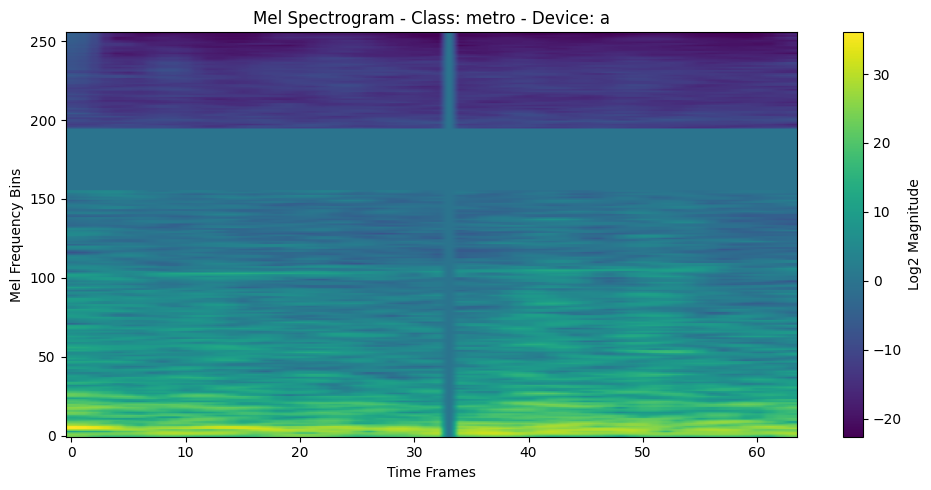

Testing Data Shapes:
  Waveforms: torch.Size([64, 1, 256, 64]) (batch_size, mel_bins, time_steps)



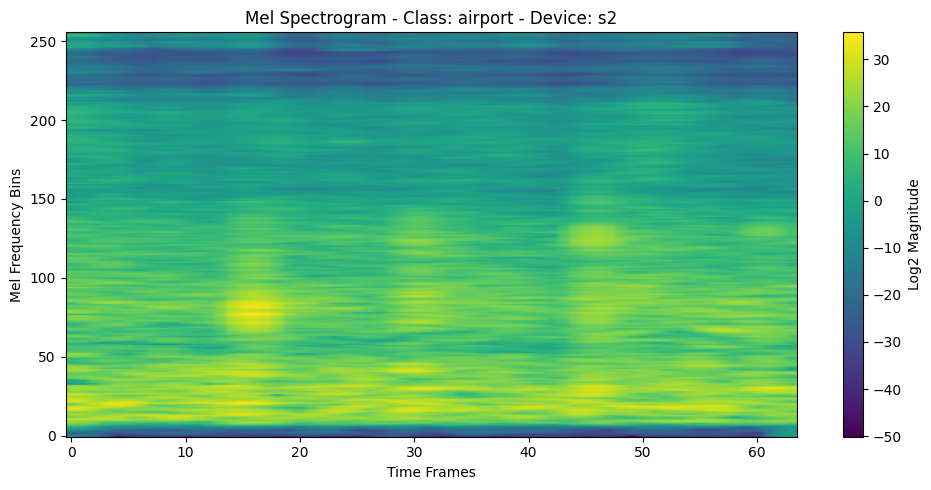

In [8]:
analyze_data_shapes(train_loader, "Training")
for waveforms, devices, labels in train_loader:
    i = random.randint(0,params['batch_size']-1)
    plot_mel_spectrogram(waveforms[i], labels[i], get_device_name(dev=int(devices[i])))
    break

analyze_data_shapes(test_loader, "Testing")
for waveforms, devices, labels in test_loader:
    i = random.randint(0,params['batch_size']-1)
    plot_mel_spectrogram(waveforms[i], labels[i], get_device_name(dev=int(devices[i])))
    break

# Defining Model

In [ ]:
###CP mobile model
import torch
import torch.nn as nn
from torch.ao.quantization import QuantStub, DeQuantStub
from torchvision.ops import Conv2dNormActivation  # Updated import

def make_divisible(v, divisor=8, min_value=None):
    """Ensure a number is divisible by divisor, used for channel alignment."""
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class GRN(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.dequant(x)
        gx = torch.norm(x, p=2, dim=(2, 3), keepdim=True)
        nx = gx / (gx.mean(dim=1, keepdim=True) + 1e-6)
        x = self.gamma * (x * nx) + self.beta + x
        return self.quant(x)

class CPMobileBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_rate, stride):
        super().__init__()
        exp_channels = make_divisible(in_channels * expansion_rate, 8)
        exp_conv = Conv2dNormActivation(in_channels, exp_channels, kernel_size=1, stride=1, 
                                       norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU, inplace=False)
        depth_conv = Conv2dNormActivation(exp_channels, exp_channels, kernel_size=3, stride=stride, padding=1, 
                                         groups=exp_channels, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU, inplace=False)
        proj_conv = Conv2dNormActivation(exp_channels, out_channels, kernel_size=1, stride=1, 
                                        norm_layer=nn.BatchNorm2d, activation_layer=None, inplace=False)
        self.after_block_norm = GRN()
        self.after_block_activation = nn.ReLU()
        self.use_shortcut = in_channels == out_channels and (stride == 1 or stride == (1, 1))
        self.shortcut = nn.Sequential() if self.use_shortcut else None
        self.block = nn.Sequential(exp_conv, depth_conv, proj_conv)
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        result = self.block(x)
        if self.use_shortcut:
            result = self.skip_add.add(result, self.shortcut(x))
        result = self.after_block_norm(result)
        result = self.after_block_activation(result)
        return result

class MelSpectrogramNetwork(nn.Module):
    def __init__(self, config):
        super(MelSpectrogramNetwork, self).__init__()
        n_classes = config['n_classes']
        in_channels = config['in_channels']
        base_channels = config['base_channels']
        channels_multiplier = config['channels_multiplier']
        expansion_rate = config['expansion_rate']
        n_blocks = config['n_blocks']
        strides = config['strides']
        n_stages = len(n_blocks)

        base_channels = make_divisible(base_channels, 8)
        channels_per_stage = [base_channels] + [make_divisible(base_channels * channels_multiplier ** stage_id, 8)
                                              for stage_id in range(n_stages)]
        self.total_block_count = 0
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        self.in_c = nn.Sequential(
            Conv2dNormActivation(in_channels, channels_per_stage[0] // 4, kernel_size=3, stride=2, inplace=False),
            Conv2dNormActivation(channels_per_stage[0] // 4, channels_per_stage[0], 
                                activation_layer=torch.nn.ReLU, kernel_size=3, stride=2, inplace=False),
        )

        self.stages = nn.Sequential()
        for stage_id in range(n_stages):
            stage = self._make_stage(channels_per_stage[stage_id], channels_per_stage[stage_id + 1],
                                   n_blocks[stage_id], strides=strides, expansion_rate=expansion_rate)
            self.stages.add_module(f"s{stage_id + 1}", stage)

        self.feed_forward = nn.Sequential(
            nn.Conv2d(channels_per_stage[-1], n_classes, kernel_size=(1, 1), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(n_classes),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, strides, expansion_rate):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_id = self.total_block_count + 1
            bname = f'b{block_id}'
            self.total_block_count += 1
            stride = strides.get(bname, (1, 1))
            block = CPMobileBlock(in_channels, out_channels, expansion_rate, stride)
            stage.add_module(bname, block)
            in_channels = out_channels
        return stage

    def forward(self, x):
        x = self.quant(x)
        x = self.in_c(x)
        x = self.stages(x)
        x = self.feed_forward(x)
        logits = x.squeeze(2).squeeze(2)
        logits = self.dequant(logits)
        return logits

    def fuse_model(self):
        for m in self.named_modules():
            module_name = m[0]
            module_instance = m[1]
            if module_name == 'in_c':
                torch.quantization.fuse_modules(module_instance[0], ['0', '1', '2'], inplace=True)
                torch.quantization.fuse_modules(module_instance[1], ['0', '1', '2'], inplace=True)
            elif isinstance(module_instance, CPMobileBlock):
                torch.quantization.fuse_modules(module_instance.block[0], ['0', '1', '2'], inplace=True)
                torch.quantization.fuse_modules(module_instance.block[1], ['0', '1', '2'], inplace=True)
                torch.quantization.fuse_modules(module_instance.block[2], ['0', '1'], inplace=True)
            elif module_name == "feed_forward":
                torch.quantization.fuse_modules(module_instance, ['0', '1'], inplace=True)

def get_mel_spectrogram_model():
    strides = {
        'b2': (2, 2),
        'b4': (2, 1)
    }
    model_config = {
        "n_classes": 10,
        "in_channels": 1,  # Mel spectrogram typically has 1 channel
        "base_channels": 32,
        "channels_multiplier": 2.0,
        "expansion_rate": 3.0,
        "n_blocks": [3, 3, 2],  # Adjusted for 256x64 input
        "strides": strides
    }
    return MelSpectrogramNetwork(model_config)

# Example usage
'''if __name__ == "__main__":
    model = get_mel_spectrogram_model()
    dummy_input = torch.randn(1, 1, 256, 64)  # Batch, Channels, Height, Width
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")  # Should be [1, 10]'''

'if __name__ == "__main__":\n    model = get_mel_spectrogram_model()\n    dummy_input = torch.randn(1, 1, 256, 64)  # Batch, Channels, Height, Width\n    output = model(dummy_input)\n    print(f"Output shape: {output.shape}")  # Should be [1, 10]'

# You can use any of the following teacher models instead of the one above for training.

In [ ]:
###DSFlexi_ver_a
'''
def ReParametrize(module):
    """
    Recursively replaces all RepConv2d layers in a module with their reparametrized version.
    """
    for name, child in list(module.named_children()):
        if isinstance(child, RepConv2d):
            # print(f"Reparametrizing {name}")
            new_module = child.get_reparametrized_layer()
            setattr(module, name, new_module)
        else:
            ReParametrize(child)


class RepConv2d(nn.Module):
    def __init__(self, input_channel, output_channel, stride=(1, 1), groups=1):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.stride = stride

        # Initial convolutions
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 3),
                               stride=stride, padding=(1, 1), bias=False,groups=groups)
        self.bn1 = nn.BatchNorm2d(output_channel)

        self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 3),
                               stride=stride, padding=(0, 1), bias=False,groups=groups)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.conv3 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 1),
                               stride=stride, padding=(1, 0), bias=False,groups=groups)
        self.bn3 = nn.BatchNorm2d(output_channel)

        self.conv4 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 1),
                               stride=stride, padding=(0, 0), bias=False,groups=groups)
        self.bn4 = nn.BatchNorm2d(output_channel)

    def forward(self, x):
        x1 = self.conv1(x)
        # x1 = self.bn1(x1)
        x2 = self.conv2(x)
        # x2 = self.bn2(x2)
        x3 = self.conv3(x)
        # x3 = self.bn3(x3)
        x4 = self.conv4(x)
        # x4 = self.bn4(x4)
        return x1 + x2 + x3 + x4

    def merge_batchnorms(self):
        bn_list = [self.bn1, self.bn2, self.bn3, self.bn4]
        num_features = bn_list[0].num_features
        merged_bn = nn.BatchNorm2d(num_features).to(bn_list[0].weight.device)

        # Merge running stats
        merged_bn.running_mean = torch.mean(torch.stack([bn.running_mean for bn in bn_list]), dim=0)
        merged_bn.running_var = torch.mean(torch.stack([bn.running_var for bn in bn_list]), dim=0)

        if bn_list[0].affine:
            merged_bn.weight.data = torch.mean(torch.stack([bn.weight.data for bn in bn_list]), dim=0)
            merged_bn.bias.data = torch.mean(torch.stack([bn.bias.data for bn in bn_list]), dim=0)

        return merged_bn

    def merge_convs(self):
        conv2ds_list = [self.conv1, self.conv2, self.conv3, self.conv4]
        main_shape = conv2ds_list[0].weight.data.shape
        device = conv2ds_list[0].weight.device  # Get device from one of the convs

        # Initialize zero tensors on the correct device
        conv1 = conv2ds_list[0].weight.data
        conv2 = torch.zeros(main_shape, device=device)
        conv3 = torch.zeros(main_shape, device=device)
        conv4 = torch.zeros(main_shape, device=device)

        # Fill the corresponding parts
        conv2[:, :, 1, :] = conv2ds_list[1].weight.data.squeeze(2)
        conv3[:, :, :, 1] = conv2ds_list[2].weight.data.squeeze(3)
        conv4[:, :, 1, 1] = conv2ds_list[3].weight.data.squeeze(3).squeeze(2)

        # Create new Conv2d layer on same device
        conv2d = nn.Conv2d(
            in_channels=self.conv1.in_channels,
            out_channels=self.conv1.out_channels,
            kernel_size=self.conv1.kernel_size,
            stride=self.conv1.stride,
            padding=self.conv1.padding,
            bias=False,
            groups=self.conv1.groups
        ).to(device)

        with torch.no_grad():
            conv2d.weight.copy_((conv1 + conv2 + conv3 + conv4))

        return conv2d

    def get_reparametrized_layer(self):
        conv2d = self.merge_convs()
        bn = self.merge_batchnorms()
        # return nn.Sequential(conv2d, bn)
        return nn.Sequential(conv2d)

class LearnablePooling(nn.Module):
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        self.bn_input = nn.BatchNorm2d(in_channels)
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = nn.BatchNorm2d(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  

    def forward(self, x):
        x_norm = self.bn_input(x)
        
        attn = self.attn_conv(x_norm)
        attn_norm = self.bn_attn(attn)
        attn_act = self.act(attn_norm)
        scores = self.attn_score(attn_act)
        b, c, h, w = x.size()
        weights = F.softmax(scores.view(b, c, -1), dim=-1)
        weights = weights.view(b, c, h, w)
        attn_pooled = (x * weights).view(b, c, -1).sum(dim=-1)  
        
        gap = self.global_avg_pool(x).view(b, c)  
        
        out = torch.cat([attn_pooled, gap], dim=1) 
        return out


class ResidualNormalization(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.lambda_param = nn.Parameter(torch.ones(1))
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)
    
    def forward(self, x):
        return self.lambda_param * x + self.instance_norm(x) 

class DSFlexiNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = True

        mid_channels = out_channels 
        
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.scaleinput = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.act1 = nn.LeakyReLU()
        self.do1 = nn.Dropout2d(0)
        
        self.norm2 = nn.BatchNorm2d(mid_channels)
        self.conv2 = RepConv2d(input_channel=mid_channels, output_channel=mid_channels, stride=stride, groups=mid_channels)
        self.act2 = nn.LeakyReLU()
        # self.do2 = nn.Dropout2d(0)

        self.norm3 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels , out_channels , kernel_size = 1 , bias = False , groups = mid_channels )
        self.do3 = nn.Dropout2d(0.15)     
        
        self.norm4 = ResidualNormalization(out_channels)       
        
    def forward(self, x):   
        
        out = self.norm1(x)
        scaledInput = self.scaleinput(x) if self.use_skip else None
        out = self.conv1(out)
        out = self.act1(out)
        out = self.do1(out)

        out = self.norm2(out)
        out = self.conv2(out)
        out = self.act2(out)
        # out = self.do2(out)

        out = self.norm3(out)
        out = self.conv3(out)
        out = self.act2(out)
        out = self.do3(out)
        
        if self.use_skip:
            out = out + scaledInput
        
        out = self.norm4(out)
        
        return out

class DSFlexiNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Initial convolutions
        self.initial_conv1 = RepConv2d(input_channel=1, output_channel=16, stride=(2,2))
        self.rn1 = nn.BatchNorm2d(1)
        self.act1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.1)
        
        self.initial_conv2 = RepConv2d(input_channel=16, output_channel=32, stride=(2,2))
        self.rn2 = nn.BatchNorm2d(16)
        self.act2 = nn.ReLU()
        
        # DS-FlexiNet blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(32 , 32 ,  stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(32 , 32 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock( 32 , 32 , stride=(1,1), expansion_factor=6)
        )

        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(64 , 64 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(64 , 64 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(64 , 64 , stride=(1,1), expansion_factor=6),
        )
        
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock( 96 , 128 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock( 128 , 128 , stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock( 128 , 128 , stride=(1,1), expansion_factor=6),
        )
        
        # Global average pooling and fully connected layer
        self.avgpool_3 = LearnablePooling(128)
        self.avgpool_2 = LearnablePooling(64)
        self.avgpool_1 = LearnablePooling(32)
        self.bn_final = nn.BatchNorm1d((128+32+64) * 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(((128+32+64) * 2 ), num_classes)
        # self.act3 = nn.ReLU()
        # self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x, recording_device=None):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.rn1(x)
        x = self.initial_conv1(x)
        x = self.act1(x)
        x = self.rn2(x)
        x = self.initial_conv2(x)
        x = self.act2(x)
        x = self.dropout_1(x)
        
        x_1_o1 = self.stage1(x)
        x_1 = torch.cat([x , x_1_o1 ] , dim = 1)
        x_2_o2 = self.stage2(x_1) 
        x_2 = torch.cat([x , x_2_o2] , dim = 1)
        x_3_o3 = self.stage3(x_2)
        x_3 = torch.cat([x , x_2] , dim = 1)
        
        x_3_o3= self.avgpool_3(x_3_o3)
        x_2_o2= self.avgpool_2(x_2_o2)
        x_1_o1= self.avgpool_1(x_1_o1)
        x = torch.cat([x_3_o3 , x_2_o2 , x_1_o1] , dim = 1)                     
        x = self.dropout(x)
        x = self.bn_final(x)
        x = self.fc1(x)
        # x = self.act3(x)
        # x = self.fc2(x)
        return x

print("Model architecture defined")
'''

In [ ]:
###DSFlexi_ver_m1
'''
def get_reparametrized_layer(self):
    conv2d = self.merge_convs()
    bn = self.merge_batchnorms()
    # return nn.Sequential(conv2d, bn)
    return nn.Sequential(conv2d)
class LearnablePooling(nn.Module):
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        self.bn_input = nn.BatchNorm2d(in_channels)
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = nn.BatchNorm2d(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  

    def forward(self, x):
        x_norm = self.bn_input(x)
        
        attn = self.attn_conv(x_norm)
        attn_norm = self.bn_attn(attn)
        attn_act = self.act(attn_norm)
        scores = self.attn_score(attn_act)
        b, c, h, w = x.size()
        weights = F.softmax(scores.view(b, c, -1), dim=-1)
        weights = weights.view(b, c, h, w)
        attn_pooled = (x * weights).view(b, c, -1).sum(dim=-1)  
        
        gap = self.global_avg_pool(x).view(b, c)  
        
        out = torch.cat([attn_pooled, gap], dim=1) 
        return out


class ResidualNormalization(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.lambda_param = nn.Parameter(torch.ones(1))
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)
    
    def forward(self, x):
        return self.lambda_param * x + self.instance_norm(x) 

class DSFlexiNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = (in_channels <= out_channels)

        mid_channels = in_channels * expansion_factor
        
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.scaleinput = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.act1 = nn.LeakyReLU()
        # self.do1 = nn.Dropout2d(0)
        
        self.norm2 = nn.BatchNorm2d(mid_channels)
        # self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, 
        #                       padding=1, groups=mid_channels, bias=False)
        self.conv2 = RepConv2d(input_channel=mid_channels, output_channel=mid_channels, stride=stride, groups=mid_channels)
        self.act2 = nn.LeakyReLU()
        # self.do2 = nn.Dropout2d(0)

        self.norm3 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.do3 = nn.Dropout2d(0.1)     
        
        self.norm4 = ResidualNormalization(out_channels)       
        
    def forward(self, x):       
        out = self.norm1(x)
        scaledInput = self.scaleinput(x) if self.use_skip else None
        out = self.conv1(x)
        out = self.act1(out)
        # out = self.do1(out)

        out = self.norm2(out)
        out = self.conv2(out)
        out = self.act2(out)
        # out = self.do2(out)

        out = self.norm3(out)
        out = self.conv3(out)
        out = self.do3(out)
        
        if self.use_skip:
            out = out + scaledInput
        
        out = self.norm4(out)
        
        return out

class DSFlexiNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Initial convolutions
        # self.initial_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.initial_conv1 = RepConv2d(input_channel=1, output_channel=16, stride=(2,2))
        self.rn1 = ResidualNormalization(16)
        self.act1 = nn.ReLU()
        # self.do1 = nn.Dropout2d(0.15)
        
        # self.initial_conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.initial_conv2 = RepConv2d(input_channel=16, output_channel=16, stride=(2,2))
        self.rn2 = ResidualNormalization(16)
        self.act2 = nn.ReLU()
        # self.do2 = nn.Dropout2d(0.15)
        
        # DS-FlexiNet blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6)
        )

        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
        )
        
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock(16, 16, stride=(1,1), expansion_factor=6),
        )
        
        # Global average pooling and fully connected layer
        self.avgpool = LearnablePooling(16)
        self.bn_final = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32,16)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(16, num_classes)
        
    def forward(self, x, recording_device=None):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.initial_conv1(x)
        x = self.rn1(x)
        x = self.act1(x)
        # x = self.do1(x)
        x = self.initial_conv2(x)
        x = self.rn2(x)
        x = self.act2(x)
        # x = self.do2(x)
        x = self.stage1(x) + x
        x = self.stage2(x) + x
        x = self.stage3(x)
        x = self.avgpool(x)
        x = self.bn_final(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        return x

'''

In [ ]:
###DSFlexi_ver_m2
'''
class RepConv2d(nn.Module):
    def __init__(self, input_channel, output_channel, stride=(1, 1), groups=1):
        super().__init__()
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.stride = stride

        # Initial convolutions
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 3),
                               stride=stride, padding=(1, 1), bias=False,groups=groups)
        self.bn1 = nn.BatchNorm2d(output_channel)
        
        self.conv2 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 3),
                               stride=stride, padding=(0, 1), bias=False,groups=groups)
        self.bn2 = nn.BatchNorm2d(output_channel)
        
        self.conv3 = nn.Conv2d(input_channel, output_channel, kernel_size=(3, 1),
                               stride=stride, padding=(1, 0), bias=False,groups=groups)
        self.bn3 = nn.BatchNorm2d(output_channel)
        
        self.conv4 = nn.Conv2d(input_channel, output_channel, kernel_size=(1, 1),
                               stride=stride, padding=(0, 0), bias=False,groups=groups)
        self.bn4 = nn.BatchNorm2d(output_channel)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)

        x2 = self.conv2(x)
        x2 = self.bn2(x2)

        x3 = self.conv3(x)
        x3 = self.bn3(x3)

        x4 = self.conv4(x)
        x4 = self.bn4(x4)

        return x1 + x2 + x3 + x4

    def merge_convs(self):
        conv2ds_list = [self.conv1, self.conv2, self.conv3, self.conv4]
        main_shape = conv2ds_list[0].weight.data.shape
        device = conv2ds_list[0].weight.device  # Get device from one of the convs

        # Initialize zero tensors on the correct device
        conv1 = conv2ds_list[0].weight.data
        conv2 = torch.zeros(main_shape, device=device)
        conv3 = torch.zeros(main_shape, device=device)
        conv4 = torch.zeros(main_shape, device=device)

        # Fill the corresponding parts
        conv2[:, :, 1, :] = conv2ds_list[1].weight.data.squeeze(2)
        conv3[:, :, :, 1] = conv2ds_list[2].weight.data.squeeze(3)
        conv4[:, :, 1, 1] = conv2ds_list[3].weight.data.squeeze(3).squeeze(2)

        # Create new Conv2d layer on same device
        conv2d = nn.Conv2d(
            in_channels=self.conv1.in_channels,
            out_channels=self.conv1.out_channels,
            kernel_size=self.conv1.kernel_size,
            stride=self.conv1.stride,
            padding=self.conv1.padding,
            bias=False,
            groups=self.conv1.groups
        ).to(device)

        with torch.no_grad():
            conv2d.weight.copy_((conv1 + conv2 + conv3 + conv4))

        return conv2d

    def get_reparametrized_layer(self):
        conv2d = self.merge_convs()
        return nn.Sequential(conv2d)


class LearnablePooling(nn.Module):
    def __init__(self, in_channels, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_channels // 2
        self.bn_input = ResidualNormalization(in_channels)
        self.attn_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False)
        self.bn_attn = ResidualNormalization(hidden_dim)
        self.attn_score = nn.Conv2d(hidden_dim, in_channels, kernel_size=1, bias=False)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  

    def forward(self, x):
        x_norm = self.bn_input(x)
        
        attn = self.attn_conv(x_norm)
        attn_norm = self.bn_attn(attn)
        attn_act = self.act(attn_norm)
        scores = self.attn_score(attn_act)
        b, c, h, w = x.size()
        weights = F.softmax(scores.view(b, c, -1), dim=-1)
        weights = weights.view(b, c, h, w)
        attn_pooled = (x * weights).view(b, c, -1).sum(dim=-1)  
        
        gap = self.global_avg_pool(x).view(b, c)  
        
        out = torch.cat([attn_pooled, gap], dim=1) 
        return out


class ResidualNormalization(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # One lambda per feature/channel
        self.lambda_param = nn.Parameter(torch.ones(num_features, 1, 1))  # Shape: [C, 1, 1]
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=True)

    def forward(self, x):
        # x shape: [B, C, H, W]
        return self.lambda_param * x + self.instance_norm(x)

class DSFlexiNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=6):
        super().__init__()
        self.stride = stride
        self.use_skip = (in_channels == out_channels)

        mid_channels = in_channels * expansion_factor
        
        self.norm1 = ResidualNormalization(in_channels)
        self.scaleinput = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.act1 = nn.LeakyReLU()
        # self.do1 = nn.Dropout2d(0)
        
        self.norm2 = ResidualNormalization(mid_channels)
        # self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, 
        #                       padding=1, groups=mid_channels, bias=False)
        self.conv2 = RepConv2d(input_channel=mid_channels, output_channel=mid_channels, stride=stride, groups=mid_channels)
        self.act2 = nn.LeakyReLU()
        # self.do2 = nn.Dropout2d(0)

        self.norm3 = ResidualNormalization(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.do3 = nn.Dropout2d(0.1)     
        
        self.norm4 = ResidualNormalization(out_channels)       
        
    def forward(self, x):       
        out = self.norm1(x)
        scaledInput = self.scaleinput(x) if self.use_skip else None
        out = self.conv1(x)
        out = self.act1(out)
        # out = self.do1(out)

        out = self.norm2(out)
        out = self.conv2(out)
        out = self.act2(out)
        # out = self.do2(out)

        out = self.norm3(out)
        out = self.conv3(out)
        out = self.do3(out)
        
        if self.use_skip:
            out = out + scaledInput
        
        out = self.norm4(out)
        
        return out

class DSFlexiNet(nn.Module):
    def __init__(self, num_classes=10, chnls = [1,16,16,16,16,16,16,16], exp_f = [6,6,6,6,6,6]):
        super().__init__()
        # Initial convolutions
        self.init_norm = nn.BatchNorm2d(chnls[0])
        self.initial_conv1 = RepConv2d(input_channel=1, output_channel=chnls[1], stride=(2,2))
        self.rn1 = ResidualNormalization(chnls[1])
        self.act1 = nn.ReLU()
        # self.do1 = nn.Dropout2d(0.15)
        
        # self.initial_conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.initial_conv2 = RepConv2d(input_channel=chnls[1], output_channel=chnls[2], stride=(2,2))
        self.rn2 = ResidualNormalization(chnls[2])
        self.act2 = nn.ReLU()
        # self.do2 = nn.Dropout2d(0.15)
        
        # DS-FlexiNet blocks
        self.stage1 = nn.Sequential(
            DSFlexiNetBlock(chnls[2], chnls[3], stride=(1,1), expansion_factor=exp_f[0]),
            DSFlexiNetBlock(chnls[3], chnls[4], stride=(1,1), expansion_factor=exp_f[1]),
            DSFlexiNetBlock(chnls[4], chnls[2], stride=(1,1), expansion_factor=exp_f[2])
        )

        self.stage2 = nn.Sequential(
            DSFlexiNetBlock(chnls[2], chnls[5], stride=(1,1), expansion_factor=exp_f[3]),
            DSFlexiNetBlock(chnls[5], chnls[2], stride=(1,1), expansion_factor=exp_f[4]),
        )
        
        self.stage3 = nn.Sequential(
            DSFlexiNetBlock(chnls[2], chnls[6], stride=(1,1), expansion_factor=exp_f[5]),
        )
        
        # Global average pooling and fully connected layer
        self.avgpool = LearnablePooling(chnls[6])
        self.bn_final = nn.BatchNorm1d(chnls[6]*2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(chnls[6]*2,chnls[7])
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(chnls[7], num_classes)
        
    def forward(self, x, recording_device=None):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.init_norm(x)
        x = self.initial_conv1(x)
        x = self.rn1(x)
        x = self.act1(x)
        # x = self.do1(x)
        x = self.initial_conv2(x)
        x = self.rn2(x)
        x = self.act2(x)
        # x = self.do2(x)
        x = self.stage1(x) + x
        x = self.stage2(x) + x
        x = self.stage3(x)
        x = self.avgpool(x)
        x = self.bn_final(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        return x

print("Model architecture defined")
'''

In [ ]:
###CP-ResNet
'''
# coding: utf-8
import math
import torch.nn as nn
import torch
# Global variable for layer indexing
layer_index_total = 0
first_RUN = True

def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_in', nonlinearity="relu")
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()

def initialize_weights_fixup(module):
    global layer_index_total
    if isinstance(module, BasicBlock):
        b = module
        n = b.conv1.kernel_size[0] * b.conv1.kernel_size[1] * b.conv1.out_channels
        b.conv1.weight.data.normal_(0, (layer_index_total ** (-0.5)) * math.sqrt(2. / n))
        b.conv2.weight.data.zero_()
        if b.shortcut._modules.get('conv') is not None:
            convShortcut = b.shortcut._modules.get('conv')
            n = convShortcut.kernel_size[0] * convShortcut.kernel_size[1] * convShortcut.out_channels
            convShortcut.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        if module.bias:
            module.bias.data.zero_()

def calc_padding(kernal):
    try:
        return kernal // 3
    except TypeError:
        return [k // 3 for k in kernal]

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride, k1=3, k2=3, groups=1):
        super(BasicBlock, self).__init__()
        global layer_index_total
        self.layer_index = layer_index_total
        layer_index_total += 1
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            groups=groups,
            kernel_size=k1,
            stride=stride,
            padding=calc_padding(k1),
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            groups=groups,
            kernel_size=k2,
            stride=1,
            padding=calc_padding(k2),
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_add = nn.quantized.FloatFunctional()
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    padding=0,
                    bias=False,
                    groups=groups
                )
            )
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))
        self.relu2 = nn.ReLU()

    def forward(self, x):
        y = self.relu1(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y = self.skip_add.add(y, self.shortcut(x))
        y = self.relu2(y)
        return y

def safe_list_get(l, idx, default):
    try:
        return l[idx]
    except IndexError:
        return default

class Network(nn.Module):
    def __init__(self, config):
        super(Network, self).__init__()
        input_shape = config['input_shape']
        n_classes = config['n_classes']
        channels_multiplier = config['channels_multiplier']
        base_channels = config['base_channels']
        cut_channels_s2 = config['cut_channels_s2']
        cut_channels_s3 = config['cut_channels_s3']
        n_blocks_per_stage = config.get("n_blocks_per_stage")
        self.pooling_padding = config.get("pooling_padding", 0)
        self.maxpool_kernel = config.get("maxpool_kernel", (2, 2))
        self.maxpool_stride = config.get("maxpool_stride", (2, 2))

        n_channels = [
            base_channels,
            base_channels * channels_multiplier - cut_channels_s2,
            base_channels * channels_multiplier * channels_multiplier - cut_channels_s3
        ]

        self.in_c = nn.Sequential(
            nn.Conv2d(
                input_shape[1],
                n_channels[0],
                kernel_size=5,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(n_channels[0]),
            nn.ReLU(True)
        )
        self.stage1 = self._make_stage(
            n_channels[0], n_channels[0], n_blocks_per_stage[0], BasicBlock,
            maxpool_pos=config['stage1']['maxpool_positions'],
            k1s=config['stage1']['k1s'],
            k2s=config['stage1']['k2s'],
            groups=config['stage1']['groups'],
            maxpool_pos0_kernel=config['stage1']['maxpool_pos0_kernel'],
            maxpool_pos0_stride=config['stage1']['maxpool_pos0_stride']
        )
        self.stage2 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage[1], BasicBlock,
            maxpool_pos=config['stage2']['maxpool_positions'],
            k1s=config['stage2']['k1s'],
            k2s=config['stage2']['k2s'],
            groups=config['stage2']['groups']
        )
        if n_blocks_per_stage[2] == 0:
            self.stage3 = nn.Sequential()
            n_channels[2] = n_channels[1]
        else:
            self.stage3 = self._make_stage(
                n_channels[1], n_channels[2], n_blocks_per_stage[2], BasicBlock,
                maxpool_pos=config['stage3']['maxpool_positions'],
                k1s=config['stage3']['k1s'],
                k2s=config['stage3']['k2s'],
                groups=config['stage3']['groups']
            )

        self.width_per_block = n_channels
        ff_list = [
            nn.Conv2d(n_channels[2], n_classes, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(n_classes),
            nn.AdaptiveAvgPool2d((1, 1))
        ]
        self.feed_forward = nn.Sequential(*ff_list)

        self.apply(initialize_weights)
        if isinstance(self.feed_forward[0], nn.Conv2d):
            self.feed_forward[0].weight.data.zero_()
        self.apply(initialize_weights_fixup)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, maxpool_pos=set(), k1s=[3, 3, 3, 3, 3, 3],
                    k2s=[3, 3, 3, 3, 3, 3], groups=1, maxpool_pos0_kernel=None, maxpool_pos0_stride=None):
        if maxpool_pos0_kernel is None:
            maxpool_pos0_kernel = self.maxpool_kernel
        if maxpool_pos0_stride is None:
            maxpool_pos0_stride = self.maxpool_stride

        stride = 1
        stage = nn.Sequential()
        if 0 in maxpool_pos:
            stage.add_module(
                "maxpool{}_{}".format(0, 0),
                nn.MaxPool2d(
                    kernel_size=maxpool_pos0_kernel,
                    stride=maxpool_pos0_stride,
                    padding=self.pooling_padding
                )
            )
        for index in range(n_blocks):
            stage.add_module(
                'block{}'.format(index + 1),
                block(
                    in_channels,
                    out_channels,
                    stride=stride,
                    k1=safe_list_get(k1s, index, 1),
                    k2=safe_list_get(k2s, index, 1),
                    groups=groups
                )
            )
            in_channels = out_channels
            for m_i, mp_pos in enumerate(maxpool_pos):
                if index + 1 == mp_pos:
                    stage.add_module(
                        "maxpool{}_{}".format(index + 1, m_i),
                        nn.MaxPool2d(
                            kernel_size=self.maxpool_kernel,
                            stride=self.maxpool_stride,
                            padding=self.pooling_padding
                        )
                    )
        return stage

    def forward(self, x):
        global first_RUN
        x = self._forward_conv(x)
        x = self.feed_forward(x)
        logit = x.squeeze(2).squeeze(2)
        if first_RUN:
            print("logit:", logit.size())
            first_RUN = False
        return logit

    def _forward_conv(self, x):
        global first_RUN
        if first_RUN:
            print("x:", x.size())
        x = self.in_c(x)
        if first_RUN:
            print("in_c:", x.size())
        x = self.stage1(x)
        if first_RUN:
            print("stage1:", x.size())
        x = self.stage2(x)
        if first_RUN:
            print("stage2:", x.size())
        x = self.stage3(x)
        if first_RUN:
            print("stage3:", x.size())
        return x

def get_model(rho=8, in_channels=1, arch="cp_resnet", n_classes=10,
              base_channels=32, cut_channels_s2=0, cut_channels_s3=36, channels_multiplier=2, n_blocks=(2, 1, 1),
              s1_group=1, s2_group=2, s3_group=1,
              maxpool_pos_stage1=None, maxpool_pos_stage2=None, maxpool_pos_stage3=None,
              maxpool_stage1_pos0_kernel=(2, 2), maxpool_stage1_pos0_stride=(2, 2),
              maxpool_kernel=(2, 2), maxpool_stride=(2, 2)):
    if maxpool_pos_stage1 is None:
        maxpool_pos_stage1 = [0, 1]
    if maxpool_pos_stage2 is None:
        maxpool_pos_stage2 = []
    if maxpool_pos_stage3 is None:
        maxpool_pos_stage3 = []

    extra_kernal_rf = rho - 4
    model_config = {
        "arch": arch,
        "base_channels": base_channels,
        "cut_channels_s2": cut_channels_s2,
        "cut_channels_s3": cut_channels_s3,
        "channels_multiplier": channels_multiplier,
        "input_shape": [10, in_channels, 256, 64],  # Updated for mel spectrogram 256x64
        "n_blocks_per_stage": n_blocks,
        "n_classes": n_classes,
        "maxpool_kernel": maxpool_kernel,
        "maxpool_stride": maxpool_stride,
        "stage1": {
            "maxpool_positions": maxpool_pos_stage1,
            "maxpool_pos0_kernel": maxpool_stage1_pos0_kernel,
            "maxpool_pos0_stride": maxpool_stage1_pos0_stride,
            "k1s": [3, 3 - (-extra_kernal_rf > 2) * 2],
            "k2s": [1, 3 - (-extra_kernal_rf > 1) * 2],
            "groups": s1_group
        },
        "stage2": {
            "maxpool_positions": maxpool_pos_stage2,
            "k1s": [3 - (-extra_kernal_rf > 0) * 2, 1 + (extra_kernal_rf > 1) * 2],
            "k2s": [1 + (extra_kernal_rf > 0) * 2, 1 + (extra_kernal_rf > 2) * 2],
            "groups": s2_group
        },
        "stage3": {
            "maxpool_positions": maxpool_pos_stage3,
            "k1s": [1 + (extra_kernal_rf > 3) * 2, 1 + (extra_kernal_rf > 5) * 2],
            "k2s": [1 + (extra_kernal_rf > 4) * 2, 1 + (extra_kernal_rf > 6) * 2],
            "groups": s3_group
        },
    }
    return Network(model_config)
'''

# Train Pipeline

In [10]:
print("\n\nSTEP 1 --------------------------------------------------------------------")
model = get_mel_spectrogram_model().to(device)
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=0.05)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['nb_epochs'])
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Evaluation metric
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

model, best_acc, best_loss, train_losses, train_accs, val_losses, val_accs= train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler= scheduler,
    loss_fn=loss_fn,
    metric=metric,
    params=params,
    best_test_accuracy = 0.0,
    best_val_loss = float('inf'),
    model_name="step1"
)

# Validate
test_loss, test_acc, test_device_stats = evaluate_epoch(model, test_loader, loss_fn, metric, best_loss, best_acc)
print("\n\n")


# Get optimizer name
optimizer_name = optimizer.__class__.__name__
schdlr = scheduler.__class__.__name__ if scheduler != None else "None"
wd = optimizer.param_groups[0]['weight_decay']
NOTE = "My New Model + Baseline Config"
plot_training_history(train_losses, train_accs, val_losses, val_accs, details=f"Optimizer: {optimizer_name}, LR: {params['learning_rate']}, Weight Decay: {wd:1.3f}. Batch Size: {params['batch_size']}, Scheduler: {schdlr}\nNote: \"{NOTE}\"")



STEP 1 --------------------------------------------------------------------



Epoch 1/500


  Training - Loss: 1.8690, Accuracy: 33.1%
        a    	unk  	s1   	c    	b    	s2   	s3   
        34.2%	33.1%	28.6%	35.8%	31.9%	28.1%	28.1%


  Validation - Loss: 1.6215, Best Loss: inf, Accuracy: 41.0%, Best Acc: 0.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        38.4%	42.4%	36.4%	50.3%	38.3%	49.2%	41.0%

Epoch 2/500


  Training - Loss: 1.5823, Accuracy: 43.7%
        unk  	a    	c    	s1   	s2   	b    	s3   
        43.8%	44.7%	44.4%	38.7%	37.8%	41.2%	38.2%


  Validation - Loss: 1.4837, Best Loss: inf, Accuracy: 46.4%, Best Acc: 41.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.8%	47.5%	43.8%	51.1%	45.2%	50.4%	45.2%

Epoch 3/500


  Training - Loss: 1.4254, Accuracy: 49.7%
        unk  	a    	s2   	b    	s3   	c    	s1   
        49.6%	51.6%	42.7%	48.5%	42.6%	48.6%	43.2%


  Validation - Loss: 1.5042, Best Loss: inf, Accuracy: 46.0%, Best Acc: 46.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        44.9%	44.6%	42.3%	56.0%	43.0%	53.7%	45.0%

Epoch 4/500


  Training - Loss: 1.2934, Accuracy: 54.7%
        unk  	a    	s1   	s2   	s3   	c    	b    
        54.7%	56.9%	46.5%	45.9%	45.9%	54.1%	52.7%


  Validation - Loss: 1.4533, Best Loss: inf, Accuracy: 47.2%, Best Acc: 46.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        45.4%	47.8%	43.5%	57.4%	46.1%	52.9%	45.3%

Epoch 5/500


  Training - Loss: 1.2038, Accuracy: 57.9%
        unk  	a    	s2   	s3   	b    	s1   	c    
        57.9%	60.0%	48.6%	49.1%	56.5%	48.5%	55.2%


  Validation - Loss: 1.5749, Best Loss: inf, Accuracy: 45.1%, Best Acc: 47.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        42.1%	46.5%	42.0%	54.0%	45.0%	50.6%	41.3%

Epoch 6/500


  Training - Loss: 1.1326, Accuracy: 60.7%
        unk  	a    	c    	s1   	s3   	b    	s2   
        60.8%	62.5%	61.5%	51.4%	49.7%	57.5%	50.2%


  Validation - Loss: 1.4864, Best Loss: inf, Accuracy: 47.6%, Best Acc: 47.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.3%	46.6%	44.5%	57.9%	44.8%	52.3%	44.9%

Epoch 7/500


  Training - Loss: 1.0853, Accuracy: 62.4%
        unk  	a    	s3   	c    	s2   	b    	s1   
        62.4%	64.1%	54.1%	62.4%	53.5%	61.4%	53.2%


  Validation - Loss: 1.4351, Best Loss: inf, Accuracy: 49.4%, Best Acc: 47.6
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.7%	49.9%	46.4%	58.7%	48.3%	53.5%	45.1%

Epoch 8/500


  Training - Loss: 1.0363, Accuracy: 64.1%
        unk  	a    	s3   	b    	s1   	c    	s2   
        64.2%	65.9%	53.7%	63.5%	54.1%	63.9%	53.8%


  Validation - Loss: 1.5341, Best Loss: inf, Accuracy: 49.7%, Best Acc: 49.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.5%	49.7%	46.4%	59.9%	47.1%	54.9%	46.6%

Epoch 9/500


  Training - Loss: 0.9860, Accuracy: 65.9%
        unk  	s2   	a    	s1   	c    	b    	s3   
        65.9%	55.6%	67.7%	56.1%	64.6%	65.7%	54.9%


  Validation - Loss: 1.5388, Best Loss: inf, Accuracy: 48.4%, Best Acc: 49.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.0%	50.0%	45.9%	55.8%	46.6%	51.7%	46.0%

Epoch 10/500


  Training - Loss: 0.9460, Accuracy: 67.3%
        unk  	s1   	a    	b    	c    	s3   	s2   
        67.4%	57.1%	69.1%	66.6%	67.3%	57.7%	56.6%


  Validation - Loss: 1.4075, Best Loss: inf, Accuracy: 50.9%, Best Acc: 49.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	51.4%	47.8%	57.0%	49.6%	55.0%	48.5%

Epoch 11/500


  Training - Loss: 0.9229, Accuracy: 68.0%
        unk  	a    	c    	s2   	b    	s3   	s1   
        68.2%	69.3%	68.5%	56.7%	67.1%	58.6%	59.6%


  Validation - Loss: 1.4485, Best Loss: inf, Accuracy: 50.1%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.1%	50.0%	47.2%	58.9%	48.1%	53.3%	47.8%

Epoch 12/500


  Training - Loss: 0.9024, Accuracy: 68.9%
        unk  	a    	c    	s3   	s1   	s2   	b    
        69.0%	70.8%	68.8%	57.4%	59.0%	59.5%	68.6%


  Validation - Loss: 1.4939, Best Loss: inf, Accuracy: 49.9%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.2%	51.7%	47.1%	59.5%	49.0%	54.6%	42.2%

Epoch 13/500


  Training - Loss: 0.8795, Accuracy: 69.4%
        a    	unk  	c    	s3   	s2   	s1   	b    
        71.2%	69.5%	68.1%	58.0%	57.4%	59.0%	68.2%


  Validation - Loss: 1.4788, Best Loss: inf, Accuracy: 49.2%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.7%	49.0%	46.2%	58.2%	48.2%	54.0%	45.0%

Epoch 14/500


  Training - Loss: 0.8453, Accuracy: 70.7%
        b    	unk  	a    	c    	s1   	s3   	s2   
        70.7%	70.7%	72.7%	70.1%	61.3%	61.1%	60.2%


  Validation - Loss: 2.0031, Best Loss: inf, Accuracy: 40.6%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        41.6%	39.6%	38.4%	48.5%	37.3%	45.4%	37.7%

Epoch 15/500


  Training - Loss: 0.8443, Accuracy: 70.9%
        unk  	b    	a    	c    	s1   	s3   	s2   
        70.9%	70.4%	72.9%	71.1%	61.8%	61.7%	60.2%


  Validation - Loss: 1.4783, Best Loss: inf, Accuracy: 49.9%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.6%	50.8%	46.2%	60.7%	46.9%	55.0%	46.3%

Epoch 16/500


  Training - Loss: 0.8080, Accuracy: 72.0%
        unk  	a    	s3   	b    	s2   	c    	s1   
        72.1%	74.0%	59.6%	71.7%	60.2%	71.8%	63.2%


  Validation - Loss: 1.4827, Best Loss: inf, Accuracy: 50.3%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.6%	50.5%	46.3%	60.4%	47.6%	55.4%	48.4%

Epoch 17/500


  Training - Loss: 0.8064, Accuracy: 72.1%
        unk  	a    	s1   	c    	s3   	b    	s2   
        72.1%	73.6%	62.3%	75.2%	62.2%	72.9%	61.1%


  Validation - Loss: 2.2902, Best Loss: inf, Accuracy: 39.5%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        40.8%	36.1%	38.1%	46.0%	38.4%	43.7%	36.5%

Epoch 18/500


  Training - Loss: 0.7879, Accuracy: 72.8%
        unk  	a    	b    	s3   	c    	s2   	s1   
        73.1%	74.1%	72.4%	62.1%	72.8%	62.4%	61.1%


  Validation - Loss: 1.4747, Best Loss: inf, Accuracy: 50.3%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	49.6%	48.0%	57.9%	48.9%	52.3%	46.8%

Epoch 19/500


  Training - Loss: 0.7735, Accuracy: 73.3%
        unk  	a    	b    	c    	s2   	s1   	s3   
        73.6%	74.3%	73.4%	73.2%	62.0%	64.2%	60.7%


  Validation - Loss: 1.7860, Best Loss: inf, Accuracy: 43.0%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.2%	41.5%	40.8%	50.0%	38.8%	47.5%	41.0%

Epoch 20/500


  Training - Loss: 0.7628, Accuracy: 73.6%
        unk  	s3   	s1   	a    	b    	s2   	c    
        73.6%	63.3%	62.8%	75.3%	73.7%	62.8%	75.4%


  Validation - Loss: 1.6173, Best Loss: inf, Accuracy: 47.4%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.2%	48.9%	43.5%	55.2%	47.6%	48.6%	46.9%

Epoch 21/500


  Training - Loss: 0.7541, Accuracy: 73.9%
        unk  	b    	a    	c    	s1   	s2   	s3   
        74.1%	74.1%	75.2%	75.3%	63.6%	63.8%	63.9%


  Validation - Loss: 1.6121, Best Loss: inf, Accuracy: 48.3%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.5%	50.3%	45.5%	54.8%	46.2%	51.7%	45.5%

Epoch 22/500


  Training - Loss: 0.7360, Accuracy: 74.6%
        unk  	a    	b    	s1   	s2   	c    	s3   
        74.7%	76.3%	74.6%	65.8%	64.0%	75.1%	64.5%


  Validation - Loss: 2.2323, Best Loss: inf, Accuracy: 39.9%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        41.5%	40.2%	37.8%	46.1%	37.2%	43.6%	36.9%

Epoch 23/500


  Training - Loss: 0.7264, Accuracy: 75.1%
        a    	unk  	s2   	b    	s1   	s3   	c    
        76.7%	75.2%	64.2%	77.1%	64.2%	63.2%	76.0%


  Validation - Loss: 1.7218, Best Loss: inf, Accuracy: 47.0%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.1%	50.6%	43.8%	56.0%	42.5%	50.4%	45.7%

Epoch 24/500


  Training - Loss: 0.7333, Accuracy: 74.7%
        unk  	a    	s2   	s1   	c    	b    	s3   
        74.8%	76.4%	63.7%	63.5%	75.7%	75.2%	65.9%


  Validation - Loss: 1.5526, Best Loss: inf, Accuracy: 49.6%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.3%	51.6%	46.2%	58.8%	48.3%	51.9%	45.6%

Epoch 25/500


  Training - Loss: 0.7180, Accuracy: 75.2%
        unk  	s2   	a    	c    	b    	s1   	s3   
        75.4%	64.5%	76.9%	74.0%	76.2%	65.8%	64.5%


  Validation - Loss: 1.5048, Best Loss: inf, Accuracy: 50.7%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	50.3%	47.8%	59.4%	48.6%	54.2%	48.8%

Epoch 26/500


  Training - Loss: 0.7163, Accuracy: 75.4%
        unk  	a    	b    	s3   	s1   	c    	s2   
        75.6%	76.5%	74.9%	66.7%	65.5%	76.1%	64.3%


  Validation - Loss: 1.5316, Best Loss: inf, Accuracy: 50.5%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	51.2%	47.6%	55.5%	49.1%	54.3%	46.6%

Epoch 27/500


  Training - Loss: 0.7012, Accuracy: 75.9%
        unk  	a    	c    	b    	s1   	s2   	s3   
        76.1%	77.1%	78.0%	75.2%	65.9%	64.3%	67.8%


  Validation - Loss: 1.5307, Best Loss: inf, Accuracy: 49.4%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.2%	52.5%	44.5%	58.7%	47.6%	53.4%	49.6%

Epoch 28/500


  Training - Loss: 0.7055, Accuracy: 75.8%
        unk  	a    	s1   	c    	s3   	b    	s2   
        76.0%	77.2%	65.0%	78.2%	64.2%	75.7%	63.8%


  Validation - Loss: 1.5089, Best Loss: inf, Accuracy: 51.2%, Best Acc: 50.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	52.7%	46.7%	60.4%	49.4%	56.4%	48.3%

Epoch 29/500


  Training - Loss: 0.6993, Accuracy: 75.9%
        unk  	a    	s2   	c    	s1   	b    	s3   
        76.2%	77.2%	63.9%	74.3%	66.4%	75.7%	64.4%


  Validation - Loss: 1.6563, Best Loss: inf, Accuracy: 46.3%, Best Acc: 51.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.3%	49.2%	42.4%	56.7%	47.5%	47.0%	42.9%

Epoch 30/500


  Training - Loss: 0.6806, Accuracy: 76.7%
        unk  	a    	s3   	s2   	s1   	b    	c    
        76.9%	78.0%	65.9%	65.4%	68.7%	77.3%	77.0%


  Validation - Loss: 1.6211, Best Loss: inf, Accuracy: 49.6%, Best Acc: 51.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	49.7%	45.9%	57.9%	47.5%	54.8%	47.2%

Epoch 31/500


  Training - Loss: 0.6955, Accuracy: 76.1%
        unk  	a    	c    	s1   	b    	s2   	s3   
        76.3%	77.0%	76.9%	65.8%	77.8%	63.5%	66.3%


  Validation - Loss: 1.6725, Best Loss: inf, Accuracy: 48.9%, Best Acc: 51.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	52.1%	45.0%	57.9%	45.6%	54.5%	43.6%

Epoch 32/500


  Training - Loss: 0.6800, Accuracy: 76.7%
        unk  	a    	b    	s1   	c    	s3   	s2   
        76.8%	78.0%	78.2%	67.7%	78.3%	67.2%	65.6%


  Validation - Loss: 1.5625, Best Loss: inf, Accuracy: 49.4%, Best Acc: 51.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.5%	51.5%	45.9%	58.4%	46.4%	53.3%	45.8%

Epoch 33/500


  Training - Loss: 0.6804, Accuracy: 76.5%
        unk  	s1   	a    	b    	c    	s3   	s2   
        76.8%	66.4%	77.6%	76.4%	76.7%	64.7%	65.6%


  Validation - Loss: 1.5754, Best Loss: inf, Accuracy: 49.8%, Best Acc: 51.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.7%	51.7%	47.0%	58.8%	44.5%	55.6%	47.5%

Epoch 34/500


  Training - Loss: 0.6711, Accuracy: 76.9%
        unk  	a    	s3   	s2   	b    	c    	s1   
        77.1%	78.0%	66.4%	66.8%	76.4%	76.8%	68.0%


  Validation - Loss: 1.5486, Best Loss: inf, Accuracy: 51.0%, Best Acc: 51.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	55.4%	48.6%	58.4%	46.2%	55.4%	46.2%

Epoch 35/500


  Training - Loss: 0.6595, Accuracy: 77.4%
        unk  	s1   	a    	b    	s3   	s2   	c    
        77.6%	69.5%	78.4%	76.6%	66.4%	66.1%	77.7%


  Validation - Loss: 1.4520, Best Loss: inf, Accuracy: 52.1%, Best Acc: 51.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.2%	53.7%	49.4%	62.2%	48.5%	55.8%	47.4%

Epoch 36/500


  Training - Loss: 0.6560, Accuracy: 77.5%
        unk  	b    	a    	s1   	s2   	c    	s3   
        77.7%	75.8%	78.8%	69.1%	65.6%	78.1%	65.8%


  Validation - Loss: 1.6547, Best Loss: inf, Accuracy: 49.6%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.6%	50.3%	46.7%	58.4%	45.4%	54.0%	46.2%

Epoch 37/500


  Training - Loss: 0.6523, Accuracy: 77.7%
        unk  	a    	s1   	c    	s2   	b    	s3   
        77.8%	79.0%	68.5%	77.9%	66.3%	77.1%	68.6%


  Validation - Loss: 1.6943, Best Loss: inf, Accuracy: 48.2%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.0%	51.0%	46.2%	54.3%	44.9%	51.8%	43.0%

Epoch 38/500


  Training - Loss: 0.6438, Accuracy: 78.0%
        unk  	a    	c    	s2   	s1   	b    	s3   
        78.2%	79.4%	79.4%	66.2%	69.2%	76.1%	67.2%


  Validation - Loss: 1.5984, Best Loss: inf, Accuracy: 48.3%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.1%	48.7%	46.0%	58.4%	44.8%	52.4%	43.2%

Epoch 39/500


  Training - Loss: 0.6561, Accuracy: 77.5%
        a    	unk  	s3   	s2   	s1   	b    	c    
        78.6%	77.7%	68.3%	67.9%	67.4%	76.6%	77.7%


  Validation - Loss: 1.7625, Best Loss: inf, Accuracy: 44.9%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        44.1%	47.1%	42.1%	53.5%	43.0%	49.1%	41.0%

Epoch 40/500


  Training - Loss: 0.6493, Accuracy: 77.8%
        unk  	c    	s2   	s3   	a    	b    	s1   
        78.0%	78.3%	65.5%	66.8%	79.0%	78.9%	67.1%


  Validation - Loss: 1.5829, Best Loss: inf, Accuracy: 48.8%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.6%	53.5%	45.0%	57.3%	45.6%	54.4%	43.8%

Epoch 41/500


  Training - Loss: 0.6379, Accuracy: 78.1%
        unk  	a    	s1   	s3   	s2   	c    	b    
        78.3%	79.2%	72.0%	67.2%	67.6%	79.3%	78.3%


  Validation - Loss: 2.2599, Best Loss: inf, Accuracy: 40.0%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        38.6%	42.4%	36.3%	49.3%	37.9%	45.2%	37.6%

Epoch 42/500


  Training - Loss: 0.6422, Accuracy: 78.0%
        unk  	a    	c    	b    	s2   	s3   	s1   
        78.2%	79.2%	77.9%	77.5%	67.2%	68.8%	70.7%


  Validation - Loss: 1.6227, Best Loss: inf, Accuracy: 49.7%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.1%	53.9%	46.5%	55.3%	47.0%	53.1%	47.0%

Epoch 43/500


  Training - Loss: 0.6377, Accuracy: 78.1%
        a    	unk  	s3   	b    	s1   	s2   	c    
        79.5%	78.2%	69.1%	77.8%	67.8%	67.8%	78.2%


  Validation - Loss: 1.5614, Best Loss: inf, Accuracy: 50.9%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.6%	53.5%	47.2%	59.4%	46.9%	55.2%	49.1%

Epoch 44/500


  Training - Loss: 0.6256, Accuracy: 78.5%
        unk  	a    	s3   	c    	s2   	s1   	b    
        78.7%	79.8%	68.5%	77.9%	69.2%	68.0%	79.2%


  Validation - Loss: 1.6788, Best Loss: inf, Accuracy: 47.8%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.9%	45.6%	46.8%	52.5%	46.0%	50.5%	44.4%

Epoch 45/500


  Training - Loss: 0.6328, Accuracy: 78.3%
        unk  	a    	c    	b    	s3   	s1   	s2   
        78.5%	79.3%	79.5%	76.9%	69.5%	69.3%	68.9%


  Validation - Loss: 1.6197, Best Loss: inf, Accuracy: 49.9%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	51.3%	46.9%	58.2%	45.6%	53.9%	47.5%

Epoch 46/500


  Training - Loss: 0.6322, Accuracy: 78.3%
        unk  	b    	a    	s2   	s3   	c    	s1   
        78.4%	78.4%	79.9%	68.3%	68.9%	78.6%	68.4%


  Validation - Loss: 1.6721, Best Loss: inf, Accuracy: 49.0%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.3%	47.6%	45.4%	56.1%	47.3%	53.2%	49.0%

Epoch 47/500


  Training - Loss: 0.6214, Accuracy: 78.7%
        unk  	a    	s3   	s2   	c    	s1   	b    
        78.8%	80.3%	68.9%	69.1%	80.3%	69.5%	78.4%


  Validation - Loss: 1.6301, Best Loss: inf, Accuracy: 50.0%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.6%	52.7%	46.4%	58.4%	46.8%	53.4%	49.8%

Epoch 48/500


  Training - Loss: 0.6159, Accuracy: 78.9%
        unk  	a    	c    	b    	s1   	s2   	s3   
        79.1%	80.2%	79.1%	79.2%	68.9%	67.9%	70.5%


  Validation - Loss: 1.5161, Best Loss: inf, Accuracy: 51.6%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	55.0%	48.0%	59.0%	50.9%	55.8%	48.5%

Epoch 49/500


  Training - Loss: 0.6139, Accuracy: 79.0%
        unk  	a    	s1   	b    	s2   	s3   	c    
        79.1%	80.1%	71.7%	79.5%	69.5%	70.4%	79.7%


  Validation - Loss: 1.6095, Best Loss: inf, Accuracy: 51.6%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	50.8%	49.8%	58.4%	48.4%	55.1%	50.0%

Epoch 50/500


  Training - Loss: 0.6111, Accuracy: 79.1%
        unk  	s3   	b    	s2   	a    	s1   	c    
        79.3%	70.4%	79.1%	69.0%	80.3%	69.4%	78.6%


  Validation - Loss: 1.5300, Best Loss: inf, Accuracy: 52.7%, Best Acc: 52.1
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	53.2%	50.3%	60.7%	49.2%	55.9%	50.8%

Epoch 51/500


  Training - Loss: 0.6081, Accuracy: 79.2%
        unk  	a    	s3   	c    	s2   	s1   	b    
        79.2%	80.8%	69.1%	78.9%	70.5%	71.7%	79.8%


  Validation - Loss: 1.5149, Best Loss: inf, Accuracy: 51.8%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	54.8%	48.4%	60.0%	48.1%	57.2%	49.2%

Epoch 52/500


  Training - Loss: 0.6097, Accuracy: 79.2%
        a    	unk  	b    	s1   	c    	s2   	s3   
        80.2%	79.4%	78.6%	69.7%	79.3%	68.8%	69.7%


  Validation - Loss: 1.6722, Best Loss: inf, Accuracy: 49.1%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.7%	52.9%	46.8%	56.1%	47.7%	50.6%	44.1%

Epoch 53/500


  Training - Loss: 0.6084, Accuracy: 79.1%
        a    	unk  	b    	c    	s2   	s1   	s3   
        80.4%	79.3%	77.4%	80.5%	70.6%	70.0%	70.7%


  Validation - Loss: 1.4991, Best Loss: inf, Accuracy: 50.3%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	52.5%	46.9%	58.8%	47.2%	52.0%	48.4%

Epoch 54/500


  Training - Loss: 0.6044, Accuracy: 79.2%
        unk  	s3   	s2   	a    	c    	s1   	b    
        79.3%	70.0%	67.8%	80.6%	80.6%	69.7%	78.8%


  Validation - Loss: 1.4962, Best Loss: inf, Accuracy: 51.8%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.2%	54.5%	48.9%	59.0%	50.5%	55.5%	48.1%

Epoch 55/500


  Training - Loss: 0.5991, Accuracy: 79.4%
        unk  	a    	b    	s3   	s2   	c    	s1   
        79.6%	80.8%	78.6%	68.2%	68.6%	80.6%	70.7%


  Validation - Loss: 1.5983, Best Loss: inf, Accuracy: 50.4%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	51.4%	47.9%	59.4%	44.3%	55.5%	48.0%

Epoch 56/500


  Training - Loss: 0.5895, Accuracy: 79.7%
        c    	unk  	a    	s2   	s1   	s3   	b    
        81.0%	79.9%	81.1%	69.7%	69.9%	69.8%	79.4%


  Validation - Loss: 1.6049, Best Loss: inf, Accuracy: 49.6%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.9%	49.5%	47.2%	57.5%	46.2%	52.2%	46.3%

Epoch 57/500


  Training - Loss: 0.5859, Accuracy: 79.9%
        unk  	a    	s1   	b    	s3   	c    	s2   
        80.0%	81.5%	70.7%	79.6%	68.2%	81.6%	68.3%


  Validation - Loss: 1.5667, Best Loss: inf, Accuracy: 50.1%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.2%	54.8%	45.0%	59.8%	47.6%	55.6%	47.4%

Epoch 58/500


  Training - Loss: 0.5939, Accuracy: 79.7%
        unk  	a    	s1   	s3   	c    	b    	s2   
        79.9%	81.1%	71.0%	67.9%	79.8%	77.5%	70.5%


  Validation - Loss: 1.7884, Best Loss: inf, Accuracy: 46.6%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.5%	51.5%	43.6%	52.3%	45.6%	49.3%	43.1%

Epoch 59/500


  Training - Loss: 0.5787, Accuracy: 80.3%
        unk  	c    	a    	b    	s1   	s2   	s3   
        80.5%	81.4%	81.5%	79.5%	71.5%	68.9%	70.2%


  Validation - Loss: 1.5731, Best Loss: inf, Accuracy: 51.7%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	52.4%	48.7%	59.4%	48.9%	54.1%	50.5%

Epoch 60/500


  Training - Loss: 0.5933, Accuracy: 79.7%
        unk  	a    	s3   	s1   	c    	s2   	b    
        79.8%	81.1%	69.4%	71.6%	81.4%	69.6%	79.1%


  Validation - Loss: 1.6688, Best Loss: inf, Accuracy: 47.6%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        47.3%	52.3%	44.4%	55.8%	45.4%	51.7%	42.3%

Epoch 61/500


  Training - Loss: 0.5759, Accuracy: 80.3%
        a    	unk  	s2   	b    	s3   	c    	s1   
        81.5%	80.5%	70.6%	80.3%	68.7%	80.8%	70.9%


  Validation - Loss: 1.5382, Best Loss: inf, Accuracy: 52.0%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	53.0%	48.8%	60.3%	49.8%	54.9%	49.7%

Epoch 62/500


  Training - Loss: 0.5790, Accuracy: 80.2%
        unk  	a    	c    	s3   	s1   	s2   	b    
        80.3%	81.4%	80.7%	72.0%	69.8%	69.2%	81.2%


  Validation - Loss: 1.8175, Best Loss: inf, Accuracy: 48.6%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.2%	49.3%	46.3%	57.0%	44.6%	52.4%	45.8%

Epoch 63/500


  Training - Loss: 0.5770, Accuracy: 80.3%
        unk  	a    	c    	s3   	s2   	s1   	b    
        80.4%	82.0%	80.2%	71.3%	70.3%	70.1%	80.5%


  Validation - Loss: 1.5541, Best Loss: inf, Accuracy: 50.6%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.3%	51.4%	47.7%	58.0%	48.2%	54.9%	48.3%

Epoch 64/500


  Training - Loss: 0.5631, Accuracy: 80.9%
        unk  	a    	s2   	c    	s3   	s1   	b    
        81.1%	81.5%	69.9%	83.0%	70.5%	72.7%	80.6%


  Validation - Loss: 1.6046, Best Loss: inf, Accuracy: 50.1%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.6%	52.5%	47.7%	58.0%	46.4%	53.6%	45.8%

Epoch 65/500


  Training - Loss: 0.5690, Accuracy: 80.6%
        unk  	a    	c    	s1   	b    	s2   	s3   
        80.9%	81.6%	80.4%	70.7%	78.9%	71.4%	71.4%


  Validation - Loss: 1.5953, Best Loss: inf, Accuracy: 50.6%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	52.1%	49.1%	57.8%	46.3%	52.3%	45.3%

Epoch 66/500


  Training - Loss: 0.5701, Accuracy: 80.5%
        unk  	a    	s3   	s1   	s2   	c    	b    
        80.8%	81.5%	70.3%	71.5%	68.7%	79.8%	79.5%


  Validation - Loss: 1.5816, Best Loss: inf, Accuracy: 50.2%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	50.1%	48.0%	58.1%	46.6%	53.7%	47.8%

Epoch 67/500


  Training - Loss: 0.5641, Accuracy: 80.8%
        unk  	c    	a    	b    	s3   	s2   	s1   
        81.1%	81.9%	81.3%	80.2%	70.2%	70.4%	70.0%


  Validation - Loss: 1.8359, Best Loss: inf, Accuracy: 47.5%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.9%	49.0%	44.5%	55.2%	43.2%	51.2%	44.1%

Epoch 68/500


  Training - Loss: 0.5636, Accuracy: 80.8%
        unk  	a    	b    	s3   	s2   	s1   	c    
        81.0%	81.7%	80.8%	70.5%	68.9%	70.6%	82.6%


  Validation - Loss: 1.7117, Best Loss: inf, Accuracy: 50.0%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	53.8%	46.1%	57.5%	48.7%	54.7%	43.9%

Epoch 69/500


  Training - Loss: 0.5460, Accuracy: 81.4%
        unk  	s1   	a    	s3   	s2   	b    	c    
        81.6%	72.6%	82.7%	71.8%	71.4%	81.0%	80.7%


  Validation - Loss: 1.6039, Best Loss: inf, Accuracy: 50.4%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.4%	54.0%	48.4%	56.2%	47.7%	52.6%	46.0%

Epoch 70/500


  Training - Loss: 0.5579, Accuracy: 80.9%
        a    	unk  	b    	s1   	c    	s2   	s3   
        81.8%	81.2%	81.2%	69.9%	81.0%	70.0%	71.9%


  Validation - Loss: 1.5322, Best Loss: inf, Accuracy: 52.0%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.9%	55.1%	48.6%	59.0%	49.0%	57.2%	48.9%

Epoch 71/500


  Training - Loss: 0.5547, Accuracy: 81.2%
        a    	unk  	s3   	s2   	b    	c    	s1   
        82.4%	81.3%	71.5%	71.0%	81.6%	82.3%	72.0%


  Validation - Loss: 1.5032, Best Loss: inf, Accuracy: 51.6%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.0%	53.5%	48.5%	59.7%	48.2%	55.4%	48.5%

Epoch 72/500


  Training - Loss: 0.5475, Accuracy: 81.3%
        c    	unk  	a    	s3   	s2   	s1   	b    
        82.4%	81.5%	82.4%	71.4%	70.7%	72.3%	80.0%


  Validation - Loss: 1.6436, Best Loss: inf, Accuracy: 49.1%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.7%	50.8%	47.9%	55.6%	47.3%	51.6%	42.6%

Epoch 73/500


  Training - Loss: 0.5499, Accuracy: 81.3%
        unk  	s2   	s1   	a    	c    	b    	s3   
        81.4%	70.6%	72.4%	82.4%	82.2%	79.8%	72.3%


  Validation - Loss: 1.5132, Best Loss: inf, Accuracy: 51.7%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.7%	51.1%	49.9%	58.4%	47.2%	54.7%	49.4%

Epoch 74/500


  Training - Loss: 0.5447, Accuracy: 81.4%
        b    	unk  	a    	s1   	s3   	s2   	c    
        80.3%	81.6%	82.8%	72.6%	74.2%	71.2%	81.3%


  Validation - Loss: 1.4701, Best Loss: inf, Accuracy: 53.0%, Best Acc: 52.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.4%	56.5%	49.5%	60.5%	53.0%	56.8%	47.4%

Epoch 75/500


  Training - Loss: 0.5354, Accuracy: 81.8%
        unk  	a    	s3   	b    	s2   	c    	s1   
        82.0%	83.0%	71.7%	82.6%	69.9%	82.1%	71.9%


  Validation - Loss: 1.5660, Best Loss: inf, Accuracy: 51.6%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.2%	52.0%	49.8%	58.5%	49.7%	53.4%	48.6%

Epoch 76/500


  Training - Loss: 0.5378, Accuracy: 81.7%
        unk  	a    	s1   	s2   	c    	b    	s3   
        81.8%	83.2%	73.2%	70.6%	82.5%	80.4%	74.5%


  Validation - Loss: 1.5295, Best Loss: inf, Accuracy: 52.6%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	55.2%	48.7%	61.3%	49.3%	58.0%	51.3%

Epoch 77/500


  Training - Loss: 0.5350, Accuracy: 81.7%
        unk  	a    	s2   	c    	s1   	s3   	b    
        81.9%	83.2%	70.7%	81.5%	70.5%	71.6%	81.7%


  Validation - Loss: 2.1032, Best Loss: inf, Accuracy: 44.2%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.0%	44.1%	41.9%	51.0%	41.1%	48.3%	41.9%

Epoch 78/500


  Training - Loss: 0.5360, Accuracy: 81.8%
        unk  	b    	a    	s2   	s1   	c    	s3   
        82.1%	80.8%	82.6%	70.9%	72.5%	82.3%	72.4%


  Validation - Loss: 1.5022, Best Loss: inf, Accuracy: 52.8%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	54.6%	49.6%	61.1%	51.2%	56.9%	48.2%

Epoch 79/500


  Training - Loss: 0.5266, Accuracy: 82.1%
        unk  	a    	s1   	s2   	b    	s3   	c    
        82.3%	83.2%	72.1%	73.5%	82.6%	72.7%	83.5%


  Validation - Loss: 1.5368, Best Loss: inf, Accuracy: 51.7%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.2%	52.7%	48.8%	59.4%	48.9%	55.2%	48.5%

Epoch 80/500


  Training - Loss: 0.5303, Accuracy: 82.0%
        s1   	unk  	s3   	s2   	a    	b    	c    
        71.2%	82.3%	71.2%	71.7%	82.8%	81.3%	83.5%


  Validation - Loss: 1.8129, Best Loss: inf, Accuracy: 48.2%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.5%	50.0%	44.8%	55.3%	44.8%	54.3%	45.6%

Epoch 81/500


  Training - Loss: 0.5281, Accuracy: 82.1%
        unk  	a    	b    	s1   	s3   	c    	s2   
        82.3%	82.9%	82.4%	73.6%	73.8%	82.9%	71.4%


  Validation - Loss: 1.6324, Best Loss: inf, Accuracy: 51.5%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.8%	52.8%	47.9%	58.7%	50.2%	54.9%	50.2%

Epoch 82/500


  Training - Loss: 0.5231, Accuracy: 82.4%
        unk  	a    	c    	s3   	b    	s2   	s1   
        82.6%	83.5%	85.1%	72.9%	81.3%	72.2%	72.2%


  Validation - Loss: 1.5566, Best Loss: inf, Accuracy: 52.6%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.3%	54.5%	49.3%	59.8%	49.8%	56.3%	49.0%

Epoch 83/500


  Training - Loss: 0.5218, Accuracy: 82.3%
        a    	unk  	s2   	s3   	b    	c    	s1   
        83.4%	82.5%	73.5%	72.7%	82.5%	82.1%	74.6%


  Validation - Loss: 1.6589, Best Loss: inf, Accuracy: 50.7%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	52.5%	47.7%	58.5%	49.1%	53.5%	48.2%

Epoch 84/500


  Training - Loss: 0.5204, Accuracy: 82.3%
        unk  	s2   	b    	a    	s3   	c    	s1   
        82.4%	71.9%	82.0%	83.5%	73.5%	83.3%	73.6%


  Validation - Loss: 1.5884, Best Loss: inf, Accuracy: 51.8%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	53.2%	48.9%	59.9%	48.2%	54.7%	50.2%

Epoch 85/500


  Training - Loss: 0.5119, Accuracy: 82.6%
        unk  	a    	s2   	s3   	b    	c    	s1   
        82.7%	83.6%	73.4%	73.8%	82.3%	83.3%	75.7%


  Validation - Loss: 1.6086, Best Loss: inf, Accuracy: 50.5%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.2%	51.6%	46.8%	59.9%	48.2%	55.2%	48.6%

Epoch 86/500


  Training - Loss: 0.5177, Accuracy: 82.4%
        a    	unk  	s1   	c    	b    	s3   	s2   
        83.5%	82.6%	74.5%	82.4%	81.7%	73.5%	72.7%


  Validation - Loss: 1.6792, Best Loss: inf, Accuracy: 50.1%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.3%	51.7%	48.1%	56.0%	47.3%	52.9%	47.8%

Epoch 87/500


  Training - Loss: 0.5228, Accuracy: 82.2%
        unk  	a    	s3   	s2   	c    	s1   	b    
        82.4%	83.3%	71.8%	72.2%	83.4%	73.6%	82.5%


  Validation - Loss: 1.6538, Best Loss: inf, Accuracy: 50.9%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.1%	53.1%	47.4%	58.6%	50.3%	53.8%	49.0%

Epoch 88/500


  Training - Loss: 0.5182, Accuracy: 82.3%
        a    	unk  	s3   	b    	s2   	c    	s1   
        83.6%	82.5%	73.2%	82.4%	72.0%	83.4%	71.3%


  Validation - Loss: 1.6636, Best Loss: inf, Accuracy: 50.5%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.1%	54.8%	47.9%	57.8%	48.1%	55.4%	43.9%

Epoch 89/500


  Training - Loss: 0.5112, Accuracy: 82.6%
        s2   	unk  	a    	s3   	b    	c    	s1   
        72.4%	82.8%	83.7%	75.3%	81.6%	83.7%	72.3%


  Validation - Loss: 1.4748, Best Loss: inf, Accuracy: 53.4%, Best Acc: 53.0
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.1%	54.4%	50.8%	58.7%	50.0%	58.8%	50.9%

Epoch 90/500


  Training - Loss: 0.5107, Accuracy: 82.7%
        a    	unk  	s3   	s2   	s1   	b    	c    
        83.4%	83.0%	73.7%	73.2%	72.4%	83.1%	81.8%


  Validation - Loss: 1.6517, Best Loss: inf, Accuracy: 51.3%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.9%	53.7%	48.2%	61.1%	49.0%	54.6%	46.6%

Epoch 91/500


  Training - Loss: 0.5079, Accuracy: 82.8%
        unk  	a    	c    	s2   	b    	s1   	s3   
        83.0%	83.7%	83.9%	72.0%	83.6%	73.8%	72.2%


  Validation - Loss: 1.5975, Best Loss: inf, Accuracy: 50.9%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	53.9%	45.8%	61.4%	50.3%	55.2%	47.4%

Epoch 92/500


  Training - Loss: 0.5073, Accuracy: 82.9%
        unk  	a    	s3   	s1   	b    	s2   	c    
        83.0%	84.1%	74.2%	74.5%	83.6%	70.5%	83.1%


  Validation - Loss: 1.6136, Best Loss: inf, Accuracy: 49.9%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	50.2%	45.8%	58.9%	47.0%	54.6%	49.1%

Epoch 93/500


  Training - Loss: 0.5015, Accuracy: 83.1%
        a    	unk  	c    	s3   	s1   	b    	s2   
        84.4%	83.3%	82.7%	72.4%	71.8%	83.3%	73.2%


  Validation - Loss: 1.5980, Best Loss: inf, Accuracy: 50.4%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.2%	55.4%	46.7%	58.3%	48.0%	55.6%	46.0%

Epoch 94/500


  Training - Loss: 0.4920, Accuracy: 83.5%
        a    	unk  	b    	s2   	c    	s3   	s1   
        84.8%	83.6%	83.1%	74.2%	84.9%	74.3%	74.3%


  Validation - Loss: 1.7793, Best Loss: inf, Accuracy: 48.1%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.2%	52.9%	43.6%	57.9%	45.3%	53.7%	44.1%

Epoch 95/500


  Training - Loss: 0.5005, Accuracy: 83.1%
        unk  	a    	s3   	c    	b    	s1   	s2   
        83.3%	84.3%	72.4%	82.4%	83.5%	74.1%	73.1%


  Validation - Loss: 1.6436, Best Loss: inf, Accuracy: 49.6%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.2%	54.9%	45.8%	56.2%	48.4%	53.5%	46.0%

Epoch 96/500


  Training - Loss: 0.5064, Accuracy: 82.8%
        c    	unk  	a    	s1   	b    	s2   	s3   
        83.1%	82.9%	84.1%	73.2%	83.0%	71.9%	73.3%


  Validation - Loss: 1.5135, Best Loss: inf, Accuracy: 52.6%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.2%	53.6%	49.1%	61.1%	50.7%	56.7%	52.1%

Epoch 97/500


  Training - Loss: 0.4962, Accuracy: 83.2%
        unk  	b    	s1   	a    	s2   	c    	s3   
        83.3%	82.3%	74.6%	84.2%	73.7%	83.8%	73.9%


  Validation - Loss: 1.6000, Best Loss: inf, Accuracy: 51.2%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	55.5%	48.0%	56.8%	47.9%	55.0%	49.5%

Epoch 98/500


  Training - Loss: 0.4922, Accuracy: 83.4%
        unk  	a    	s2   	s1   	b    	s3   	c    
        83.6%	84.4%	72.7%	75.4%	83.8%	74.2%	84.0%


  Validation - Loss: 1.4321, Best Loss: inf, Accuracy: 53.3%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.9%	56.0%	50.0%	61.2%	50.7%	56.0%	51.1%

Epoch 99/500


  Training - Loss: 0.4838, Accuracy: 83.7%
        unk  	a    	s3   	b    	s1   	c    	s2   
        83.8%	85.2%	75.5%	81.7%	74.1%	83.6%	72.5%


  Validation - Loss: 1.5495, Best Loss: inf, Accuracy: 52.4%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.9%	55.3%	48.6%	60.1%	50.0%	56.0%	49.8%

Epoch 100/500


  Training - Loss: 0.4878, Accuracy: 83.5%
        s2   	a    	unk  	c    	s1   	s3   	b    
        73.4%	84.8%	83.7%	84.3%	75.0%	75.6%	83.1%


  Validation - Loss: 1.6153, Best Loss: inf, Accuracy: 51.0%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.3%	52.8%	47.1%	60.0%	50.7%	54.2%	49.5%

Epoch 101/500


  Training - Loss: 0.4950, Accuracy: 83.3%
        unk  	a    	s1   	s3   	c    	b    	s2   
        83.5%	84.4%	74.8%	74.1%	84.1%	82.9%	72.6%


  Validation - Loss: 1.5626, Best Loss: inf, Accuracy: 52.2%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	55.1%	49.1%	59.6%	50.7%	54.9%	48.8%

Epoch 102/500


  Training - Loss: 0.4950, Accuracy: 83.3%
        unk  	s2   	a    	s3   	s1   	c    	b    
        83.5%	72.3%	84.3%	75.0%	73.0%	84.3%	81.8%


  Validation - Loss: 1.6845, Best Loss: inf, Accuracy: 49.7%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.1%	53.5%	46.2%	58.0%	45.1%	55.4%	47.5%

Epoch 103/500


  Training - Loss: 0.4746, Accuracy: 84.0%
        unk  	b    	a    	s1   	s2   	s3   	c    
        84.2%	82.0%	84.9%	75.5%	72.3%	75.0%	86.1%


  Validation - Loss: 1.6784, Best Loss: inf, Accuracy: 50.2%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.4%	52.2%	46.7%	57.4%	49.1%	52.9%	47.9%

Epoch 104/500


  Training - Loss: 0.4902, Accuracy: 83.5%
        unk  	s2   	b    	c    	a    	s3   	s1   
        83.7%	75.3%	82.8%	82.7%	84.4%	74.2%	73.1%


  Validation - Loss: 1.5230, Best Loss: inf, Accuracy: 53.1%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	55.3%	50.6%	60.0%	51.2%	56.2%	49.6%

Epoch 105/500


  Training - Loss: 0.4799, Accuracy: 83.8%
        unk  	a    	s1   	s2   	c    	b    	s3   
        84.0%	85.0%	74.7%	73.2%	84.6%	83.5%	74.0%


  Validation - Loss: 1.6633, Best Loss: inf, Accuracy: 49.9%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	53.5%	45.7%	58.1%	48.7%	55.0%	45.2%

Epoch 106/500


  Training - Loss: 0.4903, Accuracy: 83.4%
        unk  	a    	b    	c    	s2   	s1   	s3   
        83.6%	84.5%	83.9%	83.6%	72.7%	73.7%	74.6%


  Validation - Loss: 1.5744, Best Loss: inf, Accuracy: 51.4%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.8%	52.5%	49.3%	57.5%	48.3%	53.7%	48.4%

Epoch 107/500


  Training - Loss: 0.4736, Accuracy: 84.0%
        unk  	c    	a    	s2   	s3   	s1   	b    
        84.1%	86.0%	85.4%	74.9%	74.4%	74.4%	82.8%


  Validation - Loss: 1.5959, Best Loss: inf, Accuracy: 52.1%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.4%	53.1%	49.3%	59.7%	48.1%	56.1%	49.9%

Epoch 108/500


  Training - Loss: 0.4853, Accuracy: 83.7%
        a    	unk  	c    	s1   	s2   	s3   	b    
        84.5%	83.9%	85.0%	74.3%	72.9%	74.3%	84.1%


  Validation - Loss: 1.5938, Best Loss: inf, Accuracy: 51.3%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.3%	55.6%	48.3%	59.5%	48.9%	54.6%	48.4%

Epoch 109/500


  Training - Loss: 0.4803, Accuracy: 83.7%
        unk  	a    	s2   	s1   	b    	c    	s3   
        83.9%	84.7%	75.1%	75.1%	83.7%	83.9%	75.3%


  Validation - Loss: 1.6100, Best Loss: inf, Accuracy: 50.3%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	54.0%	46.6%	57.7%	48.0%	55.4%	45.7%

Epoch 110/500


  Training - Loss: 0.4859, Accuracy: 83.5%
        unk  	a    	b    	s2   	s3   	s1   	c    
        83.8%	84.3%	82.7%	72.6%	73.7%	74.9%	84.1%


  Validation - Loss: 1.6462, Best Loss: inf, Accuracy: 50.9%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.1%	55.6%	46.8%	60.3%	47.8%	57.0%	47.2%

Epoch 111/500


  Training - Loss: 0.4617, Accuracy: 84.5%
        a    	unk  	s2   	b    	s3   	s1   	c    
        85.6%	84.7%	75.0%	83.2%	74.7%	75.0%	85.6%


  Validation - Loss: 1.4991, Best Loss: inf, Accuracy: 53.7%, Best Acc: 53.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	57.0%	50.9%	61.6%	52.7%	58.4%	47.3%

Epoch 112/500


  Training - Loss: 0.4719, Accuracy: 84.1%
        unk  	s2   	a    	s3   	b    	c    	s1   
        84.3%	73.6%	85.4%	75.4%	83.3%	85.8%	74.9%


  Validation - Loss: 1.7316, Best Loss: inf, Accuracy: 48.9%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.0%	50.8%	45.3%	56.0%	47.6%	51.8%	48.0%

Epoch 113/500


  Training - Loss: 0.4656, Accuracy: 84.3%
        unk  	a    	c    	s1   	s2   	s3   	b    
        84.5%	85.4%	85.9%	75.6%	74.2%	76.6%	82.6%


  Validation - Loss: 1.5979, Best Loss: inf, Accuracy: 52.0%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	54.2%	48.6%	60.9%	49.5%	55.5%	49.2%

Epoch 114/500


  Training - Loss: 0.4676, Accuracy: 84.3%
        unk  	c    	a    	s3   	s2   	b    	s1   
        84.4%	85.1%	85.3%	74.2%	75.4%	84.5%	77.0%


  Validation - Loss: 1.7140, Best Loss: inf, Accuracy: 48.8%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	52.2%	45.1%	57.1%	44.9%	52.5%	45.1%

Epoch 115/500


  Training - Loss: 0.4716, Accuracy: 84.1%
        unk  	a    	c    	s2   	b    	s3   	s1   
        84.2%	85.1%	85.2%	75.1%	84.1%	76.7%	76.5%


  Validation - Loss: 1.6734, Best Loss: inf, Accuracy: 51.1%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	51.4%	47.8%	60.3%	48.1%	55.6%	47.7%

Epoch 116/500


  Training - Loss: 0.4665, Accuracy: 84.3%
        unk  	s2   	b    	c    	a    	s1   	s3   
        84.5%	74.5%	83.4%	84.1%	85.4%	76.6%	75.0%


  Validation - Loss: 1.8172, Best Loss: inf, Accuracy: 46.6%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.5%	48.3%	43.4%	54.9%	45.8%	50.2%	43.4%

Epoch 117/500


  Training - Loss: 0.4675, Accuracy: 84.2%
        unk  	a    	s1   	c    	s3   	b    	s2   
        84.3%	85.4%	73.8%	84.6%	75.1%	84.6%	75.0%


  Validation - Loss: 1.6449, Best Loss: inf, Accuracy: 51.9%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.3%	53.8%	47.5%	61.1%	50.7%	57.5%	48.7%

Epoch 118/500


  Training - Loss: 0.4705, Accuracy: 84.1%
        unk  	a    	s2   	s3   	s1   	c    	b    
        84.3%	85.2%	73.3%	74.8%	75.5%	84.2%	84.5%


  Validation - Loss: 1.6338, Best Loss: inf, Accuracy: 51.5%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	53.1%	48.2%	60.0%	46.6%	57.6%	47.6%

Epoch 119/500


  Training - Loss: 0.4579, Accuracy: 84.6%
        unk  	a    	c    	s1   	s3   	s2   	b    
        84.9%	85.4%	85.8%	75.1%	75.5%	77.0%	83.5%


  Validation - Loss: 1.7304, Best Loss: inf, Accuracy: 48.5%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.0%	49.9%	44.5%	58.4%	44.9%	53.1%	46.3%

Epoch 120/500


  Training - Loss: 0.4661, Accuracy: 84.3%
        unk  	a    	s2   	b    	c    	s1   	s3   
        84.5%	85.5%	74.3%	84.2%	84.5%	76.6%	76.4%


  Validation - Loss: 1.6032, Best Loss: inf, Accuracy: 50.7%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	51.3%	48.2%	57.2%	50.0%	52.0%	48.3%

Epoch 121/500


  Training - Loss: 0.4557, Accuracy: 84.6%
        unk  	a    	b    	s3   	s2   	c    	s1   
        84.8%	86.0%	82.7%	73.8%	75.1%	85.2%	76.4%


  Validation - Loss: 1.6253, Best Loss: inf, Accuracy: 49.5%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.0%	54.4%	46.6%	55.8%	48.3%	53.8%	43.1%

Epoch 122/500


  Training - Loss: 0.4598, Accuracy: 84.5%
        unk  	a    	s1   	s2   	c    	b    	s3   
        84.7%	85.6%	75.5%	72.9%	86.0%	83.8%	73.7%


  Validation - Loss: 1.7670, Best Loss: inf, Accuracy: 48.8%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.8%	52.9%	44.4%	57.9%	46.0%	54.4%	45.7%

Epoch 123/500


  Training - Loss: 0.4554, Accuracy: 84.8%
        unk  	a    	s2   	s1   	c    	b    	s3   
        84.9%	85.7%	76.2%	77.1%	86.2%	84.9%	75.5%


  Validation - Loss: 1.7439, Best Loss: inf, Accuracy: 49.7%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.6%	51.7%	48.3%	57.3%	48.2%	52.6%	40.9%

Epoch 124/500


  Training - Loss: 0.4547, Accuracy: 84.7%
        a    	unk  	b    	s3   	s1   	s2   	c    
        86.0%	84.8%	84.1%	74.0%	75.5%	75.1%	86.7%


  Validation - Loss: 1.7289, Best Loss: inf, Accuracy: 50.0%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.0%	51.0%	46.7%	58.0%	48.1%	52.3%	49.8%

Epoch 125/500


  Training - Loss: 0.4496, Accuracy: 84.9%
        unk  	a    	s2   	b    	s1   	s3   	c    
        85.2%	85.7%	73.9%	83.6%	76.7%	75.4%	86.2%


  Validation - Loss: 1.7943, Best Loss: inf, Accuracy: 46.5%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        47.6%	49.9%	42.9%	55.1%	44.1%	51.8%	41.4%

Epoch 126/500


  Training - Loss: 0.4398, Accuracy: 85.3%
        c    	a    	unk  	b    	s3   	s2   	s1   
        85.6%	86.5%	85.5%	84.9%	77.8%	76.3%	76.7%


  Validation - Loss: 1.6591, Best Loss: inf, Accuracy: 51.5%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	55.5%	47.1%	60.8%	50.3%	54.9%	48.0%

Epoch 127/500


  Training - Loss: 0.4595, Accuracy: 84.6%
        unk  	s1   	a    	s3   	c    	s2   	b    
        84.8%	75.9%	85.3%	76.3%	84.8%	74.8%	84.8%


  Validation - Loss: 1.5297, Best Loss: inf, Accuracy: 53.1%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.6%	55.0%	50.0%	61.7%	51.2%	56.5%	48.1%

Epoch 128/500


  Training - Loss: 0.4471, Accuracy: 85.0%
        a    	unk  	c    	s1   	b    	s3   	s2   
        86.0%	85.1%	86.4%	78.8%	84.2%	75.1%	74.6%


  Validation - Loss: 1.5895, Best Loss: inf, Accuracy: 53.1%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.1%	55.6%	50.1%	60.2%	52.9%	55.4%	48.6%

Epoch 129/500


  Training - Loss: 0.4546, Accuracy: 84.7%
        a    	unk  	s1   	s2   	s3   	c    	b    
        85.5%	84.9%	76.9%	75.2%	76.1%	86.1%	84.6%


  Validation - Loss: 1.7736, Best Loss: inf, Accuracy: 49.0%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.7%	52.5%	45.3%	58.0%	47.0%	52.9%	43.6%

Epoch 130/500


  Training - Loss: 0.4442, Accuracy: 85.0%
        unk  	b    	a    	c    	s1   	s2   	s3   
        85.2%	85.6%	85.9%	85.7%	76.4%	75.6%	76.0%


  Validation - Loss: 1.6095, Best Loss: inf, Accuracy: 50.9%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	51.2%	48.5%	58.2%	48.3%	52.9%	48.7%

Epoch 131/500


  Training - Loss: 0.4352, Accuracy: 85.4%
        unk  	s2   	a    	b    	s3   	s1   	c    
        85.6%	76.5%	86.4%	85.8%	76.1%	77.3%	85.6%


  Validation - Loss: 1.6710, Best Loss: inf, Accuracy: 49.9%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.3%	50.7%	47.4%	59.1%	45.9%	54.2%	45.9%

Epoch 132/500


  Training - Loss: 0.4457, Accuracy: 85.0%
        unk  	a    	s3   	s2   	c    	s1   	b    
        85.2%	86.0%	76.7%	72.6%	86.1%	75.9%	83.0%


  Validation - Loss: 1.5866, Best Loss: inf, Accuracy: 51.1%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.4%	53.5%	48.7%	57.0%	49.5%	55.2%	46.2%

Epoch 133/500


  Training - Loss: 0.4442, Accuracy: 85.1%
        unk  	a    	s2   	s3   	c    	b    	s1   
        85.2%	86.2%	75.8%	74.8%	86.2%	84.9%	76.6%


  Validation - Loss: 1.6588, Best Loss: inf, Accuracy: 49.8%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.9%	54.1%	46.0%	57.6%	48.2%	54.1%	46.0%

Epoch 134/500


  Training - Loss: 0.4537, Accuracy: 84.7%
        unk  	s1   	a    	s2   	s3   	c    	b    
        84.8%	74.8%	85.8%	76.9%	75.2%	85.5%	84.2%


  Validation - Loss: 1.5701, Best Loss: inf, Accuracy: 52.9%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.4%	55.3%	49.7%	59.8%	52.7%	57.3%	49.3%

Epoch 135/500


  Training - Loss: 0.4440, Accuracy: 85.1%
        unk  	a    	s3   	c    	s2   	b    	s1   
        85.3%	86.1%	76.3%	86.8%	74.3%	84.7%	75.9%


  Validation - Loss: 1.7427, Best Loss: inf, Accuracy: 49.0%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.8%	49.3%	46.2%	57.8%	47.0%	52.3%	46.7%

Epoch 136/500


  Training - Loss: 0.4389, Accuracy: 85.3%
        unk  	a    	b    	s2   	s1   	c    	s3   
        85.4%	86.6%	84.4%	75.2%	76.6%	85.9%	76.5%


  Validation - Loss: 1.7799, Best Loss: inf, Accuracy: 50.1%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.4%	52.8%	46.4%	58.1%	49.1%	53.8%	47.7%

Epoch 137/500


  Training - Loss: 0.4507, Accuracy: 84.9%
        unk  	s2   	b    	s3   	a    	s1   	c    
        85.1%	75.0%	84.4%	77.0%	86.1%	74.7%	86.0%


  Validation - Loss: 1.6199, Best Loss: inf, Accuracy: 50.2%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.3%	53.5%	47.0%	59.1%	48.4%	52.3%	45.5%

Epoch 138/500


  Training - Loss: 0.4445, Accuracy: 85.1%
        unk  	b    	a    	s2   	s1   	c    	s3   
        85.3%	83.9%	86.1%	76.4%	75.3%	86.4%	76.6%


  Validation - Loss: 1.6077, Best Loss: inf, Accuracy: 50.8%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.7%	51.6%	48.5%	57.5%	47.3%	52.2%	48.8%

Epoch 139/500


  Training - Loss: 0.4487, Accuracy: 84.9%
        unk  	b    	a    	s2   	c    	s1   	s3   
        85.1%	84.6%	86.1%	72.8%	86.3%	75.5%	74.3%


  Validation - Loss: 1.6265, Best Loss: inf, Accuracy: 51.3%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	51.9%	47.8%	59.0%	48.3%	55.4%	49.3%

Epoch 140/500


  Training - Loss: 0.4276, Accuracy: 85.7%
        a    	unk  	b    	s3   	c    	s1   	s2   
        86.7%	85.8%	85.1%	77.2%	87.3%	77.8%	75.0%


  Validation - Loss: 1.5075, Best Loss: inf, Accuracy: 52.5%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	53.4%	49.3%	59.4%	52.3%	55.7%	49.9%

Epoch 141/500


  Training - Loss: 0.4285, Accuracy: 85.7%
        a    	unk  	s1   	s2   	c    	s3   	b    
        86.7%	85.9%	78.3%	75.1%	87.0%	76.6%	85.7%


  Validation - Loss: 1.6018, Best Loss: inf, Accuracy: 50.2%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.2%	51.7%	47.4%	60.2%	48.6%	53.3%	45.6%

Epoch 142/500


  Training - Loss: 0.4363, Accuracy: 85.4%
        a    	unk  	b    	s2   	c    	s3   	s1   
        86.6%	85.5%	85.6%	74.2%	86.3%	77.8%	77.3%


  Validation - Loss: 1.7020, Best Loss: inf, Accuracy: 50.7%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.3%	51.9%	47.4%	59.0%	47.7%	53.9%	50.1%

Epoch 143/500


  Training - Loss: 0.4374, Accuracy: 85.3%
        unk  	a    	s1   	b    	c    	s2   	s3   
        85.5%	86.3%	77.0%	84.8%	86.5%	78.1%	78.1%


  Validation - Loss: 1.6889, Best Loss: inf, Accuracy: 51.7%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.2%	51.9%	48.8%	60.5%	50.2%	54.0%	49.2%

Epoch 144/500


  Training - Loss: 0.4332, Accuracy: 85.4%
        a    	unk  	b    	s3   	s1   	s2   	c    
        86.7%	85.6%	84.3%	77.0%	77.1%	75.7%	86.2%


  Validation - Loss: 1.7434, Best Loss: inf, Accuracy: 50.6%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.4%	55.0%	46.9%	57.8%	47.6%	55.2%	48.5%

Epoch 145/500


  Training - Loss: 0.4410, Accuracy: 85.1%
        unk  	a    	s3   	b    	s1   	c    	s2   
        85.4%	85.9%	76.9%	83.4%	76.2%	87.3%	75.7%


  Validation - Loss: 1.6249, Best Loss: inf, Accuracy: 51.2%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	52.2%	47.4%	60.4%	48.6%	56.0%	49.4%

Epoch 146/500


  Training - Loss: 0.4278, Accuracy: 85.7%
        a    	unk  	s3   	c    	s1   	b    	s2   
        86.5%	85.9%	76.3%	87.3%	76.9%	85.6%	76.2%


  Validation - Loss: 1.5669, Best Loss: inf, Accuracy: 53.9%, Best Acc: 53.7
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.8%	57.2%	49.8%	61.2%	51.1%	57.9%	52.5%

Epoch 147/500


  Training - Loss: 0.4286, Accuracy: 85.7%
        unk  	s3   	a    	b    	c    	s2   	s1   
        85.9%	76.1%	86.7%	85.5%	86.9%	76.5%	78.0%


  Validation - Loss: 1.7756, Best Loss: inf, Accuracy: 49.1%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.3%	50.3%	45.2%	55.6%	48.7%	53.1%	47.7%

Epoch 148/500


  Training - Loss: 0.4262, Accuracy: 85.7%
        unk  	a    	c    	s1   	s2   	b    	s3   
        85.9%	86.6%	86.8%	77.2%	76.4%	84.8%	75.0%


  Validation - Loss: 1.7506, Best Loss: inf, Accuracy: 47.8%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        47.7%	49.0%	45.3%	56.6%	44.3%	50.6%	45.9%

Epoch 149/500


  Training - Loss: 0.4239, Accuracy: 85.9%
        unk  	s3   	b    	a    	s1   	c    	s2   
        86.0%	76.9%	86.4%	87.0%	78.0%	86.5%	77.1%


  Validation - Loss: 1.5712, Best Loss: inf, Accuracy: 50.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.1%	53.1%	47.3%	59.7%	50.6%	54.1%	47.8%

Epoch 150/500


  Training - Loss: 0.4244, Accuracy: 85.7%
        unk  	a    	b    	s1   	c    	s2   	s3   
        85.9%	86.8%	85.6%	76.6%	87.0%	76.1%	77.0%


  Validation - Loss: 1.6907, Best Loss: inf, Accuracy: 49.5%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	50.1%	47.2%	56.2%	45.8%	51.8%	48.6%

Epoch 151/500


  Training - Loss: 0.4336, Accuracy: 85.4%
        unk  	a    	s2   	s3   	s1   	b    	c    
        85.6%	86.3%	75.9%	75.3%	76.9%	85.6%	85.9%


  Validation - Loss: 1.7427, Best Loss: inf, Accuracy: 49.1%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.3%	53.6%	44.9%	59.1%	48.6%	53.0%	44.3%

Epoch 152/500


  Training - Loss: 0.4273, Accuracy: 85.7%
        unk  	a    	b    	s1   	s2   	s3   	c    
        85.9%	86.4%	84.6%	77.5%	75.8%	76.8%	87.1%


  Validation - Loss: 1.6708, Best Loss: inf, Accuracy: 50.4%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	54.1%	46.9%	58.4%	48.6%	53.2%	47.2%

Epoch 153/500


  Training - Loss: 0.4189, Accuracy: 86.0%
        a    	unk  	s3   	s1   	c    	s2   	b    
        86.9%	86.2%	76.4%	77.0%	86.3%	75.5%	85.7%


  Validation - Loss: 1.7741, Best Loss: inf, Accuracy: 49.3%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.0%	54.2%	44.8%	57.7%	48.1%	53.3%	45.4%

Epoch 154/500


  Training - Loss: 0.4229, Accuracy: 85.8%
        unk  	a    	s2   	s1   	c    	b    	s3   
        86.0%	86.8%	75.5%	77.1%	86.8%	85.3%	77.3%


  Validation - Loss: 1.5966, Best Loss: inf, Accuracy: 52.3%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.2%	55.1%	48.3%	62.6%	47.8%	57.6%	49.2%

Epoch 155/500


  Training - Loss: 0.4125, Accuracy: 86.2%
        unk  	a    	b    	s2   	s1   	c    	s3   
        86.4%	87.6%	86.9%	75.0%	76.6%	88.0%	76.6%


  Validation - Loss: 1.6362, Best Loss: inf, Accuracy: 50.7%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.0%	53.1%	46.1%	59.9%	50.2%	55.4%	45.3%

Epoch 156/500


  Training - Loss: 0.4193, Accuracy: 86.0%
        unk  	s1   	a    	c    	s3   	b    	s2   
        86.2%	77.6%	87.0%	87.5%	77.5%	84.8%	75.7%


  Validation - Loss: 1.5520, Best Loss: inf, Accuracy: 53.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	54.1%	50.1%	63.4%	49.6%	58.0%	50.0%

Epoch 157/500


  Training - Loss: 0.4200, Accuracy: 85.9%
        b    	a    	unk  	c    	s2   	s3   	s1   
        85.8%	86.9%	86.1%	86.7%	76.4%	77.4%	77.4%


  Validation - Loss: 1.8195, Best Loss: inf, Accuracy: 47.0%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        47.3%	52.3%	43.3%	54.0%	45.9%	50.5%	43.3%

Epoch 158/500


  Training - Loss: 0.4161, Accuracy: 86.1%
        unk  	a    	s3   	c    	s1   	b    	s2   
        86.2%	87.0%	78.2%	87.7%	77.4%	84.5%	77.6%


  Validation - Loss: 1.5922, Best Loss: inf, Accuracy: 52.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.2%	54.1%	49.9%	59.9%	49.6%	55.5%	47.2%

Epoch 159/500


  Training - Loss: 0.4204, Accuracy: 85.9%
        a    	unk  	s3   	s2   	s1   	c    	b    
        86.8%	86.2%	77.4%	75.0%	76.6%	86.2%	85.5%


  Validation - Loss: 1.7151, Best Loss: inf, Accuracy: 49.1%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	49.6%	46.5%	57.3%	42.8%	52.6%	47.8%

Epoch 160/500


  Training - Loss: 0.4162, Accuracy: 86.1%
        unk  	a    	b    	c    	s2   	s3   	s1   
        86.3%	87.1%	86.2%	86.3%	76.4%	77.0%	76.4%


  Validation - Loss: 1.5743, Best Loss: inf, Accuracy: 51.5%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.1%	56.8%	47.0%	60.2%	47.4%	55.4%	48.1%

Epoch 161/500


  Training - Loss: 0.4076, Accuracy: 86.4%
        unk  	s2   	b    	a    	s3   	s1   	c    
        86.5%	76.3%	85.4%	87.5%	77.4%	79.2%	88.5%


  Validation - Loss: 1.6378, Best Loss: inf, Accuracy: 52.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	54.6%	48.5%	60.1%	51.6%	56.0%	48.9%

Epoch 162/500


  Training - Loss: 0.4094, Accuracy: 86.4%
        unk  	c    	a    	b    	s2   	s1   	s3   
        86.6%	87.6%	87.2%	85.8%	77.2%	77.9%	76.5%


  Validation - Loss: 1.5742, Best Loss: inf, Accuracy: 52.6%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.8%	57.0%	48.7%	61.9%	52.6%	56.4%	48.4%

Epoch 163/500


  Training - Loss: 0.4107, Accuracy: 86.4%
        a    	unk  	s1   	s3   	c    	s2   	b    
        87.4%	86.6%	78.7%	76.8%	87.4%	75.5%	86.4%


  Validation - Loss: 1.7837, Best Loss: inf, Accuracy: 48.8%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.6%	51.3%	45.4%	59.2%	49.4%	52.7%	39.7%

Epoch 164/500


  Training - Loss: 0.4036, Accuracy: 86.6%
        unk  	a    	s3   	b    	s2   	c    	s1   
        86.7%	87.7%	78.9%	86.7%	77.4%	86.5%	77.0%


  Validation - Loss: 1.6079, Best Loss: inf, Accuracy: 52.0%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	54.3%	49.0%	60.1%	49.5%	55.0%	48.3%

Epoch 165/500


  Training - Loss: 0.4107, Accuracy: 86.3%
        a    	s3   	unk  	s1   	s2   	b    	c    
        87.3%	76.1%	86.6%	77.0%	76.2%	85.3%	86.7%


  Validation - Loss: 1.8177, Best Loss: inf, Accuracy: 46.7%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.3%	46.8%	43.6%	54.3%	43.1%	49.0%	47.1%

Epoch 166/500


  Training - Loss: 0.4057, Accuracy: 86.5%
        unk  	s3   	a    	s2   	b    	c    	s1   
        86.7%	78.6%	87.3%	78.6%	86.3%	86.2%	77.0%


  Validation - Loss: 1.5747, Best Loss: inf, Accuracy: 51.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.6%	53.7%	47.8%	62.3%	49.1%	56.7%	48.2%

Epoch 167/500


  Training - Loss: 0.4008, Accuracy: 86.6%
        a    	unk  	b    	c    	s1   	s3   	s2   
        87.6%	86.8%	86.0%	87.2%	78.8%	77.6%	76.1%


  Validation - Loss: 1.6750, Best Loss: inf, Accuracy: 50.8%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	55.2%	47.5%	58.5%	50.7%	54.7%	43.4%

Epoch 168/500


  Training - Loss: 0.3983, Accuracy: 86.7%
        unk  	a    	c    	b    	s2   	s3   	s1   
        86.9%	87.6%	86.9%	87.0%	77.9%	77.5%	79.1%


  Validation - Loss: 1.6158, Best Loss: inf, Accuracy: 51.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	53.8%	47.7%	60.2%	48.8%	54.9%	48.5%

Epoch 169/500


  Training - Loss: 0.4031, Accuracy: 86.6%
        unk  	a    	c    	s1   	s2   	s3   	b    
        86.7%	87.6%	89.0%	78.0%	76.8%	78.1%	86.0%


  Validation - Loss: 1.6567, Best Loss: inf, Accuracy: 51.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.5%	54.1%	48.5%	59.3%	49.2%	53.8%	49.0%

Epoch 170/500


  Training - Loss: 0.3997, Accuracy: 86.7%
        unk  	a    	b    	s2   	c    	s3   	s1   
        86.8%	87.6%	86.6%	78.4%	87.7%	77.7%	78.0%


  Validation - Loss: 1.5717, Best Loss: inf, Accuracy: 51.7%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	53.8%	48.1%	61.2%	50.3%	55.2%	46.8%

Epoch 171/500


  Training - Loss: 0.3946, Accuracy: 86.9%
        unk  	a    	b    	s2   	c    	s1   	s3   
        87.1%	87.6%	86.3%	77.0%	87.7%	77.6%	77.9%


  Validation - Loss: 1.8067, Best Loss: inf, Accuracy: 48.0%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.2%	49.1%	44.6%	58.2%	44.2%	51.9%	44.9%

Epoch 172/500


  Training - Loss: 0.3972, Accuracy: 86.7%
        s3   	unk  	a    	b    	c    	s1   	s2   
        78.4%	87.0%	87.5%	86.8%	86.4%	78.2%	77.1%


  Validation - Loss: 1.5935, Best Loss: inf, Accuracy: 52.4%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	53.9%	48.7%	62.1%	51.1%	55.8%	49.3%

Epoch 173/500


  Training - Loss: 0.4030, Accuracy: 86.6%
        unk  	a    	c    	b    	s2   	s1   	s3   
        86.7%	87.8%	87.5%	86.2%	75.9%	79.1%	77.3%


  Validation - Loss: 1.7694, Best Loss: inf, Accuracy: 47.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.7%	47.2%	45.5%	57.4%	42.9%	51.0%	45.3%

Epoch 174/500


  Training - Loss: 0.3919, Accuracy: 86.9%
        unk  	a    	b    	s1   	s3   	s2   	c    
        87.1%	87.9%	86.1%	78.0%	79.3%	77.0%	87.8%


  Validation - Loss: 1.5493, Best Loss: inf, Accuracy: 52.4%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	55.6%	49.5%	60.1%	50.3%	56.0%	47.5%

Epoch 175/500


  Training - Loss: 0.3928, Accuracy: 86.9%
        unk  	s3   	a    	b    	s1   	c    	s2   
        87.1%	78.4%	87.9%	86.1%	77.9%	87.8%	78.7%


  Validation - Loss: 1.7136, Best Loss: inf, Accuracy: 50.1%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.9%	54.5%	45.4%	59.3%	48.1%	55.4%	46.3%

Epoch 176/500


  Training - Loss: 0.3907, Accuracy: 87.1%
        unk  	a    	b    	c    	s1   	s3   	s2   
        87.3%	88.1%	87.8%	86.9%	80.3%	77.6%	76.9%


  Validation - Loss: 1.6181, Best Loss: inf, Accuracy: 52.0%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.6%	55.7%	48.4%	62.5%	49.0%	56.0%	47.3%

Epoch 177/500


  Training - Loss: 0.3903, Accuracy: 87.0%
        unk  	a    	s3   	c    	s2   	s1   	b    
        87.3%	87.9%	77.1%	87.7%	76.8%	78.5%	85.8%


  Validation - Loss: 1.6489, Best Loss: inf, Accuracy: 50.3%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.6%	50.4%	47.8%	59.9%	47.3%	52.5%	47.8%

Epoch 178/500


  Training - Loss: 0.3936, Accuracy: 86.9%
        unk  	a    	s2   	s1   	c    	b    	s3   
        87.1%	87.8%	78.3%	79.4%	87.3%	87.0%	77.4%


  Validation - Loss: 1.6007, Best Loss: inf, Accuracy: 51.8%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	55.6%	48.3%	60.5%	49.1%	56.1%	46.7%

Epoch 179/500


  Training - Loss: 0.3829, Accuracy: 87.3%
        unk  	a    	s2   	s1   	b    	c    	s3   
        87.5%	88.1%	77.5%	79.4%	86.9%	88.1%	78.7%


  Validation - Loss: 1.6408, Best Loss: inf, Accuracy: 51.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.2%	52.9%	48.1%	58.3%	48.3%	55.2%	47.4%

Epoch 180/500


  Training - Loss: 0.3897, Accuracy: 87.1%
        unk  	a    	s3   	b    	c    	s2   	s1   
        87.2%	88.0%	78.7%	86.4%	88.0%	78.2%	78.6%


  Validation - Loss: 1.7965, Best Loss: inf, Accuracy: 48.5%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.6%	48.9%	46.1%	57.7%	45.0%	52.6%	44.3%

Epoch 181/500


  Training - Loss: 0.3859, Accuracy: 87.1%
        unk  	a    	s2   	c    	s1   	b    	s3   
        87.4%	87.6%	78.0%	87.5%	79.3%	87.3%	78.2%


  Validation - Loss: 1.7682, Best Loss: inf, Accuracy: 48.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        47.9%	54.6%	44.6%	58.1%	45.7%	54.5%	45.9%

Epoch 182/500


  Training - Loss: 0.3869, Accuracy: 87.1%
        unk  	a    	s2   	s3   	s1   	b    	c    
        87.2%	88.1%	78.2%	77.5%	79.3%	86.2%	87.6%


  Validation - Loss: 1.5718, Best Loss: inf, Accuracy: 52.1%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	55.1%	48.1%	62.6%	48.8%	56.3%	48.9%

Epoch 183/500


  Training - Loss: 0.3775, Accuracy: 87.4%
        unk  	a    	s3   	c    	s1   	b    	s2   
        87.6%	88.5%	78.6%	88.0%	78.7%	87.6%	78.2%


  Validation - Loss: 1.6395, Best Loss: inf, Accuracy: 50.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	53.1%	46.7%	60.0%	47.5%	55.0%	48.3%

Epoch 184/500


  Training - Loss: 0.3797, Accuracy: 87.5%
        unk  	c    	a    	b    	s1   	s3   	s2   
        87.6%	88.8%	88.2%	87.6%	80.3%	78.3%	79.9%


  Validation - Loss: 1.8699, Best Loss: inf, Accuracy: 47.5%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.0%	47.9%	45.8%	55.3%	44.6%	49.8%	43.7%

Epoch 185/500


  Training - Loss: 0.3947, Accuracy: 86.9%
        unk  	b    	a    	c    	s2   	s3   	s1   
        87.0%	85.3%	87.8%	88.4%	78.8%	77.6%	79.1%


  Validation - Loss: 1.5886, Best Loss: inf, Accuracy: 52.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	55.4%	49.0%	60.2%	48.8%	54.0%	49.8%

Epoch 186/500


  Training - Loss: 0.3869, Accuracy: 87.1%
        unk  	a    	s3   	s2   	s1   	b    	c    
        87.3%	88.2%	78.8%	77.0%	78.0%	87.2%	86.9%


  Validation - Loss: 1.6088, Best Loss: inf, Accuracy: 51.8%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.0%	54.0%	48.3%	61.0%	49.1%	54.6%	47.3%

Epoch 187/500


  Training - Loss: 0.3786, Accuracy: 87.5%
        unk  	a    	s3   	b    	s1   	c    	s2   
        87.6%	88.3%	79.0%	88.8%	78.8%	88.8%	77.5%


  Validation - Loss: 1.6532, Best Loss: inf, Accuracy: 50.4%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.6%	50.1%	48.1%	58.4%	46.3%	53.3%	48.6%

Epoch 188/500


  Training - Loss: 0.3842, Accuracy: 87.3%
        s1   	unk  	a    	s2   	c    	b    	s3   
        80.2%	87.4%	88.0%	77.7%	87.4%	87.9%	78.4%


  Validation - Loss: 1.6585, Best Loss: inf, Accuracy: 51.4%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	52.6%	48.9%	59.8%	48.1%	56.3%	45.5%

Epoch 189/500


  Training - Loss: 0.3815, Accuracy: 87.3%
        s1   	unk  	a    	s3   	s2   	b    	c    
        80.2%	87.5%	88.2%	79.0%	78.6%	85.6%	87.9%


  Validation - Loss: 1.7361, Best Loss: inf, Accuracy: 49.6%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.4%	53.0%	45.8%	58.3%	47.0%	54.4%	47.1%

Epoch 190/500


  Training - Loss: 0.3763, Accuracy: 87.5%
        unk  	s3   	a    	b    	s2   	s1   	c    
        87.7%	78.8%	88.5%	86.1%	77.8%	79.5%	86.9%


  Validation - Loss: 1.7054, Best Loss: inf, Accuracy: 50.3%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.9%	51.4%	47.6%	58.4%	46.2%	54.5%	47.0%

Epoch 191/500


  Training - Loss: 0.3771, Accuracy: 87.4%
        unk  	a    	c    	s3   	b    	s1   	s2   
        87.6%	88.3%	88.1%	79.2%	88.2%	79.6%	77.4%


  Validation - Loss: 1.9501, Best Loss: inf, Accuracy: 45.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.1%	47.2%	43.5%	52.9%	42.5%	51.5%	40.0%

Epoch 192/500


  Training - Loss: 0.3657, Accuracy: 87.9%
        unk  	s3   	a    	s2   	s1   	c    	b    
        88.1%	78.9%	89.1%	78.6%	79.6%	89.1%	86.5%


  Validation - Loss: 1.6701, Best Loss: inf, Accuracy: 49.9%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.3%	49.8%	47.0%	59.6%	45.6%	54.2%	47.2%

Epoch 193/500


  Training - Loss: 0.3714, Accuracy: 87.7%
        unk  	a    	s3   	c    	s2   	s1   	b    
        87.9%	88.6%	79.5%	88.2%	79.4%	78.5%	87.6%


  Validation - Loss: 1.7324, Best Loss: inf, Accuracy: 49.5%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.5%	51.1%	46.4%	57.2%	46.9%	53.5%	45.8%

Epoch 194/500


  Training - Loss: 0.3760, Accuracy: 87.6%
        unk  	a    	s2   	c    	b    	s3   	s1   
        87.8%	88.3%	78.4%	88.6%	88.0%	80.3%	79.9%


  Validation - Loss: 1.6800, Best Loss: inf, Accuracy: 51.4%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	52.1%	48.3%	60.6%	48.6%	56.0%	47.1%

Epoch 195/500


  Training - Loss: 0.3670, Accuracy: 87.8%
        unk  	a    	s1   	s3   	c    	b    	s2   
        88.1%	88.1%	80.9%	78.4%	88.3%	88.6%	79.1%


  Validation - Loss: 1.6238, Best Loss: inf, Accuracy: 51.7%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	54.4%	48.9%	59.9%	47.9%	56.7%	46.3%

Epoch 196/500


  Training - Loss: 0.3755, Accuracy: 87.6%
        unk  	a    	c    	s1   	s3   	b    	s2   
        87.8%	88.1%	89.0%	79.5%	79.0%	87.9%	78.4%


  Validation - Loss: 1.5717, Best Loss: inf, Accuracy: 53.4%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.6%	52.8%	51.1%	62.5%	51.6%	55.3%	49.1%

Epoch 197/500


  Training - Loss: 0.3757, Accuracy: 87.6%
        unk  	a    	c    	s1   	s3   	b    	s2   
        87.7%	88.4%	88.2%	79.7%	79.1%	87.9%	78.1%


  Validation - Loss: 2.2927, Best Loss: inf, Accuracy: 39.7%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        39.5%	42.4%	36.6%	50.7%	35.0%	45.8%	33.9%

Epoch 198/500


  Training - Loss: 0.3657, Accuracy: 87.9%
        unk  	a    	s1   	s3   	s2   	b    	c    
        88.1%	88.8%	79.9%	78.0%	78.6%	87.4%	88.8%


  Validation - Loss: 1.5935, Best Loss: inf, Accuracy: 51.6%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	55.2%	47.7%	60.9%	49.2%	55.2%	47.8%

Epoch 199/500


  Training - Loss: 0.3580, Accuracy: 88.2%
        unk  	a    	s3   	s1   	s2   	c    	b    
        88.3%	89.1%	80.6%	80.3%	78.9%	89.3%	88.3%


  Validation - Loss: 1.6599, Best Loss: inf, Accuracy: 50.3%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	54.9%	46.6%	59.1%	48.8%	54.1%	44.8%

Epoch 200/500


  Training - Loss: 0.3572, Accuracy: 88.2%
        unk  	a    	s3   	s2   	b    	s1   	c    
        88.5%	88.7%	80.3%	79.3%	87.0%	79.2%	88.9%


  Validation - Loss: 1.7270, Best Loss: inf, Accuracy: 50.5%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.2%	52.5%	47.0%	59.6%	48.6%	56.3%	45.2%

Epoch 201/500


  Training - Loss: 0.3617, Accuracy: 88.0%
        unk  	a    	b    	s2   	s3   	s1   	c    
        88.3%	88.5%	88.0%	77.9%	78.7%	80.4%	88.5%


  Validation - Loss: 1.6544, Best Loss: inf, Accuracy: 50.6%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	51.1%	48.0%	58.1%	46.9%	53.5%	50.1%

Epoch 202/500


  Training - Loss: 0.3660, Accuracy: 87.9%
        unk  	a    	c    	s2   	s1   	s3   	b    
        88.1%	88.8%	89.0%	79.1%	80.7%	80.0%	86.1%


  Validation - Loss: 1.6115, Best Loss: inf, Accuracy: 52.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.5%	53.6%	48.6%	59.7%	49.9%	55.7%	50.2%

Epoch 203/500


  Training - Loss: 0.3644, Accuracy: 87.9%
        unk  	a    	s2   	s3   	c    	b    	s1   
        88.1%	88.8%	77.5%	79.0%	90.6%	87.6%	79.7%


  Validation - Loss: 1.8459, Best Loss: inf, Accuracy: 47.8%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        47.0%	49.3%	44.0%	57.0%	46.2%	51.9%	47.1%

Epoch 204/500


  Training - Loss: 0.3552, Accuracy: 88.3%
        unk  	a    	s3   	s1   	s2   	b    	c    
        88.5%	89.0%	80.2%	79.6%	79.6%	88.7%	89.5%


  Validation - Loss: 1.5561, Best Loss: inf, Accuracy: 54.2%, Best Acc: 53.9
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	56.6%	52.0%	59.7%	53.8%	57.0%	49.5%

Epoch 205/500


  Training - Loss: 0.3619, Accuracy: 88.0%
        unk  	b    	a    	s2   	s1   	s3   	c    
        88.1%	86.2%	89.0%	80.6%	80.6%	81.1%	88.9%


  Validation - Loss: 1.7469, Best Loss: inf, Accuracy: 49.8%, Best Acc: 54.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.8%	52.5%	47.4%	57.4%	45.7%	52.9%	47.5%

Epoch 206/500


  Training - Loss: 0.3557, Accuracy: 88.3%
        unk  	c    	b    	a    	s1   	s3   	s2   
        88.5%	89.5%	87.3%	88.9%	79.9%	79.3%	79.1%


  Validation - Loss: 1.8264, Best Loss: inf, Accuracy: 48.7%, Best Acc: 54.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.0%	51.8%	44.7%	57.6%	44.3%	54.2%	46.1%

Epoch 207/500


  Training - Loss: 0.3591, Accuracy: 88.1%
        unk  	a    	c    	s2   	s1   	b    	s3   
        88.2%	89.0%	89.0%	78.2%	79.8%	88.0%	79.7%


  Validation - Loss: 1.6557, Best Loss: inf, Accuracy: 50.5%, Best Acc: 54.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	52.3%	46.9%	58.7%	47.6%	55.8%	47.8%

Epoch 208/500


  Training - Loss: 0.3550, Accuracy: 88.3%
        unk  	a    	s2   	c    	s3   	b    	s1   
        88.5%	89.0%	80.6%	89.6%	78.5%	88.7%	78.3%


  Validation - Loss: 1.5508, Best Loss: inf, Accuracy: 52.8%, Best Acc: 54.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.0%	54.2%	49.1%	63.1%	50.4%	56.5%	49.8%

Epoch 209/500


  Training - Loss: 0.3490, Accuracy: 88.5%
        unk  	s1   	a    	b    	c    	s3   	s2   
        88.6%	80.2%	89.5%	88.5%	89.2%	81.2%	79.8%


  Validation - Loss: 1.7203, Best Loss: inf, Accuracy: 50.8%, Best Acc: 54.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	54.9%	47.8%	57.9%	48.7%	54.0%	46.6%

Epoch 210/500


  Training - Loss: 0.3531, Accuracy: 88.3%
        unk  	s2   	a    	s1   	b    	s3   	c    
        88.5%	79.4%	88.9%	80.8%	88.0%	80.7%	90.2%


  Validation - Loss: 1.4906, Best Loss: inf, Accuracy: 54.3%, Best Acc: 54.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.7%	57.0%	51.4%	61.1%	54.2%	57.2%	49.9%

Epoch 211/500


  Training - Loss: 0.3519, Accuracy: 88.3%
        unk  	s1   	a    	c    	b    	s2   	s3   
        88.5%	79.7%	89.0%	89.3%	88.9%	78.7%	80.0%


  Validation - Loss: 1.6122, Best Loss: inf, Accuracy: 51.8%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	53.5%	48.8%	60.3%	48.5%	55.3%	48.3%

Epoch 212/500


  Training - Loss: 0.3576, Accuracy: 88.2%
        unk  	a    	s1   	s2   	s3   	b    	c    
        88.3%	89.2%	79.6%	80.0%	79.6%	89.7%	90.1%


  Validation - Loss: 1.5433, Best Loss: inf, Accuracy: 52.8%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	54.1%	49.7%	62.1%	49.3%	56.4%	50.7%

Epoch 213/500


  Training - Loss: 0.3634, Accuracy: 88.0%
        unk  	a    	s1   	b    	s3   	s2   	c    
        88.2%	88.6%	80.5%	87.7%	79.4%	80.9%	89.5%


  Validation - Loss: 1.6896, Best Loss: inf, Accuracy: 51.2%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	53.9%	48.4%	59.5%	49.2%	53.9%	46.4%

Epoch 214/500


  Training - Loss: 0.3483, Accuracy: 88.6%
        unk  	a    	s2   	s1   	c    	b    	s3   
        88.7%	89.6%	79.4%	82.0%	88.9%	88.3%	78.7%


  Validation - Loss: 1.7144, Best Loss: inf, Accuracy: 50.3%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	50.5%	46.9%	60.5%	45.0%	55.2%	48.2%

Epoch 215/500


  Training - Loss: 0.3478, Accuracy: 88.6%
        unk  	c    	s3   	a    	s1   	b    	s2   
        88.8%	90.2%	79.9%	89.2%	81.7%	88.2%	80.2%


  Validation - Loss: 1.6354, Best Loss: inf, Accuracy: 51.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.6%	51.4%	48.6%	62.6%	48.9%	54.4%	44.6%

Epoch 216/500


  Training - Loss: 0.3437, Accuracy: 88.7%
        unk  	a    	s3   	s2   	s1   	c    	b    
        88.9%	89.5%	79.8%	80.7%	81.6%	88.7%	87.6%


  Validation - Loss: 1.5637, Best Loss: inf, Accuracy: 52.2%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.9%	54.3%	48.9%	59.3%	51.1%	54.6%	49.8%

Epoch 217/500


  Training - Loss: 0.3468, Accuracy: 88.6%
        unk  	c    	a    	s2   	s3   	b    	s1   
        88.7%	88.9%	89.7%	79.0%	80.2%	88.7%	81.0%


  Validation - Loss: 1.5872, Best Loss: inf, Accuracy: 52.3%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	53.2%	50.2%	61.2%	50.9%	55.3%	46.0%

Epoch 218/500


  Training - Loss: 0.3373, Accuracy: 88.9%
        unk  	a    	s1   	b    	c    	s3   	s2   
        89.1%	89.7%	81.3%	88.5%	89.9%	80.7%	80.1%


  Validation - Loss: 1.5999, Best Loss: inf, Accuracy: 52.9%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.6%	53.9%	49.7%	61.9%	50.6%	56.8%	50.3%

Epoch 219/500


  Training - Loss: 0.3491, Accuracy: 88.5%
        unk  	s2   	a    	s1   	s3   	b    	c    
        88.6%	78.9%	89.5%	80.6%	79.9%	88.4%	87.9%


  Validation - Loss: 1.6746, Best Loss: inf, Accuracy: 50.4%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.0%	52.4%	47.0%	60.5%	46.8%	54.6%	47.0%

Epoch 220/500


  Training - Loss: 0.3431, Accuracy: 88.7%
        unk  	s3   	a    	b    	s2   	s1   	c    
        88.9%	81.3%	89.7%	87.9%	79.4%	80.9%	88.0%


  Validation - Loss: 1.7437, Best Loss: inf, Accuracy: 50.8%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.3%	49.9%	48.7%	57.8%	49.6%	52.2%	48.2%

Epoch 221/500


  Training - Loss: 0.3441, Accuracy: 88.6%
        unk  	a    	c    	s2   	s3   	b    	s1   
        88.8%	89.3%	90.0%	79.1%	80.4%	87.1%	81.5%


  Validation - Loss: 1.6350, Best Loss: inf, Accuracy: 52.2%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	55.5%	48.4%	61.7%	49.3%	55.8%	48.1%

Epoch 222/500


  Training - Loss: 0.3392, Accuracy: 88.8%
        unk  	a    	s2   	s3   	b    	c    	s1   
        89.0%	89.6%	81.3%	80.2%	89.5%	90.0%	80.5%


  Validation - Loss: 1.5900, Best Loss: inf, Accuracy: 52.9%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.8%	56.1%	48.8%	62.4%	50.0%	57.1%	47.9%

Epoch 223/500


  Training - Loss: 0.3391, Accuracy: 88.8%
        unk  	a    	b    	s1   	s2   	s3   	c    
        89.0%	89.5%	88.0%	81.8%	80.3%	81.0%	88.7%


  Validation - Loss: 1.5304, Best Loss: inf, Accuracy: 53.8%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	54.8%	50.8%	63.1%	51.7%	56.2%	51.0%

Epoch 224/500


  Training - Loss: 0.3341, Accuracy: 89.1%
        unk  	a    	s3   	c    	s1   	b    	s2   
        89.2%	89.9%	81.3%	89.8%	81.6%	89.2%	79.4%


  Validation - Loss: 1.6559, Best Loss: inf, Accuracy: 50.9%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.0%	56.7%	47.4%	59.2%	47.8%	54.4%	46.4%

Epoch 225/500


  Training - Loss: 0.3348, Accuracy: 89.0%
        unk  	c    	a    	b    	s3   	s1   	s2   
        89.2%	89.7%	89.8%	89.1%	81.1%	81.3%	80.7%


  Validation - Loss: 1.5302, Best Loss: inf, Accuracy: 54.2%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	57.1%	51.1%	62.3%	52.0%	58.5%	50.8%

Epoch 226/500


  Training - Loss: 0.3394, Accuracy: 88.8%
        unk  	a    	c    	s3   	s1   	b    	s2   
        89.0%	89.8%	89.4%	80.2%	82.7%	88.8%	78.5%


  Validation - Loss: 1.7943, Best Loss: inf, Accuracy: 48.4%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.0%	54.0%	44.8%	56.4%	46.7%	51.8%	44.4%

Epoch 227/500


  Training - Loss: 0.3392, Accuracy: 88.8%
        b    	a    	unk  	s1   	s3   	s2   	c    
        88.3%	89.4%	89.0%	80.8%	80.0%	80.1%	89.1%


  Validation - Loss: 1.6612, Best Loss: inf, Accuracy: 51.2%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.6%	54.3%	48.4%	58.9%	49.7%	54.2%	46.2%

Epoch 228/500


  Training - Loss: 0.3369, Accuracy: 89.0%
        unk  	a    	s3   	b    	s1   	c    	s2   
        89.3%	89.6%	79.9%	87.2%	80.8%	89.8%	80.2%


  Validation - Loss: 1.5964, Best Loss: inf, Accuracy: 51.7%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	52.1%	48.8%	61.7%	48.6%	54.1%	47.8%

Epoch 229/500


  Training - Loss: 0.3290, Accuracy: 89.2%
        unk  	s1   	a    	s3   	s2   	c    	b    
        89.5%	82.5%	89.5%	82.0%	81.8%	89.6%	88.8%


  Validation - Loss: 1.6825, Best Loss: inf, Accuracy: 50.4%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.1%	54.5%	46.5%	58.9%	47.6%	55.7%	46.1%

Epoch 230/500


  Training - Loss: 0.3340, Accuracy: 89.0%
        a    	unk  	s1   	c    	s3   	s2   	b    
        89.6%	89.2%	79.7%	90.3%	80.3%	81.7%	88.3%


  Validation - Loss: 1.6223, Best Loss: inf, Accuracy: 51.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.2%	52.5%	48.7%	59.3%	50.1%	55.4%	48.0%

Epoch 231/500


  Training - Loss: 0.3324, Accuracy: 89.1%
        s3   	unk  	a    	s2   	b    	s1   	c    
        79.8%	89.3%	89.7%	80.6%	88.5%	82.1%	89.9%


  Validation - Loss: 1.7603, Best Loss: inf, Accuracy: 49.2%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.6%	50.4%	46.7%	59.1%	45.0%	54.6%	42.4%

Epoch 232/500


  Training - Loss: 0.3284, Accuracy: 89.2%
        unk  	b    	a    	s3   	s1   	c    	s2   
        89.3%	89.2%	89.9%	80.2%	83.0%	90.3%	82.0%


  Validation - Loss: 1.9228, Best Loss: inf, Accuracy: 45.7%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        45.9%	46.9%	42.9%	54.6%	42.5%	50.0%	42.8%

Epoch 233/500


  Training - Loss: 0.3364, Accuracy: 88.9%
        a    	unk  	s3   	s2   	c    	b    	s1   
        89.3%	89.2%	79.9%	80.4%	89.3%	88.4%	80.1%


  Validation - Loss: 1.6555, Best Loss: inf, Accuracy: 50.8%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.6%	52.5%	47.3%	61.1%	48.7%	55.0%	47.1%

Epoch 234/500


  Training - Loss: 0.3290, Accuracy: 89.2%
        unk  	a    	b    	s2   	s3   	s1   	c    
        89.4%	89.8%	89.1%	80.2%	79.8%	81.7%	90.5%


  Validation - Loss: 1.6656, Best Loss: inf, Accuracy: 50.7%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	53.6%	46.9%	61.5%	46.9%	55.9%	46.5%

Epoch 235/500


  Training - Loss: 0.3324, Accuracy: 89.1%
        s2   	unk  	a    	s1   	c    	b    	s3   
        81.6%	89.4%	89.5%	82.2%	90.5%	89.0%	79.5%


  Validation - Loss: 1.7498, Best Loss: inf, Accuracy: 48.7%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.0%	50.6%	46.4%	58.0%	45.3%	50.9%	43.3%

Epoch 236/500


  Training - Loss: 0.3267, Accuracy: 89.2%
        b    	unk  	a    	s3   	s2   	s1   	c    
        88.7%	89.4%	90.0%	81.4%	80.5%	82.2%	90.0%


  Validation - Loss: 1.6724, Best Loss: inf, Accuracy: 50.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.8%	53.1%	48.3%	58.3%	47.3%	53.0%	47.9%

Epoch 237/500


  Training - Loss: 0.3204, Accuracy: 89.5%
        unk  	s1   	c    	a    	s2   	b    	s3   
        89.7%	84.2%	89.2%	90.1%	80.8%	90.2%	81.6%


  Validation - Loss: 1.5920, Best Loss: inf, Accuracy: 52.8%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.7%	54.5%	48.9%	61.1%	51.7%	56.4%	50.1%

Epoch 238/500


  Training - Loss: 0.3289, Accuracy: 89.2%
        unk  	a    	c    	b    	s2   	s1   	s3   
        89.4%	90.1%	90.8%	88.6%	82.1%	80.5%	82.2%


  Validation - Loss: 1.6729, Best Loss: inf, Accuracy: 51.4%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	54.9%	48.3%	58.8%	48.7%	54.1%	48.5%

Epoch 239/500


  Training - Loss: 0.3235, Accuracy: 89.4%
        unk  	a    	s3   	s2   	s1   	c    	b    
        89.5%	90.4%	81.8%	81.1%	82.8%	89.6%	88.4%


  Validation - Loss: 1.6746, Best Loss: inf, Accuracy: 51.0%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.4%	53.8%	48.0%	60.7%	46.9%	55.6%	47.8%

Epoch 240/500


  Training - Loss: 0.3179, Accuracy: 89.5%
        unk  	s3   	a    	c    	s2   	s1   	b    
        89.8%	82.3%	90.1%	89.4%	81.3%	81.3%	88.9%


  Validation - Loss: 1.6191, Best Loss: inf, Accuracy: 51.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.6%	55.4%	48.9%	58.1%	50.3%	53.4%	45.4%

Epoch 241/500


  Training - Loss: 0.3200, Accuracy: 89.5%
        unk  	a    	s1   	s2   	b    	s3   	c    
        89.7%	90.1%	81.5%	80.0%	89.5%	82.0%	90.2%


  Validation - Loss: 1.6417, Best Loss: inf, Accuracy: 51.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.3%	53.4%	48.7%	59.0%	48.8%	54.3%	49.8%

Epoch 242/500


  Training - Loss: 0.3239, Accuracy: 89.3%
        unk  	s3   	a    	b    	s1   	s2   	c    
        89.5%	82.3%	90.1%	89.1%	82.3%	80.8%	90.0%


  Validation - Loss: 1.5771, Best Loss: inf, Accuracy: 53.3%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.4%	56.0%	50.5%	61.5%	50.6%	56.4%	49.5%

Epoch 243/500


  Training - Loss: 0.3161, Accuracy: 89.7%
        a    	unk  	s3   	b    	s2   	c    	s1   
        90.4%	89.8%	81.5%	89.7%	82.1%	90.3%	83.1%


  Validation - Loss: 1.5755, Best Loss: inf, Accuracy: 53.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	54.1%	51.9%	60.6%	51.2%	56.5%	48.8%

Epoch 244/500


  Training - Loss: 0.3163, Accuracy: 89.6%
        unk  	a    	s2   	c    	s1   	s3   	b    
        89.8%	90.2%	80.5%	90.4%	81.8%	80.7%	89.3%


  Validation - Loss: 1.5979, Best Loss: inf, Accuracy: 53.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.1%	53.9%	50.7%	60.5%	52.1%	56.3%	50.5%

Epoch 245/500


  Training - Loss: 0.3190, Accuracy: 89.6%
        unk  	a    	b    	s3   	s2   	c    	s1   
        89.8%	90.5%	89.5%	80.6%	80.2%	90.4%	81.0%


  Validation - Loss: 1.7946, Best Loss: inf, Accuracy: 48.6%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.7%	53.9%	44.4%	57.1%	46.1%	52.4%	45.0%

Epoch 246/500


  Training - Loss: 0.3131, Accuracy: 89.9%
        unk  	a    	s1   	c    	b    	s2   	s3   
        90.1%	90.2%	83.0%	91.5%	90.2%	81.8%	82.7%


  Validation - Loss: 1.7953, Best Loss: inf, Accuracy: 49.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.4%	52.0%	46.4%	57.3%	45.7%	53.9%	47.9%

Epoch 247/500


  Training - Loss: 0.3114, Accuracy: 89.9%
        b    	a    	s3   	unk  	c    	s1   	s2   
        88.8%	90.5%	81.3%	90.1%	91.1%	82.8%	81.6%


  Validation - Loss: 1.6169, Best Loss: inf, Accuracy: 52.1%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.1%	55.2%	49.1%	61.3%	50.9%	53.9%	48.2%

Epoch 248/500


  Training - Loss: 0.3098, Accuracy: 89.8%
        s2   	a    	b    	unk  	s3   	s1   	c    
        81.7%	90.2%	90.4%	90.0%	81.9%	81.9%	91.0%


  Validation - Loss: 1.6044, Best Loss: inf, Accuracy: 52.4%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.2%	54.5%	49.6%	62.2%	50.0%	56.7%	48.3%

Epoch 249/500


  Training - Loss: 0.3083, Accuracy: 89.9%
        unk  	s1   	s3   	a    	b    	s2   	c    
        90.1%	84.0%	82.4%	90.7%	88.4%	81.9%	91.6%


  Validation - Loss: 1.6635, Best Loss: inf, Accuracy: 51.5%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.6%	55.8%	47.4%	62.4%	47.3%	56.1%	48.5%

Epoch 250/500


  Training - Loss: 0.3091, Accuracy: 89.9%
        unk  	a    	b    	c    	s2   	s3   	s1   
        90.1%	90.4%	89.8%	91.4%	81.9%	82.2%	82.9%


  Validation - Loss: 1.5696, Best Loss: inf, Accuracy: 53.7%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.9%	55.2%	51.2%	62.4%	51.2%	57.0%	48.9%

Epoch 251/500


  Training - Loss: 0.3135, Accuracy: 89.8%
        unk  	b    	s2   	a    	s1   	c    	s3   
        90.0%	88.1%	81.6%	90.3%	81.7%	90.1%	82.2%


  Validation - Loss: 1.5707, Best Loss: inf, Accuracy: 52.7%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.2%	53.9%	50.6%	61.0%	50.8%	55.1%	49.3%

Epoch 252/500


  Training - Loss: 0.3081, Accuracy: 90.0%
        unk  	a    	b    	s3   	s2   	c    	s1   
        90.1%	90.9%	89.9%	82.0%	81.6%	91.4%	83.8%


  Validation - Loss: 1.7530, Best Loss: inf, Accuracy: 49.4%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.1%	50.1%	45.8%	59.2%	47.0%	53.2%	47.1%

Epoch 253/500


  Training - Loss: 0.3096, Accuracy: 89.9%
        unk  	a    	s3   	c    	s1   	b    	s2   
        90.1%	90.7%	82.8%	90.7%	84.0%	90.2%	82.7%


  Validation - Loss: 1.6618, Best Loss: inf, Accuracy: 51.1%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	53.1%	47.8%	60.4%	48.4%	56.2%	44.9%

Epoch 254/500


  Training - Loss: 0.3084, Accuracy: 89.9%
        unk  	a    	c    	s1   	s2   	b    	s3   
        90.1%	90.7%	90.5%	82.7%	82.6%	90.4%	82.4%


  Validation - Loss: 1.5955, Best Loss: inf, Accuracy: 52.2%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.4%	54.0%	49.2%	61.0%	49.3%	57.0%	48.4%

Epoch 255/500


  Training - Loss: 0.3069, Accuracy: 90.0%
        unk  	s2   	b    	a    	c    	s3   	s1   
        90.2%	80.8%	89.5%	90.8%	91.2%	82.2%	81.8%


  Validation - Loss: 1.6427, Best Loss: inf, Accuracy: 51.7%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	56.9%	47.7%	60.8%	48.9%	56.9%	47.1%

Epoch 256/500


  Training - Loss: 0.3100, Accuracy: 89.9%
        unk  	a    	c    	s2   	s1   	s3   	b    
        90.0%	90.5%	91.9%	81.5%	82.7%	81.8%	90.3%


  Validation - Loss: 1.5907, Best Loss: inf, Accuracy: 54.4%, Best Acc: 54.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.9%	56.3%	52.0%	63.4%	51.9%	57.7%	49.2%

Epoch 257/500


  Training - Loss: 0.3093, Accuracy: 89.8%
        unk  	a    	s1   	s2   	b    	s3   	c    
        90.0%	90.4%	83.2%	82.4%	90.5%	81.6%	90.6%


  Validation - Loss: 1.6744, Best Loss: inf, Accuracy: 50.6%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	52.3%	47.3%	58.5%	49.2%	53.5%	47.8%

Epoch 258/500


  Training - Loss: 0.3011, Accuracy: 90.2%
        unk  	a    	s1   	c    	s2   	b    	s3   
        90.4%	90.6%	83.3%	91.2%	81.9%	90.5%	81.9%


  Validation - Loss: 1.6265, Best Loss: inf, Accuracy: 52.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	55.2%	49.2%	61.5%	50.6%	55.9%	46.9%

Epoch 259/500


  Training - Loss: 0.2946, Accuracy: 90.4%
        unk  	a    	s2   	s1   	b    	c    	s3   
        90.5%	91.1%	82.6%	82.2%	89.7%	90.1%	83.5%


  Validation - Loss: 1.6680, Best Loss: inf, Accuracy: 51.5%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	52.9%	48.1%	60.6%	48.7%	56.1%	49.4%

Epoch 260/500


  Training - Loss: 0.3028, Accuracy: 90.1%
        unk  	a    	b    	c    	s1   	s3   	s2   
        90.3%	90.8%	89.8%	90.3%	81.8%	82.2%	82.4%


  Validation - Loss: 1.5623, Best Loss: inf, Accuracy: 53.2%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.5%	55.6%	50.7%	61.0%	49.6%	58.4%	47.1%

Epoch 261/500


  Training - Loss: 0.2992, Accuracy: 90.3%
        a    	unk  	s3   	b    	s1   	s2   	c    
        90.9%	90.5%	83.2%	88.7%	83.8%	83.0%	90.4%


  Validation - Loss: 1.6695, Best Loss: inf, Accuracy: 51.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	52.7%	49.0%	59.2%	49.9%	54.4%	45.7%

Epoch 262/500


  Training - Loss: 0.3009, Accuracy: 90.2%
        unk  	a    	c    	s1   	s3   	b    	s2   
        90.4%	90.6%	90.7%	83.1%	83.1%	90.5%	82.6%


  Validation - Loss: 1.7368, Best Loss: inf, Accuracy: 50.7%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	51.8%	47.4%	59.5%	47.9%	55.9%	47.4%

Epoch 263/500


  Training - Loss: 0.3037, Accuracy: 90.1%
        unk  	a    	s2   	s3   	s1   	c    	b    
        90.3%	90.7%	80.8%	82.4%	82.6%	91.1%	90.0%


  Validation - Loss: 1.6379, Best Loss: inf, Accuracy: 52.0%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	54.0%	48.9%	60.5%	48.5%	56.3%	48.3%

Epoch 264/500


  Training - Loss: 0.2984, Accuracy: 90.2%
        unk  	b    	c    	a    	s2   	s3   	s1   
        90.4%	89.8%	91.0%	90.9%	82.6%	82.6%	84.1%


  Validation - Loss: 1.5968, Best Loss: inf, Accuracy: 52.5%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	54.3%	49.2%	60.1%	49.9%	57.2%	49.3%

Epoch 265/500


  Training - Loss: 0.2953, Accuracy: 90.4%
        unk  	a    	s1   	b    	s2   	s3   	c    
        90.6%	91.0%	83.9%	89.2%	82.4%	82.7%	90.4%


  Validation - Loss: 1.7030, Best Loss: inf, Accuracy: 51.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	52.2%	48.9%	59.9%	49.0%	57.5%	48.1%

Epoch 266/500


  Training - Loss: 0.2933, Accuracy: 90.5%
        unk  	c    	s2   	a    	s3   	b    	s1   
        90.7%	90.4%	83.8%	90.7%	83.3%	90.0%	83.8%


  Validation - Loss: 1.7665, Best Loss: inf, Accuracy: 50.5%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.3%	54.6%	48.1%	59.0%	45.5%	55.5%	45.7%

Epoch 267/500


  Training - Loss: 0.2997, Accuracy: 90.2%
        unk  	c    	a    	s1   	s3   	b    	s2   
        90.5%	90.9%	90.6%	83.5%	83.1%	89.7%	82.9%


  Validation - Loss: 1.7042, Best Loss: inf, Accuracy: 52.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.0%	52.8%	49.6%	59.1%	49.1%	55.4%	49.8%

Epoch 268/500


  Training - Loss: 0.2877, Accuracy: 90.7%
        unk  	a    	b    	s3   	c    	s1   	s2   
        90.8%	91.4%	89.8%	83.6%	91.6%	84.8%	83.2%


  Validation - Loss: 1.6375, Best Loss: inf, Accuracy: 51.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	55.8%	48.9%	60.6%	49.7%	54.8%	45.2%

Epoch 269/500


  Training - Loss: 0.2831, Accuracy: 90.9%
        unk  	a    	c    	s2   	s1   	b    	s3   
        91.1%	91.3%	92.0%	83.9%	83.6%	90.1%	82.9%


  Validation - Loss: 1.8809, Best Loss: inf, Accuracy: 47.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.2%	49.6%	44.7%	58.7%	44.1%	52.8%	43.5%

Epoch 270/500


  Training - Loss: 0.2900, Accuracy: 90.5%
        unk  	a    	s2   	c    	s3   	b    	s1   
        90.6%	91.4%	84.2%	91.9%	83.4%	89.9%	84.3%


  Validation - Loss: 1.5745, Best Loss: inf, Accuracy: 54.0%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.3%	54.3%	51.6%	63.1%	50.7%	57.8%	49.7%

Epoch 271/500


  Training - Loss: 0.2878, Accuracy: 90.6%
        unk  	a    	s3   	b    	s2   	s1   	c    
        90.8%	91.3%	83.3%	90.9%	82.5%	83.4%	90.8%


  Validation - Loss: 1.6330, Best Loss: inf, Accuracy: 52.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.0%	53.3%	50.6%	61.2%	50.9%	56.6%	47.8%

Epoch 272/500


  Training - Loss: 0.2902, Accuracy: 90.5%
        unk  	a    	s2   	b    	s1   	c    	s3   
        90.7%	91.4%	82.8%	90.7%	83.2%	91.5%	83.1%


  Validation - Loss: 1.8218, Best Loss: inf, Accuracy: 49.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.8%	52.0%	46.2%	57.5%	47.8%	54.0%	44.2%

Epoch 273/500


  Training - Loss: 0.2848, Accuracy: 90.8%
        unk  	a    	s2   	s3   	s1   	b    	c    
        91.0%	91.6%	84.1%	84.3%	82.9%	90.4%	90.6%


  Validation - Loss: 1.5540, Best Loss: inf, Accuracy: 54.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.5%	56.3%	51.2%	62.2%	52.5%	56.4%	50.5%

Epoch 274/500


  Training - Loss: 0.2835, Accuracy: 90.8%
        s2   	unk  	a    	c    	b    	s1   	s3   
        82.9%	91.0%	91.7%	91.4%	90.0%	83.5%	84.6%


  Validation - Loss: 2.0660, Best Loss: inf, Accuracy: 46.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        46.0%	48.2%	44.0%	52.6%	43.4%	50.2%	42.9%

Epoch 275/500


  Training - Loss: 0.2821, Accuracy: 90.9%
        unk  	a    	s2   	b    	s1   	c    	s3   
        91.1%	91.5%	83.6%	89.5%	84.4%	92.0%	82.9%


  Validation - Loss: 1.6072, Best Loss: inf, Accuracy: 52.6%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.9%	52.7%	49.9%	62.5%	49.6%	55.5%	48.7%

Epoch 276/500


  Training - Loss: 0.2830, Accuracy: 90.9%
        unk  	a    	s1   	s2   	s3   	c    	b    
        91.1%	91.4%	85.3%	83.6%	82.9%	92.2%	91.0%


  Validation - Loss: 1.6196, Best Loss: inf, Accuracy: 51.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.3%	53.8%	48.6%	62.4%	48.3%	55.3%	48.4%

Epoch 277/500


  Training - Loss: 0.2771, Accuracy: 91.1%
        unk  	a    	s2   	s1   	s3   	c    	b    
        91.2%	91.5%	83.8%	85.7%	84.3%	91.4%	91.3%


  Validation - Loss: 1.6668, Best Loss: inf, Accuracy: 53.0%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.7%	53.5%	49.9%	61.4%	50.9%	56.2%	49.5%

Epoch 278/500


  Training - Loss: 0.2799, Accuracy: 90.9%
        unk  	a    	s2   	c    	s1   	b    	s3   
        91.1%	91.2%	82.3%	90.7%	83.4%	90.0%	84.3%


  Validation - Loss: 1.6072, Best Loss: inf, Accuracy: 52.5%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.7%	54.2%	49.3%	60.1%	49.4%	57.5%	50.7%

Epoch 279/500


  Training - Loss: 0.2780, Accuracy: 91.0%
        unk  	s1   	s3   	b    	a    	s2   	c    
        91.2%	83.8%	84.0%	89.6%	91.5%	83.7%	91.8%


  Validation - Loss: 1.7258, Best Loss: inf, Accuracy: 51.2%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	54.0%	48.9%	58.7%	47.2%	55.2%	47.5%

Epoch 280/500


  Training - Loss: 0.2762, Accuracy: 91.0%
        unk  	a    	s2   	s1   	c    	s3   	b    
        91.2%	91.8%	82.8%	85.0%	91.3%	83.7%	90.6%


  Validation - Loss: 1.8163, Best Loss: inf, Accuracy: 49.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.3%	52.3%	47.2%	56.5%	46.5%	53.0%	45.1%

Epoch 281/500


  Training - Loss: 0.2762, Accuracy: 91.0%
        unk  	a    	c    	s3   	s1   	s2   	b    
        91.2%	91.4%	92.5%	83.7%	84.4%	83.4%	91.7%


  Validation - Loss: 1.6153, Best Loss: inf, Accuracy: 53.0%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.9%	54.3%	50.9%	61.2%	49.0%	55.6%	50.2%

Epoch 282/500


  Training - Loss: 0.2729, Accuracy: 91.2%
        unk  	s3   	a    	b    	c    	s1   	s2   
        91.4%	83.5%	91.5%	91.1%	90.6%	85.5%	84.5%


  Validation - Loss: 1.5468, Best Loss: inf, Accuracy: 54.4%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.8%	54.8%	52.1%	64.2%	50.4%	57.8%	49.0%

Epoch 283/500


  Training - Loss: 0.2727, Accuracy: 91.2%
        s3   	unk  	c    	b    	a    	s2   	s1   
        84.5%	91.4%	91.3%	91.2%	91.8%	84.7%	85.8%


  Validation - Loss: 1.6432, Best Loss: inf, Accuracy: 51.8%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	53.9%	49.5%	59.1%	49.1%	55.8%	47.7%

Epoch 284/500


  Training - Loss: 0.2797, Accuracy: 90.9%
        unk  	s2   	a    	s1   	s3   	b    	c    
        91.1%	82.8%	91.4%	84.0%	83.2%	91.2%	91.2%


  Validation - Loss: 1.6644, Best Loss: inf, Accuracy: 50.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.4%	53.9%	47.6%	58.8%	48.3%	55.6%	47.0%

Epoch 285/500


  Training - Loss: 0.2689, Accuracy: 91.3%
        unk  	a    	s1   	c    	s3   	b    	s2   
        91.6%	91.7%	84.9%	92.5%	84.5%	90.2%	84.3%


  Validation - Loss: 1.6338, Best Loss: inf, Accuracy: 52.8%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	55.3%	50.3%	60.4%	49.7%	56.4%	49.2%

Epoch 286/500


  Training - Loss: 0.2734, Accuracy: 91.1%
        unk  	a    	c    	b    	s1   	s3   	s2   
        91.2%	92.0%	91.9%	91.5%	85.3%	84.1%	82.7%


  Validation - Loss: 1.6993, Best Loss: inf, Accuracy: 51.4%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.0%	56.9%	49.1%	56.5%	49.2%	55.2%	46.2%

Epoch 287/500


  Training - Loss: 0.2712, Accuracy: 91.3%
        unk  	a    	c    	s1   	b    	s3   	s2   
        91.4%	92.1%	91.7%	83.6%	90.6%	82.9%	83.9%


  Validation - Loss: 1.6211, Best Loss: inf, Accuracy: 52.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	53.8%	48.6%	61.9%	48.1%	57.9%	47.9%

Epoch 288/500


  Training - Loss: 0.2723, Accuracy: 91.2%
        unk  	s1   	c    	b    	a    	s2   	s3   
        91.5%	83.5%	91.5%	90.9%	91.5%	82.1%	83.3%


  Validation - Loss: 1.6818, Best Loss: inf, Accuracy: 50.8%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	53.3%	47.8%	59.4%	47.5%	56.8%	45.0%

Epoch 289/500


  Training - Loss: 0.2743, Accuracy: 91.2%
        unk  	a    	b    	s1   	s3   	c    	s2   
        91.4%	91.6%	89.9%	84.1%	84.4%	92.7%	84.6%


  Validation - Loss: 1.5351, Best Loss: inf, Accuracy: 53.7%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.7%	55.1%	50.2%	63.5%	50.7%	57.5%	51.7%

Epoch 290/500


  Training - Loss: 0.2676, Accuracy: 91.4%
        unk  	a    	s2   	s1   	s3   	b    	c    
        91.6%	91.9%	83.4%	84.8%	84.3%	90.7%	92.1%


  Validation - Loss: 1.7511, Best Loss: inf, Accuracy: 50.8%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	54.5%	47.7%	58.1%	48.9%	55.3%	45.6%

Epoch 291/500


  Training - Loss: 0.2712, Accuracy: 91.2%
        unk  	a    	s3   	s1   	c    	s2   	b    
        91.4%	91.8%	84.5%	83.1%	91.7%	83.4%	91.4%


  Validation - Loss: 1.6399, Best Loss: inf, Accuracy: 52.7%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	57.0%	49.9%	60.3%	50.9%	55.1%	49.6%

Epoch 292/500


  Training - Loss: 0.2649, Accuracy: 91.4%
        b    	unk  	a    	s2   	c    	s1   	s3   
        90.7%	91.6%	92.1%	83.6%	91.9%	83.6%	85.1%


  Validation - Loss: 1.7090, Best Loss: inf, Accuracy: 50.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	54.9%	46.5%	59.2%	48.6%	55.4%	48.2%

Epoch 293/500


  Training - Loss: 0.2644, Accuracy: 91.4%
        unk  	s3   	a    	c    	b    	s1   	s2   
        91.6%	84.3%	92.1%	91.6%	90.8%	84.1%	84.3%


  Validation - Loss: 1.5792, Best Loss: inf, Accuracy: 53.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.7%	56.3%	49.4%	61.8%	51.9%	57.4%	47.8%

Epoch 294/500


  Training - Loss: 0.2633, Accuracy: 91.5%
        unk  	s3   	a    	c    	b    	s2   	s1   
        91.7%	84.0%	91.8%	92.3%	91.6%	84.5%	84.4%


  Validation - Loss: 1.5422, Best Loss: inf, Accuracy: 53.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        57.5%	56.1%	50.1%	62.6%	50.9%	57.0%	50.5%

Epoch 295/500


  Training - Loss: 0.2593, Accuracy: 91.7%
        unk  	a    	b    	c    	s3   	s2   	s1   
        91.9%	92.1%	90.6%	92.0%	84.3%	84.3%	86.6%


  Validation - Loss: 1.6094, Best Loss: inf, Accuracy: 52.8%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	54.5%	49.5%	62.5%	51.3%	56.7%	48.4%

Epoch 296/500


  Training - Loss: 0.2651, Accuracy: 91.5%
        a    	unk  	b    	s3   	s2   	c    	s1   
        92.0%	91.6%	90.7%	84.3%	84.4%	92.6%	85.4%


  Validation - Loss: 1.6030, Best Loss: inf, Accuracy: 53.5%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	55.6%	51.0%	60.8%	52.0%	57.9%	47.3%

Epoch 297/500


  Training - Loss: 0.2502, Accuracy: 91.9%
        unk  	a    	c    	b    	s2   	s1   	s3   
        92.1%	92.5%	92.3%	91.4%	84.3%	86.0%	85.2%


  Validation - Loss: 1.6713, Best Loss: inf, Accuracy: 52.9%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	56.0%	49.8%	61.3%	48.5%	57.7%	49.3%

Epoch 298/500


  Training - Loss: 0.2584, Accuracy: 91.7%
        unk  	c    	s3   	a    	s1   	s2   	b    
        91.9%	91.5%	85.6%	92.1%	84.8%	85.1%	90.9%


  Validation - Loss: 1.6680, Best Loss: inf, Accuracy: 52.2%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	58.0%	48.8%	60.8%	47.8%	58.4%	46.4%

Epoch 299/500


  Training - Loss: 0.2559, Accuracy: 91.8%
        unk  	a    	b    	s3   	c    	s1   	s2   
        91.9%	92.4%	91.5%	85.6%	92.4%	86.9%	85.6%


  Validation - Loss: 1.7121, Best Loss: inf, Accuracy: 51.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.0%	55.2%	47.8%	58.5%	47.8%	55.8%	46.8%

Epoch 300/500


  Training - Loss: 0.2579, Accuracy: 91.7%
        unk  	a    	c    	s1   	b    	s3   	s2   
        91.9%	92.1%	93.0%	84.7%	91.1%	84.6%	84.9%


  Validation - Loss: 1.6212, Best Loss: inf, Accuracy: 53.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.3%	55.2%	50.2%	61.7%	51.1%	58.4%	49.2%

Epoch 301/500


  Training - Loss: 0.2573, Accuracy: 91.7%
        unk  	a    	b    	s2   	s1   	c    	s3   
        91.9%	91.8%	91.5%	85.7%	86.8%	91.9%	84.3%


  Validation - Loss: 1.5716, Best Loss: inf, Accuracy: 54.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        57.3%	55.5%	51.8%	60.9%	52.7%	56.3%	49.2%

Epoch 302/500


  Training - Loss: 0.2564, Accuracy: 91.8%
        unk  	a    	s2   	s1   	s3   	b    	c    
        91.9%	92.2%	84.2%	86.7%	85.9%	92.7%	92.5%


  Validation - Loss: 1.7589, Best Loss: inf, Accuracy: 49.4%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        48.9%	52.3%	46.9%	57.9%	45.9%	53.5%	45.6%

Epoch 303/500


  Training - Loss: 0.2594, Accuracy: 91.7%
        unk  	s2   	a    	s1   	b    	s3   	c    
        91.8%	84.6%	92.3%	84.8%	90.7%	85.2%	91.8%


  Validation - Loss: 1.6848, Best Loss: inf, Accuracy: 52.6%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	55.1%	50.3%	59.7%	49.1%	55.9%	49.0%

Epoch 304/500


  Training - Loss: 0.2510, Accuracy: 91.9%
        unk  	a    	b    	c    	s2   	s1   	s3   
        92.1%	92.2%	91.0%	92.4%	85.2%	85.8%	85.1%


  Validation - Loss: 1.6121, Best Loss: inf, Accuracy: 53.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	56.3%	50.6%	61.0%	49.2%	58.1%	49.8%

Epoch 305/500


  Training - Loss: 0.2517, Accuracy: 91.9%
        unk  	s3   	a    	b    	c    	s1   	s2   
        92.2%	84.6%	92.3%	90.5%	93.1%	85.5%	84.1%


  Validation - Loss: 1.5668, Best Loss: inf, Accuracy: 54.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.9%	57.0%	50.8%	63.2%	52.0%	59.0%	50.2%

Epoch 306/500


  Training - Loss: 0.2545, Accuracy: 91.8%
        unk  	a    	b    	s2   	s1   	c    	s3   
        92.0%	92.0%	90.1%	85.2%	86.0%	91.8%	86.2%


  Validation - Loss: 1.6617, Best Loss: inf, Accuracy: 52.0%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.5%	56.7%	48.1%	61.7%	49.0%	55.6%	47.9%

Epoch 307/500


  Training - Loss: 0.2487, Accuracy: 92.1%
        unk  	a    	b    	c    	s2   	s3   	s1   
        92.3%	92.5%	92.1%	91.5%	84.5%	85.2%	85.9%


  Validation - Loss: 1.5863, Best Loss: inf, Accuracy: 53.2%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.7%	54.8%	50.3%	60.8%	50.6%	55.6%	49.7%

Epoch 308/500


  Training - Loss: 0.2492, Accuracy: 92.0%
        unk  	a    	s1   	s2   	c    	b    	s3   
        92.2%	92.3%	84.5%	85.9%	93.1%	91.6%	86.0%


  Validation - Loss: 1.6103, Best Loss: inf, Accuracy: 53.6%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.8%	56.1%	50.2%	61.8%	50.6%	58.8%	49.3%

Epoch 309/500


  Training - Loss: 0.2495, Accuracy: 92.1%
        unk  	a    	b    	c    	s1   	s3   	s2   
        92.3%	92.5%	91.8%	92.0%	85.6%	85.0%	84.7%


  Validation - Loss: 1.5805, Best Loss: inf, Accuracy: 53.6%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	56.4%	50.7%	61.8%	49.1%	58.5%	49.7%

Epoch 310/500


  Training - Loss: 0.2468, Accuracy: 92.1%
        a    	s3   	unk  	c    	s2   	s1   	b    
        92.7%	85.4%	92.3%	91.9%	86.3%	85.9%	91.1%


  Validation - Loss: 1.6511, Best Loss: inf, Accuracy: 52.0%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	53.3%	48.9%	59.7%	50.5%	55.9%	48.8%

Epoch 311/500


  Training - Loss: 0.2437, Accuracy: 92.2%
        unk  	a    	b    	s2   	s3   	s1   	c    
        92.4%	92.4%	91.1%	84.4%	85.5%	85.8%	92.5%


  Validation - Loss: 1.7110, Best Loss: inf, Accuracy: 51.3%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.7%	54.6%	47.7%	59.7%	48.0%	57.5%	47.6%

Epoch 312/500


  Training - Loss: 0.2483, Accuracy: 92.0%
        unk  	s1   	a    	b    	c    	s3   	s2   
        92.2%	86.8%	92.2%	90.5%	92.4%	85.9%	86.6%


  Validation - Loss: 1.8412, Best Loss: inf, Accuracy: 48.5%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.2%	48.3%	46.2%	57.1%	44.7%	51.9%	46.4%

Epoch 313/500


  Training - Loss: 0.2423, Accuracy: 92.3%
        unk  	a    	s2   	s3   	b    	c    	s1   
        92.5%	92.5%	85.7%	85.3%	91.6%	93.9%	85.2%


  Validation - Loss: 1.6311, Best Loss: inf, Accuracy: 52.1%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	54.9%	48.8%	61.1%	47.2%	56.7%	49.2%

Epoch 314/500


  Training - Loss: 0.2407, Accuracy: 92.3%
        unk  	a    	s3   	b    	s2   	c    	s1   
        92.5%	92.6%	86.8%	91.8%	85.9%	92.9%	86.4%


  Validation - Loss: 1.6510, Best Loss: inf, Accuracy: 52.0%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.1%	55.1%	49.3%	59.1%	48.5%	56.0%	49.5%

Epoch 315/500


  Training - Loss: 0.2377, Accuracy: 92.4%
        unk  	b    	a    	s1   	s2   	s3   	c    
        92.6%	92.0%	92.6%	86.9%	85.8%	84.3%	94.0%


  Validation - Loss: 1.5503, Best Loss: inf, Accuracy: 55.2%, Best Acc: 54.4
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.5%	57.1%	52.4%	62.3%	52.4%	59.8%	51.5%

Epoch 316/500


  Training - Loss: 0.2427, Accuracy: 92.2%
        unk  	a    	s3   	s1   	c    	s2   	b    
        92.5%	92.5%	86.4%	84.9%	92.5%	84.4%	92.3%


  Validation - Loss: 1.6449, Best Loss: inf, Accuracy: 52.8%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	53.7%	50.2%	60.9%	49.0%	56.7%	49.0%

Epoch 317/500


  Training - Loss: 0.2408, Accuracy: 92.3%
        unk  	b    	a    	s1   	s2   	s3   	c    
        92.5%	91.7%	92.9%	85.0%	86.1%	85.6%	92.3%


  Validation - Loss: 1.7180, Best Loss: inf, Accuracy: 52.3%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.8%	55.0%	48.9%	61.8%	48.6%	57.3%	48.2%

Epoch 318/500


  Training - Loss: 0.2314, Accuracy: 92.6%
        unk  	b    	a    	s2   	s3   	c    	s1   
        92.8%	92.4%	93.1%	87.0%	86.8%	93.5%	86.1%


  Validation - Loss: 1.7120, Best Loss: inf, Accuracy: 51.9%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.8%	53.8%	49.0%	60.8%	49.3%	55.8%	47.6%

Epoch 319/500


  Training - Loss: 0.2404, Accuracy: 92.3%
        unk  	a    	c    	s1   	s2   	b    	s3   
        92.5%	92.8%	93.2%	85.3%	87.1%	92.0%	85.6%


  Validation - Loss: 1.5794, Best Loss: inf, Accuracy: 53.9%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.1%	55.8%	51.1%	62.4%	49.5%	57.8%	50.4%

Epoch 320/500


  Training - Loss: 0.2336, Accuracy: 92.6%
        unk  	s1   	a    	s2   	c    	s3   	b    
        92.8%	86.4%	92.8%	86.3%	93.6%	86.1%	91.3%


  Validation - Loss: 1.7825, Best Loss: inf, Accuracy: 50.6%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	52.4%	48.0%	57.7%	46.9%	54.4%	48.3%

Epoch 321/500


  Training - Loss: 0.2316, Accuracy: 92.6%
        unk  	a    	c    	s3   	b    	s2   	s1   
        92.7%	92.9%	92.7%	86.5%	92.5%	86.9%	87.1%


  Validation - Loss: 1.5947, Best Loss: inf, Accuracy: 53.6%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.1%	55.9%	50.2%	62.8%	50.3%	59.2%	48.4%

Epoch 322/500


  Training - Loss: 0.2297, Accuracy: 92.7%
        unk  	a    	c    	s3   	s2   	b    	s1   
        92.9%	93.0%	93.6%	85.5%	86.5%	91.7%	86.2%


  Validation - Loss: 1.6524, Best Loss: inf, Accuracy: 53.0%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	55.6%	50.2%	62.0%	47.1%	57.6%	50.0%

Epoch 323/500


  Training - Loss: 0.2306, Accuracy: 92.6%
        unk  	s3   	a    	b    	c    	s1   	s2   
        92.8%	85.7%	93.0%	91.9%	93.6%	85.9%	86.5%


  Validation - Loss: 1.6184, Best Loss: inf, Accuracy: 53.4%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.4%	58.2%	50.3%	62.5%	49.7%	56.2%	49.1%

Epoch 324/500


  Training - Loss: 0.2252, Accuracy: 92.8%
        s2   	unk  	s1   	a    	s3   	b    	c    
        87.7%	93.0%	86.5%	93.0%	86.6%	92.5%	94.3%


  Validation - Loss: 1.6131, Best Loss: inf, Accuracy: 52.4%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	52.8%	49.6%	63.2%	50.2%	54.8%	47.7%

Epoch 325/500


  Training - Loss: 0.2288, Accuracy: 92.7%
        s3   	unk  	a    	s1   	c    	s2   	b    
        87.1%	92.9%	93.0%	87.3%	92.9%	86.4%	92.4%


  Validation - Loss: 1.6273, Best Loss: inf, Accuracy: 52.9%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.9%	56.6%	49.7%	60.7%	51.3%	55.7%	49.7%

Epoch 326/500


  Training - Loss: 0.2250, Accuracy: 92.9%
        unk  	a    	s1   	b    	s3   	c    	s2   
        93.2%	92.9%	86.4%	91.6%	86.3%	92.8%	85.3%


  Validation - Loss: 1.5927, Best Loss: inf, Accuracy: 53.9%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	56.0%	51.1%	62.8%	50.8%	59.2%	49.4%

Epoch 327/500


  Training - Loss: 0.2247, Accuracy: 92.9%
        a    	unk  	s2   	s1   	b    	c    	s3   
        93.1%	93.1%	87.0%	86.5%	92.6%	93.1%	87.0%


  Validation - Loss: 1.6411, Best Loss: inf, Accuracy: 51.6%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.9%	53.6%	49.3%	58.7%	49.1%	54.7%	48.6%

Epoch 328/500


  Training - Loss: 0.2285, Accuracy: 92.7%
        unk  	a    	s2   	s1   	b    	c    	s3   
        93.0%	93.0%	85.8%	84.9%	92.6%	93.7%	86.7%


  Validation - Loss: 1.6319, Best Loss: inf, Accuracy: 53.8%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.8%	53.8%	51.9%	61.3%	51.3%	56.8%	50.1%

Epoch 329/500


  Training - Loss: 0.2230, Accuracy: 92.9%
        unk  	a    	c    	s2   	s3   	b    	s1   
        93.1%	93.2%	94.5%	86.2%	86.1%	91.9%	87.2%


  Validation - Loss: 1.6187, Best Loss: inf, Accuracy: 53.5%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	55.3%	50.9%	60.3%	50.7%	56.3%	50.6%

Epoch 330/500


  Training - Loss: 0.2206, Accuracy: 93.0%
        unk  	a    	c    	s1   	b    	s3   	s2   
        93.2%	93.5%	93.8%	86.9%	91.8%	87.0%	86.5%


  Validation - Loss: 1.6780, Best Loss: inf, Accuracy: 52.5%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	53.4%	49.9%	60.8%	49.1%	56.0%	49.2%

Epoch 331/500


  Training - Loss: 0.2242, Accuracy: 92.9%
        a    	unk  	s1   	s3   	c    	b    	s2   
        93.2%	93.0%	87.6%	86.6%	93.2%	91.9%	87.2%


  Validation - Loss: 1.6791, Best Loss: inf, Accuracy: 52.8%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	56.3%	49.6%	60.5%	49.9%	55.7%	50.1%

Epoch 332/500


  Training - Loss: 0.2157, Accuracy: 93.2%
        unk  	b    	a    	s3   	c    	s1   	s2   
        93.4%	92.6%	93.4%	86.3%	94.4%	87.6%	87.4%


  Validation - Loss: 1.7852, Best Loss: inf, Accuracy: 48.9%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        49.5%	49.7%	46.7%	59.4%	45.7%	53.4%	42.2%

Epoch 333/500


  Training - Loss: 0.2284, Accuracy: 92.8%
        unk  	c    	a    	s1   	s2   	b    	s3   
        93.0%	92.8%	92.9%	87.1%	85.8%	92.2%	85.5%


  Validation - Loss: 1.7868, Best Loss: inf, Accuracy: 49.9%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        50.4%	53.4%	46.5%	58.2%	46.7%	54.4%	46.4%

Epoch 334/500


  Training - Loss: 0.2171, Accuracy: 93.1%
        a    	unk  	c    	s1   	b    	s3   	s2   
        93.1%	93.3%	93.6%	86.6%	93.2%	86.2%	87.8%


  Validation - Loss: 1.6913, Best Loss: inf, Accuracy: 51.9%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.9%	56.0%	49.3%	61.0%	48.0%	55.3%	47.3%

Epoch 335/500


  Training - Loss: 0.2178, Accuracy: 93.1%
        unk  	a    	c    	s3   	s2   	s1   	b    
        93.3%	93.3%	93.9%	86.5%	88.5%	87.0%	92.6%


  Validation - Loss: 1.6524, Best Loss: inf, Accuracy: 53.0%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	55.1%	50.5%	60.7%	50.1%	56.9%	48.9%

Epoch 336/500


  Training - Loss: 0.2144, Accuracy: 93.2%
        unk  	a    	s2   	s1   	c    	b    	s3   
        93.3%	93.8%	87.5%	87.2%	93.0%	92.8%	88.1%


  Validation - Loss: 1.6487, Best Loss: inf, Accuracy: 52.6%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.9%	53.4%	50.5%	60.7%	48.6%	56.3%	49.4%

Epoch 337/500


  Training - Loss: 0.2189, Accuracy: 93.0%
        a    	b    	unk  	s2   	s1   	c    	s3   
        93.3%	92.7%	93.2%	85.6%	87.1%	93.9%	86.3%


  Validation - Loss: 1.6859, Best Loss: inf, Accuracy: 52.2%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.8%	54.4%	49.3%	61.6%	48.5%	55.4%	47.7%

Epoch 338/500


  Training - Loss: 0.2088, Accuracy: 93.4%
        s1   	c    	unk  	a    	s2   	s3   	b    
        87.9%	93.7%	93.6%	93.7%	87.3%	87.0%	93.0%


  Validation - Loss: 1.6300, Best Loss: inf, Accuracy: 53.8%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.6%	57.0%	51.0%	62.6%	50.4%	58.6%	48.7%

Epoch 339/500


  Training - Loss: 0.2105, Accuracy: 93.4%
        unk  	a    	s2   	c    	b    	s1   	s3   
        93.6%	93.6%	88.2%	94.1%	92.3%	86.7%	86.6%


  Validation - Loss: 1.6057, Best Loss: inf, Accuracy: 53.6%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	55.6%	50.7%	62.3%	49.9%	58.8%	50.4%

Epoch 340/500


  Training - Loss: 0.2093, Accuracy: 93.4%
        unk  	a    	s1   	s2   	c    	s3   	b    
        93.6%	93.5%	86.7%	87.8%	93.3%	87.9%	92.8%


  Validation - Loss: 1.6946, Best Loss: inf, Accuracy: 52.1%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.2%	54.9%	48.9%	61.0%	48.3%	54.9%	50.3%

Epoch 341/500


  Training - Loss: 0.2093, Accuracy: 93.4%
        unk  	s1   	b    	a    	s2   	c    	s3   
        93.5%	87.3%	93.0%	93.8%	88.7%	94.1%	87.1%


  Validation - Loss: 1.6392, Best Loss: inf, Accuracy: 53.5%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.5%	55.3%	51.4%	61.1%	49.7%	56.8%	49.3%

Epoch 342/500


  Training - Loss: 0.2063, Accuracy: 93.5%
        a    	unk  	c    	b    	s3   	s1   	s2   
        93.9%	93.7%	93.1%	92.7%	88.3%	88.3%	86.1%


  Validation - Loss: 1.7220, Best Loss: inf, Accuracy: 51.6%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	56.3%	47.4%	59.4%	49.1%	55.1%	49.1%

Epoch 343/500


  Training - Loss: 0.2099, Accuracy: 93.3%
        unk  	a    	s1   	s3   	c    	b    	s2   
        93.5%	93.7%	87.2%	88.1%	94.5%	93.1%	87.2%


  Validation - Loss: 1.6458, Best Loss: inf, Accuracy: 53.7%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.8%	57.2%	50.3%	62.4%	49.4%	56.6%	51.3%

Epoch 344/500


  Training - Loss: 0.2058, Accuracy: 93.5%
        unk  	c    	a    	s2   	b    	s1   	s3   
        93.7%	94.2%	94.0%	87.0%	93.0%	87.7%	87.8%


  Validation - Loss: 1.6746, Best Loss: inf, Accuracy: 52.6%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.6%	57.3%	48.8%	61.3%	50.1%	55.8%	49.7%

Epoch 345/500


  Training - Loss: 0.2059, Accuracy: 93.5%
        unk  	a    	c    	b    	s1   	s3   	s2   
        93.6%	94.2%	94.3%	92.6%	87.0%	88.1%	87.9%


  Validation - Loss: 1.6026, Best Loss: inf, Accuracy: 53.5%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	56.3%	50.3%	62.7%	50.2%	58.1%	50.0%

Epoch 346/500


  Training - Loss: 0.2022, Accuracy: 93.6%
        a    	unk  	s3   	s2   	s1   	c    	b    
        93.8%	93.8%	89.6%	87.9%	88.7%	95.2%	93.2%


  Validation - Loss: 1.6262, Best Loss: inf, Accuracy: 52.5%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	56.9%	49.0%	60.4%	48.9%	56.4%	48.9%

Epoch 347/500


  Training - Loss: 0.2036, Accuracy: 93.6%
        unk  	a    	s3   	s2   	s1   	c    	b    
        93.8%	93.6%	87.9%	89.1%	87.6%	94.2%	92.2%


  Validation - Loss: 1.6270, Best Loss: inf, Accuracy: 53.8%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.8%	57.1%	50.6%	61.3%	50.7%	58.2%	50.2%

Epoch 348/500


  Training - Loss: 0.1992, Accuracy: 93.7%
        unk  	a    	s2   	c    	b    	s1   	s3   
        93.9%	93.8%	89.2%	94.2%	92.2%	88.9%	87.9%


  Validation - Loss: 1.6650, Best Loss: inf, Accuracy: 53.3%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	56.7%	50.6%	61.8%	50.1%	57.6%	48.9%

Epoch 349/500


  Training - Loss: 0.2004, Accuracy: 93.6%
        unk  	c    	a    	b    	s3   	s2   	s1   
        93.8%	94.7%	94.0%	92.7%	88.0%	88.2%	86.6%


  Validation - Loss: 1.6604, Best Loss: inf, Accuracy: 53.0%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	56.5%	49.4%	61.5%	50.7%	57.8%	48.5%

Epoch 350/500


  Training - Loss: 0.1981, Accuracy: 93.8%
        a    	unk  	s1   	s3   	b    	c    	s2   
        94.1%	93.9%	88.9%	88.2%	94.1%	93.7%	88.0%


  Validation - Loss: 1.6570, Best Loss: inf, Accuracy: 53.2%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	54.6%	50.2%	61.5%	50.8%	56.7%	50.3%

Epoch 351/500


  Training - Loss: 0.2005, Accuracy: 93.7%
        a    	unk  	s1   	b    	s3   	c    	s2   
        94.1%	93.9%	88.4%	93.3%	86.5%	94.6%	86.9%


  Validation - Loss: 1.5991, Best Loss: inf, Accuracy: 53.5%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.7%	55.3%	50.9%	61.7%	49.4%	56.3%	50.2%

Epoch 352/500


  Training - Loss: 0.1947, Accuracy: 93.8%
        unk  	a    	s2   	c    	s1   	b    	s3   
        94.0%	94.2%	87.3%	93.9%	88.9%	92.5%	88.1%


  Validation - Loss: 1.5907, Best Loss: inf, Accuracy: 53.3%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.7%	56.1%	50.3%	61.3%	51.2%	57.0%	49.6%

Epoch 353/500


  Training - Loss: 0.1939, Accuracy: 93.9%
        unk  	s3   	a    	c    	s2   	s1   	b    
        94.1%	88.6%	94.2%	94.3%	87.7%	88.0%	93.6%


  Validation - Loss: 1.6399, Best Loss: inf, Accuracy: 53.3%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	54.9%	50.7%	61.4%	51.6%	56.8%	49.6%

Epoch 354/500


  Training - Loss: 0.1940, Accuracy: 93.9%
        unk  	a    	s2   	b    	c    	s3   	s1   
        94.1%	94.2%	88.3%	93.0%	94.1%	88.4%	88.6%


  Validation - Loss: 1.6858, Best Loss: inf, Accuracy: 51.4%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.8%	55.5%	47.8%	60.1%	48.4%	55.0%	48.5%

Epoch 355/500


  Training - Loss: 0.1918, Accuracy: 94.0%
        unk  	a    	s1   	b    	s3   	s2   	c    
        94.2%	94.1%	88.6%	94.3%	88.3%	88.2%	94.2%


  Validation - Loss: 1.6676, Best Loss: inf, Accuracy: 53.4%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.8%	57.7%	49.4%	61.7%	49.9%	57.4%	51.3%

Epoch 356/500


  Training - Loss: 0.1908, Accuracy: 94.1%
        unk  	s3   	a    	s1   	c    	b    	s2   
        94.2%	88.4%	94.3%	89.0%	94.2%	93.4%	88.6%


  Validation - Loss: 1.6614, Best Loss: inf, Accuracy: 53.0%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.8%	56.7%	48.8%	62.3%	50.8%	57.0%	49.5%

Epoch 357/500


  Training - Loss: 0.1915, Accuracy: 94.0%
        unk  	a    	s2   	s3   	s1   	b    	c    
        94.2%	94.2%	88.0%	89.0%	89.3%	94.0%	94.1%


  Validation - Loss: 1.6241, Best Loss: inf, Accuracy: 53.5%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.1%	56.6%	49.4%	63.3%	49.5%	58.0%	50.9%

Epoch 358/500


  Training - Loss: 0.1895, Accuracy: 94.1%
        unk  	a    	b    	s2   	s3   	c    	s1   
        94.3%	94.2%	93.3%	88.5%	87.9%	93.7%	88.3%


  Validation - Loss: 1.6299, Best Loss: inf, Accuracy: 53.8%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	56.4%	50.9%	62.8%	49.9%	58.0%	50.1%

Epoch 359/500


  Training - Loss: 0.1870, Accuracy: 94.1%
        unk  	a    	s3   	s1   	s2   	c    	b    
        94.3%	94.3%	88.9%	89.2%	88.2%	94.8%	93.4%


  Validation - Loss: 1.6168, Best Loss: inf, Accuracy: 54.4%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.6%	56.1%	52.1%	61.8%	52.4%	58.0%	50.4%

Epoch 360/500


  Training - Loss: 0.1853, Accuracy: 94.2%
        unk  	c    	a    	s2   	s1   	b    	s3   
        94.4%	94.9%	94.5%	89.5%	88.9%	93.3%	88.7%


  Validation - Loss: 1.5741, Best Loss: inf, Accuracy: 55.3%, Best Acc: 55.2
        s3   	b    	unk  	a    	s2   	c    	s1   
        57.0%	56.7%	52.8%	62.7%	51.9%	59.9%	51.0%

Epoch 361/500


  Training - Loss: 0.1869, Accuracy: 94.2%
        unk  	a    	s3   	c    	s2   	b    	s1   
        94.3%	94.3%	89.4%	94.4%	88.9%	93.9%	89.7%


  Validation - Loss: 1.6813, Best Loss: inf, Accuracy: 52.9%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.3%	57.0%	49.4%	61.0%	51.2%	56.6%	48.6%

Epoch 362/500


  Training - Loss: 0.1842, Accuracy: 94.2%
        unk  	a    	c    	s3   	b    	s2   	s1   
        94.4%	94.5%	94.6%	90.4%	94.1%	87.8%	88.5%


  Validation - Loss: 1.6595, Best Loss: inf, Accuracy: 53.1%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.5%	56.9%	49.6%	62.4%	49.7%	57.2%	48.7%

Epoch 363/500


  Training - Loss: 0.1869, Accuracy: 94.1%
        unk  	a    	s1   	b    	s3   	s2   	c    
        94.3%	94.2%	88.2%	94.0%	89.7%	89.1%	94.5%


  Validation - Loss: 1.6347, Best Loss: inf, Accuracy: 53.2%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.2%	55.3%	50.0%	62.9%	48.7%	57.7%	50.4%

Epoch 364/500


  Training - Loss: 0.1809, Accuracy: 94.3%
        unk  	a    	s1   	b    	s3   	c    	s2   
        94.5%	94.7%	88.8%	93.6%	89.4%	94.6%	88.4%


  Validation - Loss: 1.5874, Best Loss: inf, Accuracy: 53.8%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	57.0%	51.2%	62.0%	49.4%	57.9%	49.9%

Epoch 365/500


  Training - Loss: 0.1822, Accuracy: 94.3%
        a    	unk  	s1   	s3   	b    	c    	s2   
        94.6%	94.5%	88.6%	89.4%	94.8%	95.2%	88.5%


  Validation - Loss: 1.7150, Best Loss: inf, Accuracy: 52.2%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.8%	55.6%	48.0%	61.4%	48.6%	56.8%	50.3%

Epoch 366/500


  Training - Loss: 0.1833, Accuracy: 94.2%
        unk  	a    	s3   	c    	s2   	s1   	b    
        94.4%	94.6%	89.4%	94.7%	88.4%	90.1%	93.4%


  Validation - Loss: 1.6313, Best Loss: inf, Accuracy: 54.2%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.0%	57.6%	51.3%	62.4%	50.8%	57.4%	50.8%

Epoch 367/500


  Training - Loss: 0.1758, Accuracy: 94.6%
        unk  	a    	s3   	s2   	c    	b    	s1   
        94.7%	94.8%	90.0%	89.8%	95.4%	93.8%	90.4%


  Validation - Loss: 1.6330, Best Loss: inf, Accuracy: 54.2%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	55.9%	52.0%	61.8%	50.9%	57.1%	50.6%

Epoch 368/500


  Training - Loss: 0.1801, Accuracy: 94.4%
        unk  	s1   	a    	c    	s2   	b    	s3   
        94.6%	90.3%	94.6%	94.9%	88.0%	94.3%	88.7%


  Validation - Loss: 1.6605, Best Loss: inf, Accuracy: 52.9%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.4%	55.8%	50.7%	61.6%	46.2%	56.6%	49.7%

Epoch 369/500


  Training - Loss: 0.1709, Accuracy: 94.7%
        unk  	c    	a    	s3   	b    	s2   	s1   
        94.9%	95.4%	94.9%	89.2%	94.4%	89.5%	90.7%


  Validation - Loss: 1.6122, Best Loss: inf, Accuracy: 53.4%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	55.6%	50.7%	62.6%	49.2%	58.0%	48.8%

Epoch 370/500


  Training - Loss: 0.1743, Accuracy: 94.6%
        a    	s3   	unk  	c    	s1   	b    	s2   
        94.7%	89.4%	94.8%	95.3%	88.9%	93.9%	90.1%


  Validation - Loss: 1.6602, Best Loss: inf, Accuracy: 53.1%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.1%	53.5%	50.7%	61.9%	49.7%	56.3%	49.5%

Epoch 371/500


  Training - Loss: 0.1740, Accuracy: 94.6%
        unk  	a    	b    	c    	s3   	s1   	s2   
        94.8%	94.6%	93.9%	95.1%	90.1%	88.8%	89.3%


  Validation - Loss: 1.6037, Best Loss: inf, Accuracy: 53.7%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.3%	56.5%	50.6%	63.2%	48.2%	58.2%	51.3%

Epoch 372/500


  Training - Loss: 0.1702, Accuracy: 94.7%
        unk  	a    	s1   	s2   	c    	b    	s3   
        94.9%	94.9%	89.7%	89.3%	95.1%	94.5%	88.7%


  Validation - Loss: 1.7379, Best Loss: inf, Accuracy: 52.0%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.9%	54.2%	48.4%	61.0%	49.3%	56.4%	49.7%

Epoch 373/500


  Training - Loss: 0.1744, Accuracy: 94.6%
        unk  	a    	b    	s3   	s2   	s1   	c    
        94.8%	94.6%	94.1%	89.4%	89.4%	90.0%	94.5%


  Validation - Loss: 1.6658, Best Loss: inf, Accuracy: 52.3%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	53.9%	49.0%	60.0%	49.6%	56.3%	50.8%

Epoch 374/500


  Training - Loss: 0.1711, Accuracy: 94.7%
        unk  	a    	b    	c    	s3   	s1   	s2   
        94.9%	94.8%	94.2%	95.4%	88.4%	90.4%	89.6%


  Validation - Loss: 1.6965, Best Loss: inf, Accuracy: 52.1%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        51.7%	55.4%	49.0%	61.2%	48.3%	55.5%	50.0%

Epoch 375/500


  Training - Loss: 0.1659, Accuracy: 94.9%
        unk  	a    	s2   	b    	c    	s1   	s3   
        95.1%	94.7%	90.0%	94.3%	94.7%	89.7%	90.1%


  Validation - Loss: 1.6714, Best Loss: inf, Accuracy: 53.3%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.6%	57.2%	49.6%	61.9%	49.5%	58.3%	50.4%

Epoch 376/500


  Training - Loss: 0.1691, Accuracy: 94.7%
        unk  	s2   	a    	s3   	b    	c    	s1   
        94.9%	89.5%	95.0%	90.3%	94.3%	95.2%	89.9%


  Validation - Loss: 1.6675, Best Loss: inf, Accuracy: 53.7%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	56.6%	50.6%	62.2%	51.4%	57.7%	49.8%

Epoch 377/500


  Training - Loss: 0.1647, Accuracy: 94.9%
        unk  	a    	s3   	s1   	s2   	b    	c    
        95.1%	95.0%	90.5%	89.3%	89.1%	94.7%	96.0%


  Validation - Loss: 1.5699, Best Loss: inf, Accuracy: 54.7%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.0%	58.3%	51.6%	62.3%	52.1%	58.2%	51.4%

Epoch 378/500


  Training - Loss: 0.1604, Accuracy: 95.1%
        unk  	a    	s1   	s3   	b    	s2   	c    
        95.2%	95.2%	90.9%	90.6%	94.4%	89.6%	94.9%


  Validation - Loss: 1.6157, Best Loss: inf, Accuracy: 54.4%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.2%	56.7%	52.3%	63.3%	50.5%	57.6%	49.8%

Epoch 379/500


  Training - Loss: 0.1615, Accuracy: 95.0%
        unk  	a    	c    	b    	s2   	s3   	s1   
        95.2%	95.1%	95.2%	95.3%	90.7%	90.9%	90.4%


  Validation - Loss: 1.6602, Best Loss: inf, Accuracy: 54.0%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.9%	57.5%	50.4%	61.7%	50.8%	58.6%	51.3%

Epoch 380/500


  Training - Loss: 0.1640, Accuracy: 94.9%
        unk  	a    	s3   	s2   	s1   	c    	b    
        95.1%	95.2%	89.7%	89.3%	91.0%	95.4%	93.5%


  Validation - Loss: 1.6795, Best Loss: inf, Accuracy: 53.3%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.5%	56.9%	50.2%	61.5%	48.5%	57.2%	50.9%

Epoch 381/500


  Training - Loss: 0.1633, Accuracy: 95.0%
        a    	unk  	s3   	b    	s1   	c    	s2   
        94.7%	95.2%	89.3%	94.6%	90.4%	95.3%	89.2%


  Validation - Loss: 1.6244, Best Loss: inf, Accuracy: 53.8%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.4%	58.4%	50.5%	61.5%	50.5%	58.2%	50.8%

Epoch 382/500


  Training - Loss: 0.1604, Accuracy: 95.0%
        unk  	a    	c    	s3   	s1   	b    	s2   
        95.2%	95.1%	95.0%	90.7%	90.2%	95.3%	90.3%


  Validation - Loss: 1.6365, Best Loss: inf, Accuracy: 53.8%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.6%	57.3%	51.2%	61.4%	50.5%	57.4%	50.4%

Epoch 383/500


  Training - Loss: 0.1621, Accuracy: 95.0%
        unk  	a    	b    	s3   	c    	s1   	s2   
        95.1%	95.1%	93.7%	90.9%	95.4%	90.4%	90.4%


  Validation - Loss: 1.6372, Best Loss: inf, Accuracy: 54.3%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.1%	57.0%	51.9%	62.4%	50.2%	58.1%	50.3%

Epoch 384/500


  Training - Loss: 0.1611, Accuracy: 95.0%
        unk  	s2   	a    	c    	s3   	s1   	b    
        95.2%	88.4%	95.0%	95.6%	90.2%	90.9%	95.0%


  Validation - Loss: 1.7369, Best Loss: inf, Accuracy: 52.8%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	55.3%	49.7%	61.1%	48.6%	56.9%	48.6%

Epoch 385/500


  Training - Loss: 0.1576, Accuracy: 95.1%
        unk  	c    	a    	s1   	s2   	b    	s3   
        95.3%	94.6%	95.3%	90.9%	90.1%	94.8%	90.2%


  Validation - Loss: 1.6721, Best Loss: inf, Accuracy: 53.0%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.5%	55.8%	49.3%	61.5%	49.6%	57.4%	51.3%

Epoch 386/500


  Training - Loss: 0.1551, Accuracy: 95.2%
        s3   	unk  	c    	a    	s1   	s2   	b    
        90.9%	95.4%	95.5%	95.3%	90.8%	89.6%	94.7%


  Validation - Loss: 1.5785, Best Loss: inf, Accuracy: 54.6%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        56.1%	57.2%	51.7%	63.6%	50.4%	58.2%	51.0%

Epoch 387/500


  Training - Loss: 0.1542, Accuracy: 95.3%
        unk  	a    	s3   	b    	s1   	s2   	c    
        95.4%	95.4%	91.7%	95.4%	91.4%	91.3%	96.4%


  Validation - Loss: 1.7498, Best Loss: inf, Accuracy: 52.3%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.1%	55.0%	49.4%	60.1%	49.5%	55.1%	49.9%

Epoch 388/500


  Training - Loss: 0.1540, Accuracy: 95.2%
        unk  	s2   	a    	b    	s1   	s3   	c    
        95.4%	89.8%	95.2%	95.5%	91.3%	91.3%	95.3%


  Validation - Loss: 1.6824, Best Loss: inf, Accuracy: 52.7%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.1%	56.0%	49.8%	61.6%	48.3%	56.6%	48.5%

Epoch 389/500


  Training - Loss: 0.1509, Accuracy: 95.4%
        unk  	a    	s2   	b    	s3   	c    	s1   
        95.6%	95.5%	90.3%	94.8%	91.1%	95.9%	91.9%


  Validation - Loss: 1.8099, Best Loss: inf, Accuracy: 51.0%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.6%	54.0%	47.3%	59.2%	48.5%	53.3%	49.2%

Epoch 390/500


  Training - Loss: 0.1515, Accuracy: 95.4%
        unk  	s1   	a    	b    	c    	s2   	s3   
        95.6%	91.1%	95.5%	94.5%	95.8%	90.9%	90.4%


  Validation - Loss: 1.6804, Best Loss: inf, Accuracy: 52.9%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.0%	56.7%	49.9%	62.0%	48.7%	56.7%	49.2%

Epoch 391/500


  Training - Loss: 0.1502, Accuracy: 95.4%
        unk  	a    	b    	c    	s1   	s2   	s3   
        95.5%	95.5%	95.1%	95.4%	91.3%	91.3%	90.5%


  Validation - Loss: 1.6290, Best Loss: inf, Accuracy: 54.2%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.5%	57.0%	51.4%	62.9%	52.0%	57.5%	49.9%

Epoch 392/500


  Training - Loss: 0.1511, Accuracy: 95.3%
        unk  	a    	s3   	s1   	b    	c    	s2   
        95.5%	95.2%	89.9%	90.7%	94.6%	95.2%	90.6%


  Validation - Loss: 1.6799, Best Loss: inf, Accuracy: 53.5%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.5%	56.8%	50.7%	61.3%	50.4%	56.7%	49.3%

Epoch 393/500


  Training - Loss: 0.1493, Accuracy: 95.4%
        unk  	s2   	a    	c    	s1   	s3   	b    
        95.6%	91.0%	95.6%	95.7%	90.7%	90.2%	94.5%


  Validation - Loss: 1.6518, Best Loss: inf, Accuracy: 54.2%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.9%	58.4%	51.0%	62.8%	52.2%	57.4%	50.2%

Epoch 394/500


  Training - Loss: 0.1458, Accuracy: 95.6%
        unk  	s3   	a    	b    	c    	s2   	s1   
        95.7%	91.2%	95.6%	95.7%	95.9%	91.3%	91.0%


  Validation - Loss: 1.6405, Best Loss: inf, Accuracy: 54.5%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.4%	57.3%	51.9%	62.7%	50.4%	58.1%	50.9%

Epoch 395/500


  Training - Loss: 0.1459, Accuracy: 95.5%
        s2   	unk  	a    	b    	s3   	c    	s1   
        91.2%	95.7%	95.6%	94.4%	90.7%	95.2%	91.4%


  Validation - Loss: 1.6688, Best Loss: inf, Accuracy: 53.6%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        53.3%	56.2%	50.8%	61.4%	50.4%	58.0%	50.2%

Epoch 396/500


  Training - Loss: 0.1438, Accuracy: 95.6%
        a    	unk  	s2   	s3   	s1   	b    	c    
        95.7%	95.8%	91.6%	90.4%	90.8%	95.4%	95.6%


  Validation - Loss: 1.6222, Best Loss: inf, Accuracy: 54.0%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.0%	56.8%	51.4%	62.5%	50.8%	57.4%	50.3%

Epoch 397/500


  Training - Loss: 0.1448, Accuracy: 95.6%
        a    	unk  	c    	b    	s3   	s2   	s1   
        95.7%	95.8%	95.8%	95.9%	90.2%	91.8%	90.5%


  Validation - Loss: 1.6352, Best Loss: inf, Accuracy: 54.3%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        54.7%	57.9%	52.0%	63.2%	49.4%	56.2%	51.3%

Epoch 398/500


  Training - Loss: 0.1464, Accuracy: 95.5%
        unk  	s1   	a    	c    	b    	s2   	s3   
        95.8%	90.9%	95.4%	94.8%	95.0%	90.7%	90.9%


  Validation - Loss: 1.6693, Best Loss: inf, Accuracy: 52.9%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        52.6%	57.3%	49.8%	61.8%	48.7%	57.0%	49.0%

Epoch 399/500


  Training - Loss: 0.1387, Accuracy: 95.8%
        unk  	a    	s1   	s2   	c    	b    	s3   
        96.0%	95.9%	91.5%	91.7%	95.8%	95.4%	91.4%


  Validation - Loss: 1.6186, Best Loss: inf, Accuracy: 54.7%, Best Acc: 55.3
        s3   	b    	unk  	a    	s2   	c    	s1   
        55.6%	56.3%	51.8%	62.9%	51.2%	58.4%	52.9%

Epoch 400/500


  Training - Loss: 0.1415, Accuracy: 95.7%
        unk  	s2   	b    	a    	c    	s3   	s1   
        95.9%	91.4%	94.9%	95.8%	95.8%	92.4%	91.2%
